## Carregamento das Libs

In [149]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from os import listdir
from os.path import join
from pydantic import BaseModel
from typing import Union, List
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
# Use drive.mount with force_remount=True to remount if already mounted
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [150]:
seed = 10

np.random.seed(seed)

## Algumas funcoes importantes

In [151]:
class Data(BaseModel):
    data : Union[None, List] = None
    target : Union[None, List] = None

def achatar_dataframe(df : pd.DataFrame, user : str):
    dict_info = {}
    linhas, largura = df.shape

    if linhas > 1:
        dict_info['In Bed Date'] = df['In Bed Date'].iloc[0]
        dict_info['In Bed Time'] = df['In Bed Time'].iloc[0]
        dict_info['Out Bed Date'] = df['Out Bed Date'].iloc[-1]
        dict_info['Out Bed Time'] = df['Out Bed Time'].iloc[-1]
        dict_info['Onset Date'] = df['Onset Date'].iloc[0]
        dict_info['Onset Time'] = df['Onset Time'].iloc[0]
        dict_info['Latency'] = df['Latency'].iloc[-1]
        dict_info['Efficiency'] = df['Efficiency'].sum()
        dict_info['Total Minutes in Bed'] = df['Total Minutes in Bed'].sum()
        dict_info['Total Sleep Time (TST)'] = df['Total Sleep Time (TST)'].sum()
        dict_info['Wake After Sleep Onset (WASO)'] = df['Wake After Sleep Onset (WASO)'].sum()
        dict_info['Number of Awakenings'] = df['Number of Awakenings'].sum()
        dict_info['Average Awakening Length'] = df['Average Awakening Length'].sum() / linhas
        dict_info['Movement Index'] = df['Movement Index'].sum()
        dict_info['Fragmentation Index'] = df['Fragmentation Index'].sum()
        dict_info['user'] = user

        df = pd.DataFrame([dict_info])
    else:
        df['user'] = user
    return df

def leitura_dos_dados():
    # Carregar a base e pré-processar
    path_root = "./MMASH/DataPaper/"
    path_root = "/content/drive/MyDrive/MMASH/DataPaper/"
    file_data = "sleep_ufam.csv"
    file_target = "questionnaire.csv"

    l_df_data = []
    l_df_target = []
    for user in listdir(path_root):
        ### Observacao
        # user_7 removido por falta de anotação do stai y2
        if user == 'user_7':
            print(f'user {user} removido por falta de anotação do STAI Y2')
            continue
        try:
            print(f"Lendo os arquivos de: /{join(user, file_data)} e /{join(user, file_target)}")
            df_data = pd.read_csv(join(path_root, user, file_data))
            df_target = pd.read_csv(join(path_root, user, file_target))

            df_data = achatar_dataframe(df_data.copy(), user)

            df_target['user'] = user
            if 'Unnamed: 0' in df_data.columns:
                df_data.drop(['Unnamed: 0'], axis=1, inplace=True)

            if df_data.shape[0] == 0:
                continue

            l_df_data.append(df_data)
            l_df_target.append(df_target)
        except Exception as e:
            print(f'Erro ao ler os dados do usuário: {user}')
    else:
        df_data = pd.concat(l_df_data, axis=0)
        df_target = pd.concat(l_df_target, axis=0)

    return df_data, df_target

# Function to convert time to a continuous value between 0 and 1
def time_to_fraction_of_day(time_str):
    try:
        hours, minutes, seconds = map(int, time_str.split(':'))
        total_seconds = hours * 3600 + minutes * 60 + seconds
        fraction_of_day = total_seconds / 86400  # 86400 = número total de segundos em um dia
        return fraction_of_day
    except Exception as e:
        print(f"Erro ao converter tempo: {time_str}, erro: {e}")
        return np.nan  # Retorna NaN caso o formato seja inválido


def make_label(x : float):
    if x < 6:
        return 1
    return 0

def extract_process_info(df_data : pd.DataFrame, df_targets : pd.DataFrame):
    # # Calculate the ratio of Total Sleep Time to Total Time in Bed
    # df_data['Sleep Efficiency'] = df_data['Total Sleep Time (TST)'] / df_data['Total Minutes in Bed']

    # # Calculate the ratio of Movement Index to Fragmentation Index
    # df_data['Movement to Fragmentation Ratio'] = df_data['Movement Index'] / df_data['Fragmentation Index']

    # Apply the transformation to the time columns
    df_data['In Bed Fraction'] = df_data['In Bed Time'].apply(time_to_fraction_of_day)
    df_data['Out Bed Fraction'] = df_data['Out Bed Time'].apply(time_to_fraction_of_day)
    df_data['Onset Fraction'] = df_data['Onset Time'].apply(time_to_fraction_of_day)

    # Apply sine and cosine transformations to capture the cyclic nature of time
    df_data['In Bed Cos'] = np.cos(2 * np.pi * df_data['In Bed Fraction'])
    df_data['In Bed Sin'] = np.sin(2 * np.pi * df_data['In Bed Fraction'])

    df_data['Out Bed Cos'] = np.cos(2 * np.pi * df_data['Out Bed Fraction'])
    df_data['Out Bed Sin'] = np.sin(2 * np.pi * df_data['Out Bed Fraction'])

    df_data['Onset Cos'] = np.cos(2 * np.pi * df_data['Onset Fraction'])
    df_data['Onset Sin'] = np.sin(2 * np.pi * df_data['Onset Fraction'])

    # Change possibles values reach for NaN

    df_data['STAI1'] = df_targets['STAI1']
    df_data['STAI2'] = df_targets['STAI2']
    df_data['Daily_stress'] = df_targets['Daily_stress']

    df_data.fillna(0.00, inplace=True)

    return df_data, df_targets['Pittsburgh'].apply(make_label).values

## Carregamento e Processamento dos dados - Para visualizacao

In [152]:
df_data, df_targets = leitura_dos_dados()

Lendo os arquivos de: /user_14/sleep_ufam.csv e /user_14/questionnaire.csv
Lendo os arquivos de: /user_22/sleep_ufam.csv e /user_22/questionnaire.csv
Lendo os arquivos de: /user_19/sleep_ufam.csv e /user_19/questionnaire.csv
Lendo os arquivos de: /user_3/sleep_ufam.csv e /user_3/questionnaire.csv
Lendo os arquivos de: /user_13/sleep_ufam.csv e /user_13/questionnaire.csv
Lendo os arquivos de: /user_18/sleep_ufam.csv e /user_18/questionnaire.csv
Lendo os arquivos de: /user_1/sleep_ufam.csv e /user_1/questionnaire.csv
Lendo os arquivos de: /user_10/sleep_ufam.csv e /user_10/questionnaire.csv
Lendo os arquivos de: /user_17/sleep_ufam.csv e /user_17/questionnaire.csv
Lendo os arquivos de: /user_11/sleep_ufam.csv e /user_11/questionnaire.csv
user user_7 removido por falta de anotação do STAI Y2
Lendo os arquivos de: /user_16/sleep_ufam.csv e /user_16/questionnaire.csv
Lendo os arquivos de: /user_20/sleep_ufam.csv e /user_20/questionnaire.csv
Lendo os arquivos de: /user_4/sleep_ufam.csv e /us

In [153]:
X_data, y_targets = extract_process_info(df_data, df_targets)

In [154]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(X_data)

In Bed Date In Bed Time Out Bed Date Out Bed Time  Onset Date Onset Time  \
0  1900-01-02    00:12:00   1900-01-02     06:05:00  1900-01-02   00:12:00   
0  1900-01-02    01:09:00   1900-01-02     06:27:00  1900-01-02   01:09:00   
0  1900-01-01    22:48:00   1900-01-02     08:09:00  1900-01-01   22:57:00   
0  1900-01-02    00:09:00   1900-01-02     05:25:00  1900-01-02   00:25:00   
0  1900-01-01    23:32:00   1900-01-02     07:00:00  1900-01-01   23:44:00   
0  1900-01-01    13:57:00   1900-01-02     07:04:00  1900-01-01   13:57:00   
0  1900-01-02    00:48:00   1900-01-02     07:22:00  1900-01-02   00:48:00   
0  1900-01-02    02:44:00   1900-01-02     06:50:00  1900-01-02   02:44:00   
0  1900-01-02    00:31:00   1900-01-02     06:03:00  1900-01-02   00:35:00   
0  1900-01-02    03:21:00   1900-01-02     08:11:00  1900-01-02   03:48:00   
0  1900-01-02    00:46:00   1900-01-02     07:58:00  1900-01-02   01:16:00   
0  1900-01-02    01:14:00   1900-01-02     07:31:00  1900-01-02   01:14:00   
0  1900-01-02    01:01:00   1900-01-02     06:41:00  1900-01-02   01:01:00   
0  1900-01-01    13:09:00   1900-01-02     07:14:00  1900-01-01   13:09:00   
0  1900-01-01    18:42:00   1900-01-02     06:43:00  1900-01-01   18:55:00   
0  1900-01-02    00:34:00   1900-01-02     06:55:00  1900-01-02   01:08:00   
0  1900-01-02    00:54:00   1900-01-02     06:22:00  1900-01-02   00:54:00   
0  1900-01-02    02:20:00   1900-01-02     08:04:00  1900-01-02   02:20:00   
0  1900-01-01    14:38:00   1900-01-02     07:16:00  1900-01-01   14:38:00   
0  1900-01-02    00:02:00   1900-01-02     09:20:00  1900-01-02   00:33:00   
0  1900-01-02    00:24:00   1900-01-02     07:01:00  1900-01-02   00:24:00   

   Latency  Efficiency  Total Minutes in Bed  Total Sleep Time (TST)  \
0      0.0   72.237960                 353.0                     255   
0      0.0   70.125786                 318.0                     223   
0    189.0  185.663459                 548.0                     295   
0     16.0   74.683544                 316.0                     236   
0      0.0  150.944318                 369.0                     246   
0    103.0  215.955711                 425.0                     282   
0     22.0  157.546762                 378.0                     296   
0      0.0   48.373984                 246.0                     119   
0      4.0   76.506024                 332.0                     254   
0     27.0   70.689655                 290.0                     205   
0     30.0   66.666667                 432.0                     288   
0      0.0   83.023873                 377.0                     313   
0      0.0   63.529412                 340.0                     216   
0     21.0  224.589995                 450.0                     283   
0     44.0  156.885645                 446.0                     344   
0     42.0  130.532915                 376.0                     244   
0     99.0   98.866442                 327.0                     161   
0      0.0   77.034884                 344.0                     265   
0      0.0  179.931973                 315.0                     256   
0     31.0   89.964158                 558.0                     502   
0      0.0   79.848866                 397.0                     317   

   Wake After Sleep Onset (WASO)  Number of Awakenings  \
0                             75                    19   
0                             93                    16   
0                             66                    40   
0                             73                    19   
0                            116                    16   
0                             61                    16   
0                             65                    17   
0                             18                     4   
0                             78                    16   
0                             64                    16   
0                            126                    25   
0   

### Seleção dos atributos segungo o Baseline

In [155]:
# variáveis determinadas pelo baseline
cols_valids_baseline = ['Total Minutes in Bed',
                        'Latency',
                        'Efficiency',
                        'Wake After Sleep Onset (WASO)',
                        'Number of Awakenings',
                        'Average Awakening Length',
                        'Movement Index',
                        'Fragmentation Index',
                        'Sleep Fragmentation Index',
                        'In Bed Cos',
                        'In Bed Sin',
                        'Out Bed Cos',
                        'Out Bed Sin',
                        'Onset Cos',
                        'Onset Sin']

### Atributos determinados pelo alg. de arvore de decisão

In [156]:
# variáveis determinadas pelo algo. de arvore de decisão
cols_valids_baseline = [
                        'Latency',
                        'Efficiency',
                        'Fragmentation Index',
                        'Out Bed Sin',
                        'Out Bed Cos',
                        'Movement Index',
                        'In Bed Sin',
                        'STAI2',
                        ]

### Atributos determinados por algoritmo de Recurrent Feature Elimination - RFE

In [157]:
cols_valids_baseline = ['Movement Index',
                        'Fragmentation Index',
                        'STAI2',
                        'In Bed Cos',
                        'In Bed Sin',
                        'Out Bed Cos',
                        'Out Bed Sin',
                        'Onset Cos',
                        'Onset Sin']

## Carregamento dos dados para treinamento

In [158]:
cols_valids_baseline = ['user',
                        'Movement Index',
                        'Fragmentation Index',
                        'STAI2',
                        'In Bed Cos',
                        'In Bed Sin',
                        'Out Bed Cos',
                        'Out Bed Sin',
                        'Onset Cos',
                        'Onset Sin']

In [159]:
## Carregamento e Processamento dos dados
df_data, df_targets = leitura_dos_dados()
X_data, y_targets = extract_process_info(df_data, df_targets)

# Ajusta os indices do dataframe
X_data = X_data.reset_index()

# Seleção das variáveis segundo o Baseline, em dados de Treino e Teste
X_data = X_data[cols_valids_baseline]

# Normalização dos dados
scaler = StandardScaler()
X_scaled_data = scaler.fit_transform(X_data.drop(columns=['user']).values)

# reconstroi o datafram
data_scaled_pd = pd.DataFrame(X_scaled_data, columns=cols_valids_baseline[1:])
data_scaled_pd['user'] = X_data.user.values
data_scaled_pd['user']=data_scaled_pd['user'].astype('string')


data_scaled_pd["target"] = y_targets
data_scaled_pd
# data_scaled_pd = data_scaled_pd.reset_index()

Lendo os arquivos de: /user_14/sleep_ufam.csv e /user_14/questionnaire.csv
Lendo os arquivos de: /user_22/sleep_ufam.csv e /user_22/questionnaire.csv
Lendo os arquivos de: /user_19/sleep_ufam.csv e /user_19/questionnaire.csv
Lendo os arquivos de: /user_3/sleep_ufam.csv e /user_3/questionnaire.csv
Lendo os arquivos de: /user_13/sleep_ufam.csv e /user_13/questionnaire.csv
Lendo os arquivos de: /user_18/sleep_ufam.csv e /user_18/questionnaire.csv
Lendo os arquivos de: /user_1/sleep_ufam.csv e /user_1/questionnaire.csv
Lendo os arquivos de: /user_10/sleep_ufam.csv e /user_10/questionnaire.csv
Lendo os arquivos de: /user_17/sleep_ufam.csv e /user_17/questionnaire.csv
Lendo os arquivos de: /user_11/sleep_ufam.csv e /user_11/questionnaire.csv
user user_7 removido por falta de anotação do STAI Y2
Lendo os arquivos de: /user_16/sleep_ufam.csv e /user_16/questionnaire.csv
Lendo os arquivos de: /user_20/sleep_ufam.csv e /user_20/questionnaire.csv
Lendo os arquivos de: /user_4/sleep_ufam.csv e /us

Movement Index  Fragmentation Index     STAI2  In Bed Cos  In Bed Sin  \
0        -0.603613            -0.780655  0.684546    0.552006   -0.008015   
1        -0.333508            -0.905308  1.251998    0.484245    0.586393   
2         3.094840             1.219785 -1.206962    0.478086   -0.887567   
3        -0.480692            -0.837383 -2.720169    0.552938   -0.039843   
4         0.472805             0.576217  0.306244    0.542554   -0.432040   
5         1.375162             2.013418  0.495395   -2.355379   -1.324732   
6         0.193736             0.705008  0.306244    0.520181    0.370664   
7        -0.995471            -0.599812  0.873697    0.172999    1.461477   
8        -0.553893            -0.803601  1.441149    0.539943    0.192830   
9        -0.320276            -0.911415  0.306244   -0.006110    1.735996   
10       -0.158691            -0.985987 -0.072057    0.522942    0.349868   
11       -0.934781            -0.627820  0.117093    0.473840    0.636932   
12       -0.635808            -0.765797 -0.261208    0.499422    0.504827   
13        0.684741             2.332048 -0.450359   -2.483606   -0.857201   
14        0.234169             0.686348  1.062847   -0.716520   -2.528695   
15        1.212763             0.234725  0.117093    0.537068    0.224372   
16        0.986473             0.339159 -0.450359    0.511203    0.432814   
17       -0.602356            -0.781235  1.062847    0.273131    1.260710   
18       -0.691498             1.113544 -1.206962   -2.198643   -1.683650   
19       -1.255942            -0.479604 -0.072057    0.554076   -0.114163   
20       -0.688160            -0.741636 -1.585264    0.545624    0.119024   

    Out Bed Cos  Out Bed Sin  Onset Cos  Onset Sin     user  target  
0      1.261458     0.814293   0.562736  -0.083466  user_14       1  
1      0.798901     0.732687   0.494643   0.500494  user_22       1  
2     -1.211698    -1.063650   0.506253  -0.857699  user_19       1  
3      2.101976     0.675301   0.555595   0.051715   user_3       0  
4      0.116189     0.401772   0.561072  -0.375420  user_13       1  
5      0.034918     0.344908  -2.358853  -1.377035  user_18       1  
6     -0.325425     0.045119   0.530755   0.288557   user_1       1  
7      0.320978     0.528202   0.181877   1.360194  user_10       1  
8      1.303621     0.816150   0.546703   0.155152  user_17       1  
9     -1.247264    -1.120815  -0.146128   1.796865  user_11       0  
10    -1.012652    -0.763394   0.479808   0.569904  user_16       1  
11    -0.501820    -0.131310   0.484188   0.550144  user_20       1  
12     0.507002     0.622623   0.509894   0.420362   user_4       1  
13    -0.166430     0.187171  -2.487707  -0.917723   user_8       1  
14     0.465538     0.603235  -0.625407  -2.531347   user_5       0  
15     0.218310     0.467805   0.496650   0.490522  user_15       1  
16     0.903721     0.761066   0.521734   0.349614   user_2       0  
17    -1.121932    -0.924183   0.282498   1.162956   user_6       0  
18    -0.206361     0.152972  -2.201352  -1.729643  user_21       1  
19    -2.334864    -3.537843   0.548717   0.134514   user_9       0  
20     0.095835     0.387891   0.556322   0.041340  user_12       1

## Rede neural avulsa em LOSO

In [160]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Assuming you have a trained model and test data
# Example model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import LearningRateScheduler

In [161]:
# Learning rate scheduler
def lr_scheduler(epoch, lr) -> float:
    if epoch < 5:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1))

def get_model():
    # Define input layer
    input_layer = Input(shape=(9,))
    # Hidden layer with 50 neurons, ReLU activation, and dropout
    hidden_layer = Dense(112, activation='relu')(input_layer)
    hidden_layer = Dense(112, activation='relu')(hidden_layer)
    drop_layer = Dropout(0.2)(hidden_layer)  # Dropout for regularization
    # Output layer
    output_layer = Dense(1, activation='sigmoid')(drop_layer)

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [162]:
cols = ["Movement Index",
        "Fragmentation Index",
        "STAI2",
        "In Bed Cos",
        "In Bed Sin",
        "Out Bed Cos",
        "Out Bed Sin",
        "Onset Cos",
        "Onset Sin",
        "target"]

# Listas para armazenar resultados
results = []
l_class_boa = []
l_class_ruim = []

# Função para calcular métricas e armazenar resultados
def evaluate_model(y_true, y_pred, user):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Armazena resultados
    results.append({
        'User': user,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Value_True': y_true[0],
        'Value_Pred': y_pred[0][0],
        'Confusion Matrix': conf_matrix
    })

    # Classifica as previsões
    if y_true == 1:
        l_class_boa.append((user, y_true[0], y_pred[0][0]))
    elif y_true == 0:
        l_class_ruim.append((user, y_true[0], y_pred[0][0]))

    return accuracy, precision, recall, f1, conf_matrix

# Loop para validação LOSO
for user in data_scaled_pd.user.values:
    # Separa dados de treino
    X_train = data_scaled_pd[data_scaled_pd.user != user][cols[:-1]].values
    y_train = data_scaled_pd[data_scaled_pd.user != user][cols[-1]].values

    # Separa dados de teste
    X_test = data_scaled_pd[data_scaled_pd.user == user][cols[:-1]].values
    y_test = data_scaled_pd[data_scaled_pd.user == user][cols[-1]].values

    # Chama o modelo
    print(f"\n Modelo do usuário {user}. \n\n")
    model = get_model()

    # Treina o modelo
    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=1,
        callbacks=[LearningRateScheduler(lr_scheduler)]
    )

    # Gera previsões
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)

    # Calcula métricas e armazena resultados
    accuracy, precision, recall, f1, conf_matrix = evaluate_model(y_test, y_pred_classes, user)

    # Exibe métricas
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1-Score: {f1:.2f}')
    print(f'Confusion Matrix:\n{conf_matrix}')
    print(f"\n ------------------------ \n")

# Converte resultados para DataFrame
results_df = pd.DataFrame(results)

# Calcula métricas agregadas (média e desvio padrão)
aggregated_metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Mean': [
        results_df['Accuracy'].mean(),
        results_df['Precision'].mean(),
        results_df['Recall'].mean(),
        results_df['F1-Score'].mean()
    ],
    'Std': [
        results_df['Accuracy'].std(),
        results_df['Precision'].std(),
        results_df['Recall'].std(),
        results_df['F1-Score'].std()
    ]
}

# Converte métricas agregadas para DataFrame
aggregated_metrics_df = pd.DataFrame(aggregated_metrics)

# Exibe resultados agregados
print("\n Métricas Agregadas:")
print(aggregated_metrics_df)

# Salva resultados em arquivos CSV
results_df.to_csv('resultados_por_usuario.csv', index=False)
aggregated_metrics_df.to_csv('metricas_agregadas.csv', index=False)

# Exibe classificações
print('\nClassificação Boa:')
print(l_class_boa)
print('---------------')
print('Classificação Ruim:')
print(l_class_ruim)


 Modelo do usuário user_14. 


Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3517 - loss: 0.7518 - learning_rate: 0.0010
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7968 - loss: 0.6408 - learning_rate: 0.0010
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8144 - loss: 0.4933 - learning_rate: 0.0010
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8103 - loss: 0.4124 - learning_rate: 0.0010
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9080 - loss: 0.4397 - learning_rate: 0.0010
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8328 - loss: 0.4872 - learning_rate: 9.0484e-04
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8074 - loss: 0.4512 - learning_rate: 8.1873e-04
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8786 - loss: 0.3491 - learning_rate: 7.4082e-04
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9811 - loss: 0.2852 - learni

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3354 - loss: 0.7091 - learning_rate: 0.0010
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6416 - loss: 0.5597 - learning_rate: 0.0010
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7354 - loss: 0.5572 - learning_rate: 0.0010
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9952 - loss: 0.4189 - learning_rate: 0.0010
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9083 - loss: 0.3374 - learning_rate: 0.0010
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8232 - loss: 0.3902 - learning_rate: 9.0484e-04
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9628 - loss: 0.2875 - learning_rate: 8.1873e-04
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9136 - loss: 0.3840 - learning_rate: 7.4082e-04
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.2308 - learning_rate: 6.7032e-04
Epoch 10/20
20/20 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7249 - loss: 0.6781 - learning_rate: 0.0010
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7324 - loss: 0.5426 - learning_rate: 0.0010
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7163 - loss: 0.4733 - learning_rate: 0.0010
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8872 - loss: 0.4442 - learning_rate: 0.0010
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8108 - loss: 0.4632 - learning_rate: 0.0010
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8905 - loss: 0.4061 - learning_rate: 9.0484e-04
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8718 - loss: 0.3872 - learning_rate: 8.1873e-04
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9658 - loss: 0.2940 - learning_rate: 7.4082e-04
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9777 - loss: 0.3372 - learning_rate: 6.7032e-04
Epoch 10/20
20/20 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5727 - loss: 0.7646 - learning_rate: 0.0010
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5958 - loss: 0.6364 - learning_rate: 0.0010
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8082 - loss: 0.4416 - learning_rate: 0.0010
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6847 - loss: 0.5135 - learning_rate: 0.0010
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9654 - loss: 0.2722 - learning_rate: 0.0010
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8391 - loss: 0.3357 - learning_rate: 9.0484e-04
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8635 - loss: 0.3003 - learning_rate: 8.1873e-04
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9811 - loss: 0.2369 - learning_rate: 7.4082e-04
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9658 - loss: 0.2408 - learning_rate: 6.7032e-04
Epoch 10/20
20/20 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5328 - loss: 0.6688 - learning_rate: 0.0010
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7374 - loss: 0.5497 - learning_rate: 0.0010
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8242 - loss: 0.5004 - learning_rate: 0.0010
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9385 - loss: 0.4216 - learning_rate: 0.0010
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8718 - loss: 0.4341 - learning_rate: 0.0010
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8739 - loss: 0.4163 - learning_rate: 9.0484e-04
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9182 - loss: 0.2935 - learning_rate: 8.1873e-04
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9350 - loss: 0.2866 - learning_rate: 7.4082e-04
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9255 - loss: 0.2954 - learning_rate: 6.7032e-04
Epoch 10/20
20/20 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8059 - loss: 0.6710 - learning_rate: 0.0010
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8369 - loss: 0.5271 - learning_rate: 0.0010
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6214 - loss: 0.6135 - learning_rate: 0.0010
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9250 - loss: 0.3372 - learning_rate: 0.0010
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6797 - loss: 0.4771 - learning_rate: 0.0010
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9811 - loss: 0.3339 - learning_rate: 9.0484e-04
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9417 - loss: 0.2569 - learning_rate: 8.1873e-04
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9485 - loss: 0.2601 - learning_rate: 7.4082e-04
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9880 - loss: 0.2410 - learning_rate: 6.7032e-04
Epoch 10/20
20/20 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6372 - loss: 0.7272 - learning_rate: 0.0010
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8933 - loss: 0.4864 - learning_rate: 0.0010
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6558 - loss: 0.5615 - learning_rate: 0.0010
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6376 - loss: 0.5810 - learning_rate: 0.0010
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9678 - loss: 0.3888 - learning_rate: 0.0010
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8960 - loss: 0.4145 - learning_rate: 9.0484e-04
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8263 - loss: 0.3583 - learning_rate: 8.1873e-04
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9557 - loss: 0.3687 - learning_rate: 7.4082e-04
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9873 - loss: 0.2220 - learning_rate: 6.7032e-04
Epoch 10/20
20/20 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6603 - loss: 0.6525 - learning_rate: 0.0010
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8111 - loss: 0.5157 - learning_rate: 0.0010
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7951 - loss: 0.5364 - learning_rate: 0.0010
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8298 - loss: 0.4558 - learning_rate: 0.0010
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8407 - loss: 0.4562 - learning_rate: 0.0010
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8792 - loss: 0.3308 - learning_rate: 9.0484e-04
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9156 - loss: 0.2720 - learning_rate: 8.1873e-04
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8640 - loss: 0.2937 - learning_rate: 7.4082e-04
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9350 - loss: 0.2198 - learning_rate: 6.7032e-04
Epoch 10/20
20/20 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3614 - loss: 0.7492 - learning_rate: 0.0010
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8982 - loss: 0.5065 - learning_rate: 0.0010
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7687 - loss: 0.5188 - learning_rate: 0.0010
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9314 - loss: 0.4049 - learning_rate: 0.0010
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7538 - loss: 0.5591 - learning_rate: 0.0010
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8977 - loss: 0.3919 - learning_rate: 9.0484e-04
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9128 - loss: 0.3604 - learning_rate: 8.1873e-04
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9430 - loss: 0.2676 - learning_rate: 7.4082e-04
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9927 - loss: 0.3098 - learning_rate: 6.7032e-04
Epoch 10/20
20/20 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5575 - loss: 0.7358 - learning_rate: 0.0010
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7187 - loss: 0.5072 - learning_rate: 0.0010
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9114 - loss: 0.3532 - learning_rate: 0.0010
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7728 - loss: 0.3929 - learning_rate: 0.0010
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9241 - loss: 0.3078 - learning_rate: 0.0010
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9131 - loss: 0.2910 - learning_rate: 9.0484e-04
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8612 - loss: 0.3664 - learning_rate: 8.1873e-04
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9653 - loss: 0.2181 - learning_rate: 7.4082e-04
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9825 - loss: 0.2309 - learning_rate: 6.7032e-04
Epoch 10/20
20/20 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3327 - loss: 0.7943 - learning_rate: 0.0010
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6874 - loss: 0.6253 - learning_rate: 0.0010
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7486 - loss: 0.5089 - learning_rate: 0.0010
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7391 - loss: 0.4647 - learning_rate: 0.0010
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8800 - loss: 0.3770 - learning_rate: 0.0010
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8263 - loss: 0.4050 - learning_rate: 9.0484e-04
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8739 - loss: 0.3405 - learning_rate: 8.1873e-04
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9136 - loss: 0.2869 - learning_rate: 7.4082e-04
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9952 - loss: 0.2052 - learning_rate: 6.7032e-04
Epoch 10/20
20/20 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3366 - loss: 0.7392 - learning_rate: 0.0010
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8169 - loss: 0.5979 - learning_rate: 0.0010
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6970 - loss: 0.5705 - learning_rate: 0.0010
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9278 - loss: 0.4550 - learning_rate: 0.0010
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9668 - loss: 0.3745 - learning_rate: 0.0010
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9628 - loss: 0.3534 - learning_rate: 9.0484e-04
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7716 - loss: 0.3848 - learning_rate: 8.1873e-04
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9251 - loss: 0.2551 - learning_rate: 7.4082e-04
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8789 - loss: 0.2688 - learning_rate: 6.7032e-04
Epoch 10/20
20/20 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3308 - loss: 0.7174 - learning_rate: 0.0010
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8054 - loss: 0.5465 - learning_rate: 0.0010
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6846 - loss: 0.5901 - learning_rate: 0.0010
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8250 - loss: 0.4993 - learning_rate: 0.0010
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7790 - loss: 0.4921 - learning_rate: 0.0010
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9701 - loss: 0.3317 - learning_rate: 9.0484e-04
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9712 - loss: 0.2704 - learning_rate: 8.1873e-04
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9901 - loss: 0.2502 - learning_rate: 7.4082e-04
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8263 - loss: 0.3544 - learning_rate: 6.7032e-04
Epoch 10/20
20/20 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7942 - loss: 0.6687 - learning_rate: 0.0010
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7560 - loss: 0.6198 - learning_rate: 0.0010
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8720 - loss: 0.5070 - learning_rate: 0.0010
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6821 - loss: 0.5133 - learning_rate: 0.0010
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8136 - loss: 0.4382 - learning_rate: 0.0010
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9610 - loss: 0.3214 - learning_rate: 9.0484e-04
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9901 - loss: 0.3429 - learning_rate: 8.1873e-04
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9610 - loss: 0.2820 - learning_rate: 7.4082e-04
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9498 - loss: 0.2486 - learning_rate: 6.7032e-04
Epoch 10/20
20/20 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8497 - loss: 0.6638 - learning_rate: 0.0010
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6692 - loss: 0.6377 - learning_rate: 0.0010
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9589 - loss: 0.3997 - learning_rate: 0.0010
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6774 - loss: 0.4623 - learning_rate: 0.0010
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9162 - loss: 0.3041 - learning_rate: 0.0010
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9278 - loss: 0.3006 - learning_rate: 9.0484e-04
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9843 - loss: 0.2723 - learning_rate: 8.1873e-04
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9136 - loss: 0.2697 - learning_rate: 7.4082e-04
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9741 - loss: 0.1741 - learning_rate: 6.7032e-04
Epoch 10/20
20/20 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4682 - loss: 0.6980 - learning_rate: 0.0010
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8077 - loss: 0.5314 - learning_rate: 0.0010
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8833 - loss: 0.4631 - learning_rate: 0.0010
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9410 - loss: 0.4213 - learning_rate: 0.0010
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8438 - loss: 0.4664 - learning_rate: 0.0010
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8113 - loss: 0.4268 - learning_rate: 9.0484e-04
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8753 - loss: 0.2852 - learning_rate: 8.1873e-04
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8746 - loss: 0.3431 - learning_rate: 7.4082e-04
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9430 - loss: 0.2954 - learning_rate: 6.7032e-04
Epoch 10/20
20/20 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7701 - loss: 0.6652 - learning_rate: 0.0010
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8334 - loss: 0.5086 - learning_rate: 0.0010
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8146 - loss: 0.4330 - learning_rate: 0.0010
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8133 - loss: 0.4115 - learning_rate: 0.0010
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8138 - loss: 0.3734 - learning_rate: 0.0010
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8878 - loss: 0.3039 - learning_rate: 9.0484e-04
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9901 - loss: 0.2551 - learning_rate: 8.1873e-04
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9350 - loss: 0.2449 - learning_rate: 7.4082e-04
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.2577 - learning_rate: 6.7032e-04
Epoch 10/20
20/20 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4267 - loss: 0.7069 - learning_rate: 0.0010
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6824 - loss: 0.6251 - learning_rate: 0.0010
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6356 - loss: 0.5310 - learning_rate: 0.0010
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9124 - loss: 0.3737 - learning_rate: 0.0010
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9350 - loss: 0.4096 - learning_rate: 0.0010
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9182 - loss: 0.2918 - learning_rate: 9.0484e-04
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9557 - loss: 0.2308 - learning_rate: 8.1873e-04
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9400 - loss: 0.2586 - learning_rate: 7.4082e-04
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8739 - loss: 0.2493 - learning_rate: 6.7032e-04
Epoch 10/20
20/20 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6334 - loss: 0.6873 - learning_rate: 0.0010
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7933 - loss: 0.5943 - learning_rate: 0.0010
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7517 - loss: 0.4903 - learning_rate: 0.0010
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9825 - loss: 0.4812 - learning_rate: 0.0010
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9185 - loss: 0.3659 - learning_rate: 0.0010
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9873 - loss: 0.2486 - learning_rate: 9.0484e-04
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8263 - loss: 0.4071 - learning_rate: 8.1873e-04
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9255 - loss: 0.2783 - learning_rate: 7.4082e-04
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9136 - loss: 0.2554 - learning_rate: 6.7032e-04
Epoch 10/20
20/20 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5889 - loss: 0.6705 - learning_rate: 0.0010
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6143 - loss: 0.6017 - learning_rate: 0.0010
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7346 - loss: 0.4936 - learning_rate: 0.0010
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8981 - loss: 0.3500 - learning_rate: 0.0010
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8875 - loss: 0.3110 - learning_rate: 0.0010
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8753 - loss: 0.3441 - learning_rate: 9.0484e-04
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9739 - loss: 0.2560 - learning_rate: 8.1873e-04
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9741 - loss: 0.2219 - learning_rate: 7.4082e-04
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9927 - loss: 0.2526 - learning_rate: 6.7032e-04
Epoch 10/20
20/20 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3447 - loss: 0.7510 - learning_rate: 0.0010
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7452 - loss: 0.5611 - learning_rate: 0.0010
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7852 - loss: 0.5626 - learning_rate: 0.0010
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8378 - loss: 0.5043 - learning_rate: 0.0010
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8396 - loss: 0.4244 - learning_rate: 0.0010
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8328 - loss: 0.3516 - learning_rate: 9.0484e-04
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7075 - loss: 0.4025 - learning_rate: 8.1873e-04
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8040 - loss: 0.3680 - learning_rate: 7.4082e-04
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8987 - loss: 0.3345 - learning_rate: 6.7032e-04
Epoch 10/20
20/20 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### # Observação da distribuição dos dados aplicados

In [163]:
cols = ["Movement Index",
        "Fragmentation Index",
        "STAI2",
        "In Bed Cos",
        "In Bed Sin",
        "Out Bed Cos",
        "Out Bed Sin",
        "Onset Cos",
        "Onset Sin",
        "target"]

<ipython-input-164-98b4ddfaba21>:49: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=df_pca['PC_1'], y=df_pca['PC_2'], cmap="Blues", shade=True, alpha=0.1, ax=ax)


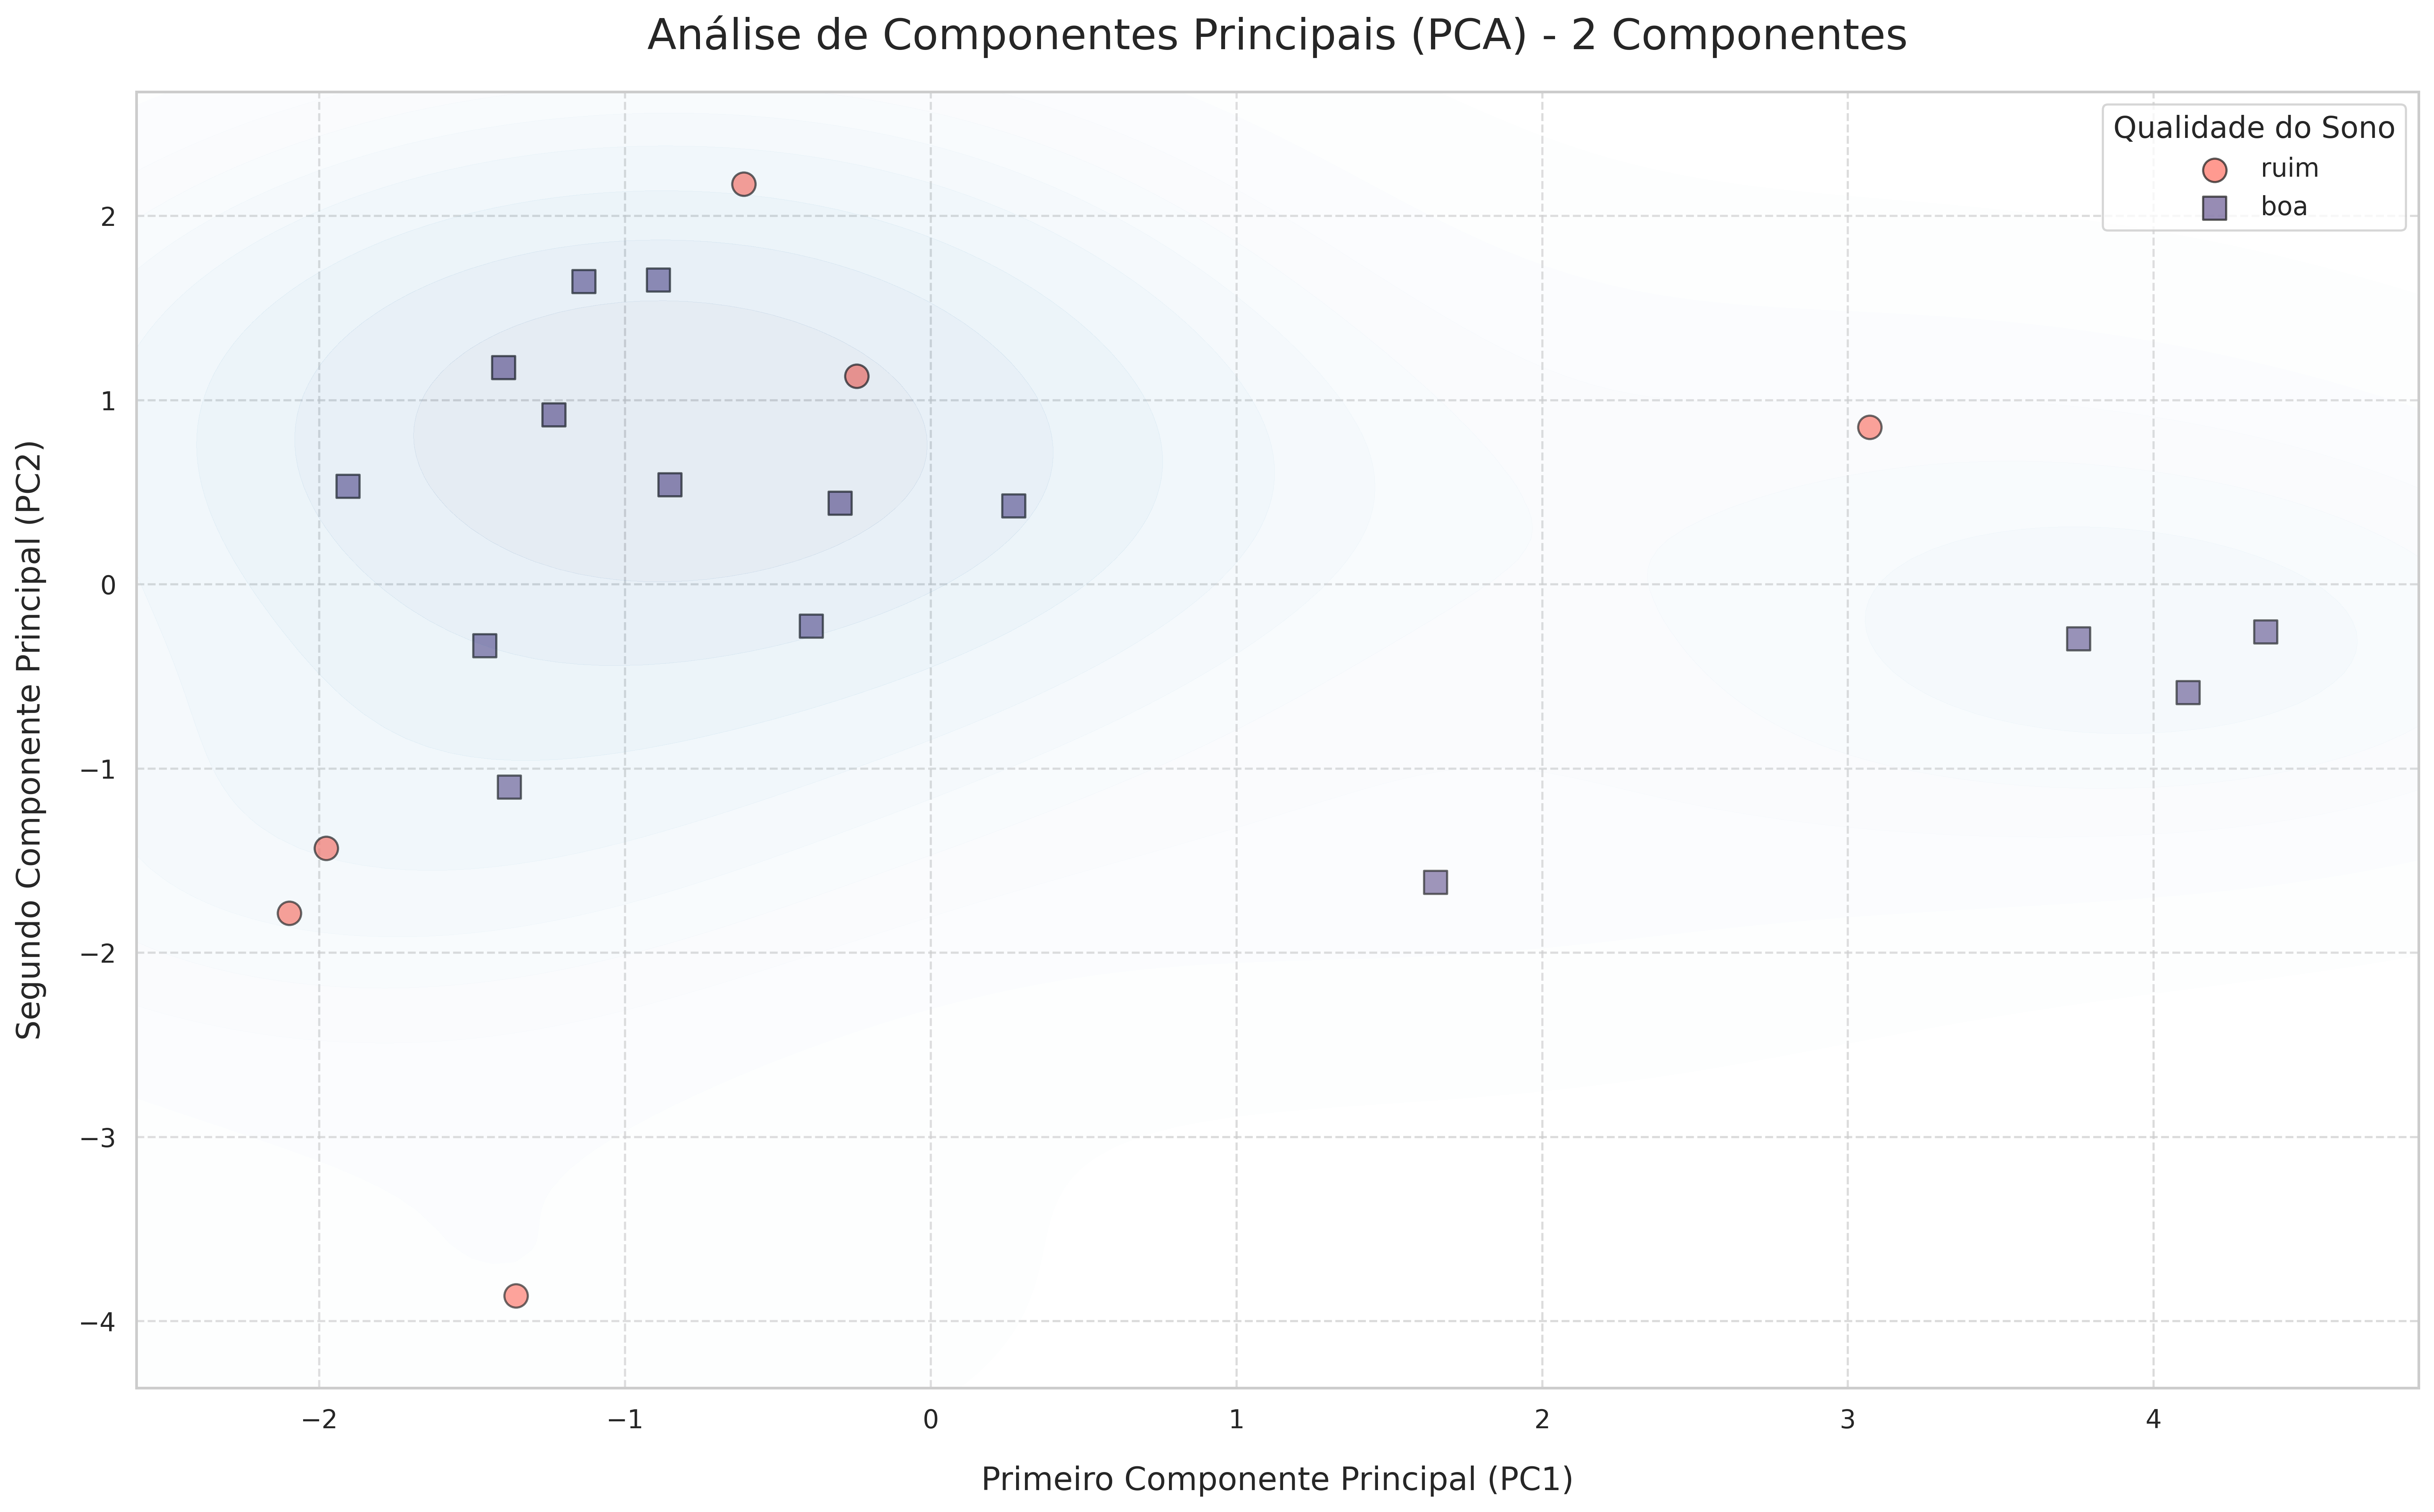

In [164]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Aplicação do PCA
pca = PCA(n_components=2)
prin_componentes = pca.fit_transform(data_scaled_pd[cols[:-1]].values)

df_pca = pd.DataFrame(data=prin_componentes, columns=['PC_1', 'PC_2'])
df_pca = pd.concat([df_pca, pd.DataFrame(data=data_scaled_pd[cols[-1]].values, columns=['target'])], axis=1)

df_pca['target_name'] = df_pca['target'].apply(lambda x: 'ruim' if x == 0 else 'boa')

# Configuração do estilo do gráfico
sns.set(style="whitegrid")
plt.figure(figsize=(16, 10), dpi=400)  # Tamanho maior e DPI alto para alta qualidade
ax = plt.gca()

# Definindo cores e marcadores para cada classe
targets = ['ruim', 'boa']
colors = ['#FF6F61', '#6B5B95']
markers = ['o', 's']

# Plotando os pontos para cada classe
for target, color, marker in zip(targets, colors, markers):
    indicesToKeep = df_pca['target_name'] == target
    ax.scatter(df_pca.loc[indicesToKeep, 'PC_1'],
               df_pca.loc[indicesToKeep, 'PC_2'],
               c=color,
               marker=marker,
               s=120,  # Tamanho dos pontos
               edgecolor='k',
               alpha=0.7,
               label=target)

# Adicionando título e labels
ax.set_title('Análise de Componentes Principais (PCA) - 2 Componentes', fontsize=20, pad=20)
ax.set_xlabel('Primeiro Componente Principal (PC1)', fontsize=15, labelpad=15)
ax.set_ylabel('Segundo Componente Principal (PC2)', fontsize=15, labelpad=15)

# Adicionando grid e legenda
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(title='Qualidade do Sono', title_fontsize=14, fontsize=12, loc='best')

# Melhorando a estética dos eixos
ax.tick_params(axis='both', which='major', labelsize=12)

# Adicionando uma linha de contorno para destacar os clusters
sns.kdeplot(x=df_pca['PC_1'], y=df_pca['PC_2'], cmap="Blues", shade=True, alpha=0.1, ax=ax)

# Ajustando os limites dos eixos para evitar que os pontos fiquem muito próximos das bordas
ax.set_xlim([df_pca['PC_1'].min() - 0.5, df_pca['PC_1'].max() + 0.5])
ax.set_ylim([df_pca['PC_2'].min() - 0.5, df_pca['PC_2'].max() + 0.5])

# Salvando a figura com alta qualidade
plt.savefig('pca_plot_high_quality.png', dpi=400, bbox_inches='tight')  # Salva em PNG com DPI 400
# plt.savefig('pca_plot_high_quality.pdf', dpi=400, bbox_inches='tight')  # Alternativa: Salva em PDF

# Exibindo o gráfico
plt.tight_layout()
plt.show()

### # Resultados

#### # Métricas Agregadas

<ipython-input-192-c2e1d3f77be5>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=metrics, y=means[0], yerr=stds[0], palette='viridis', capsize=5)


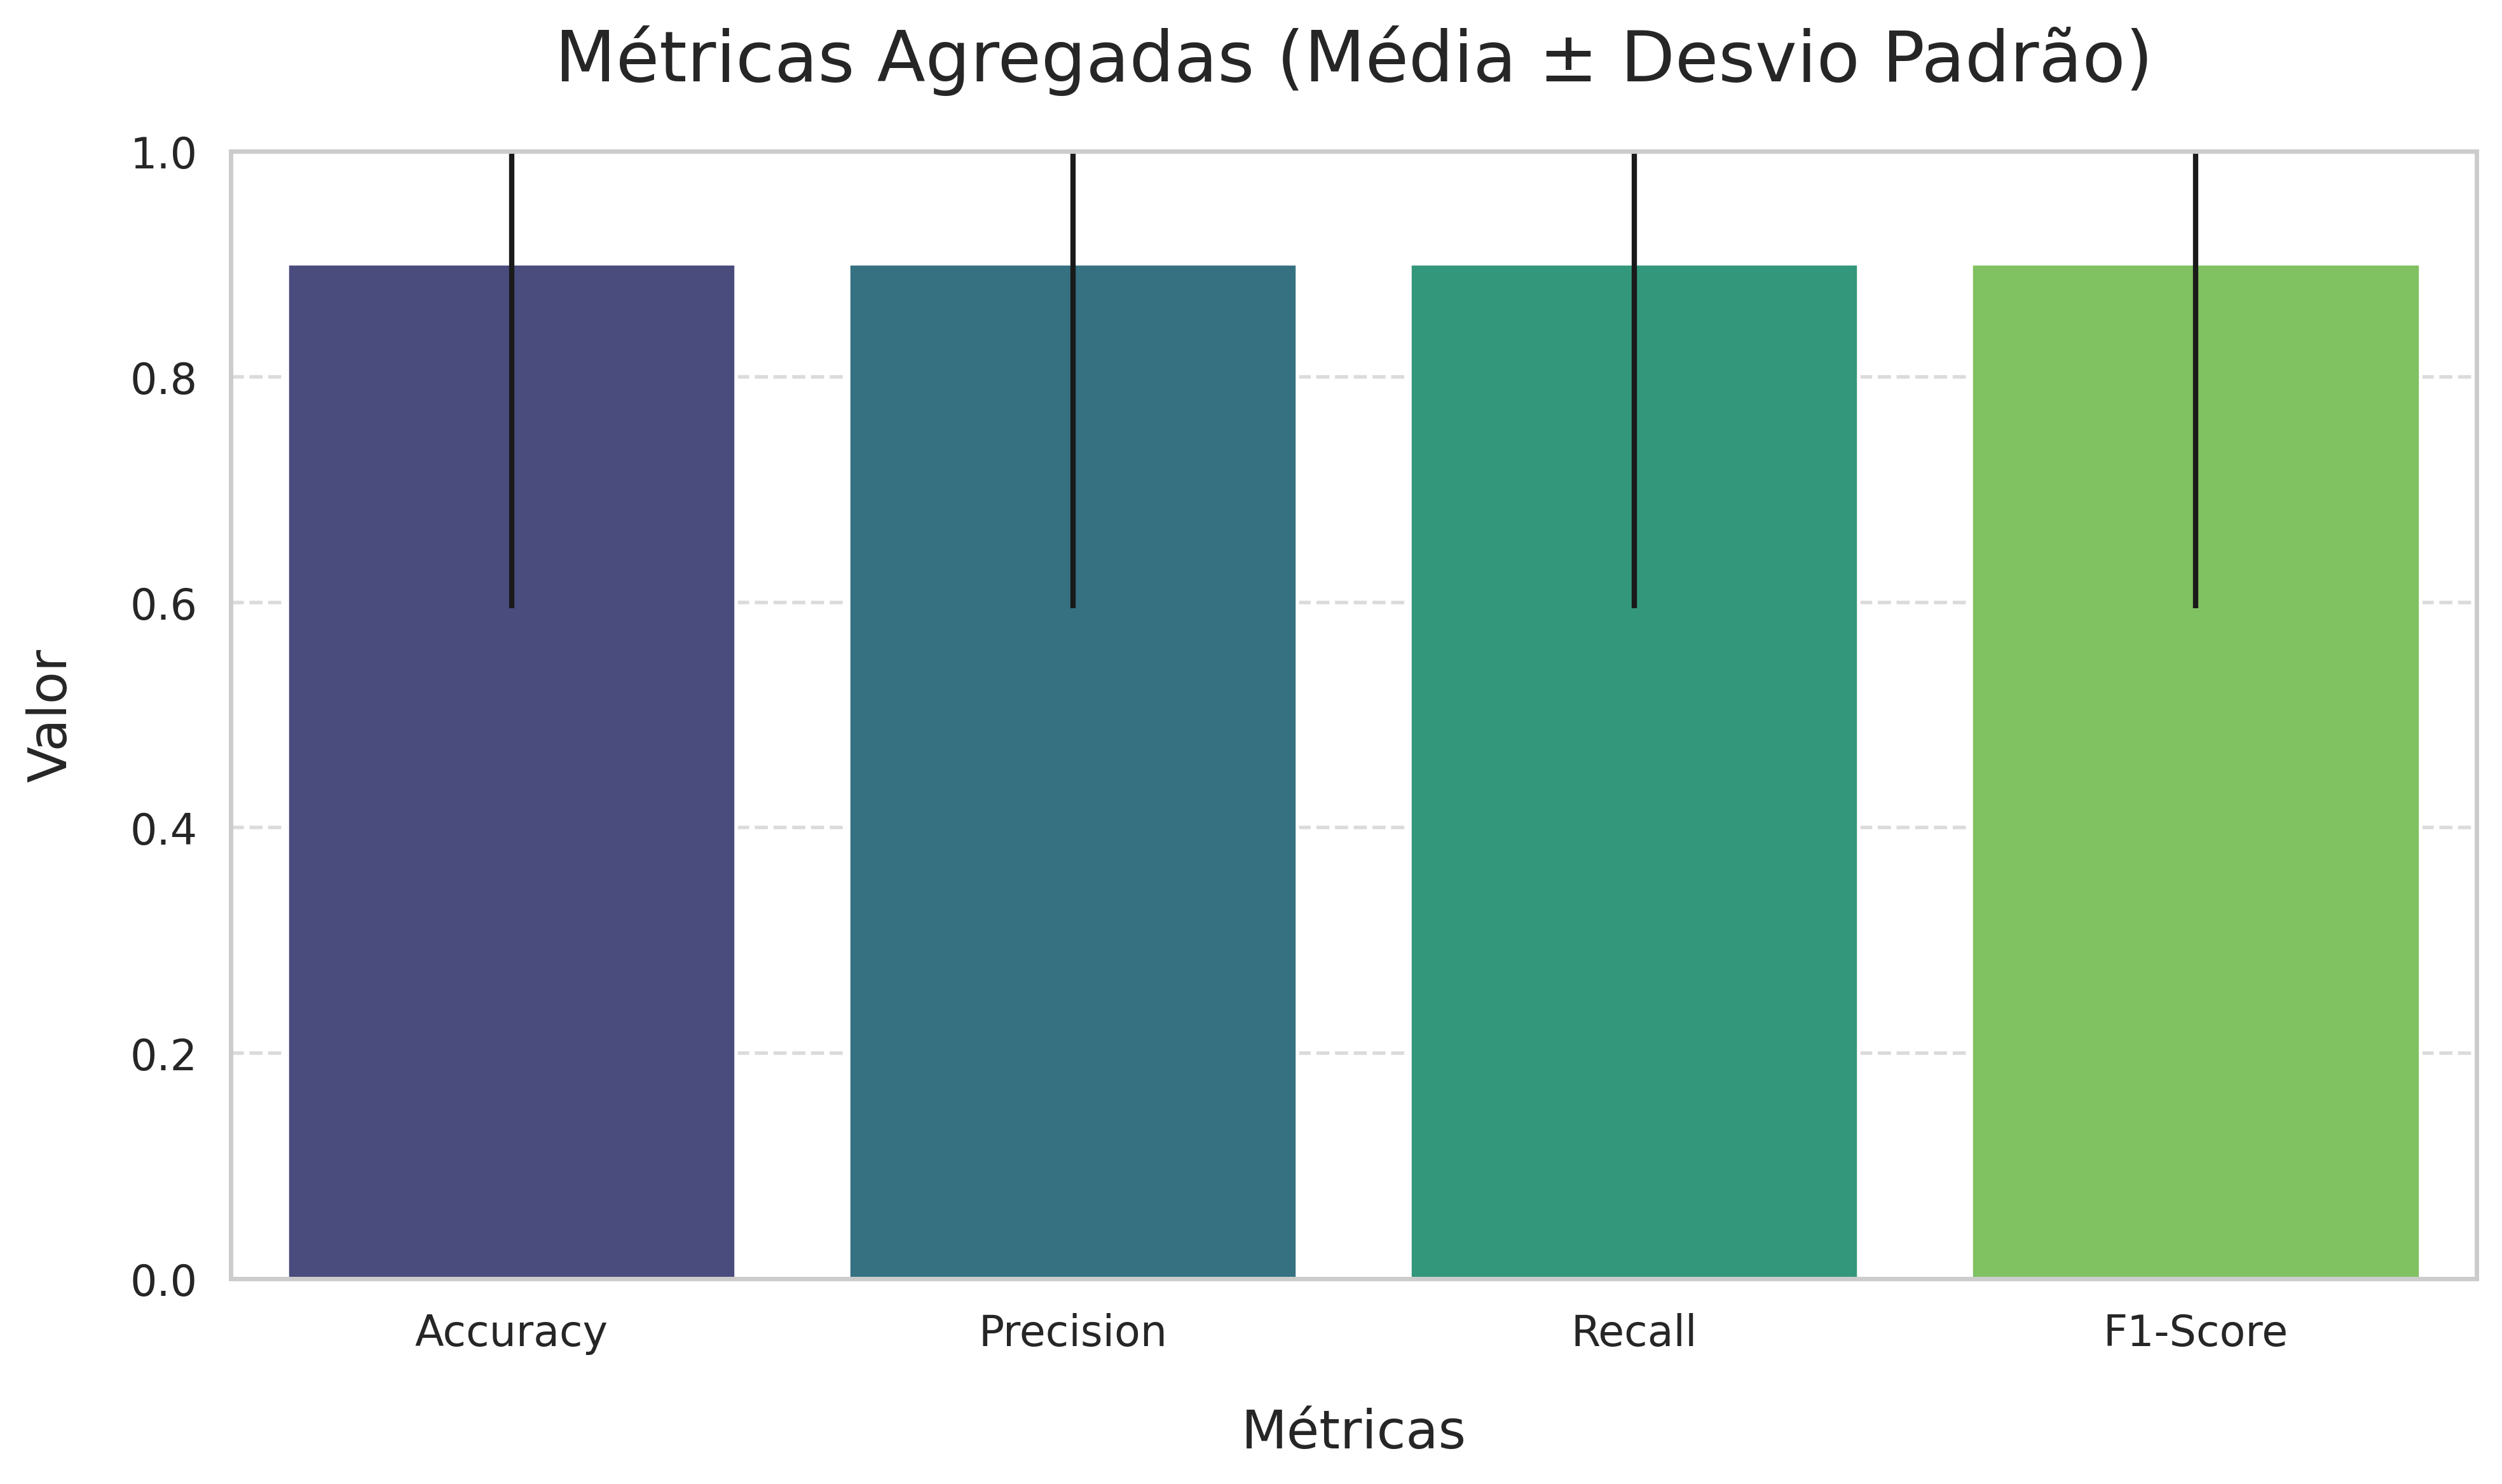

In [192]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dados das métricas agregadas
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
means = aggregated_metrics_df['Mean'].values  # Converte para array numpy
stds = aggregated_metrics_df['Std'].values   # Converte para array numpy

# Configuração do estilo do gráfico
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6), dpi=400)  # Tamanho maior e DPI alto para alta qualidade

# Plot
ax = sns.barplot(x=metrics, y=means[0], yerr=stds[0], palette='viridis', capsize=5)

# Adicionando título e labels
ax.set_title('Métricas Agregadas (Média ± Desvio Padrão)', fontsize=20, pad=20)
ax.set_ylabel('Valor', fontsize=15, labelpad=15)
ax.set_xlabel('Métricas', fontsize=15, labelpad=15)

# Melhorando a estética dos eixos
ax.tick_params(axis='both', which='major', labelsize=12)

# Ajustando os limites do eixo y para métricas normalizadas
ax.set_ylim(0, 1)

# Adicionando grid
ax.grid(True, linestyle='--', alpha=0.7)

# Salvando a figura com alta qualidade
plt.savefig('aggregated_metrics_plot_high_quality.png', dpi=400, bbox_inches='tight')  # Salva em PNG com DPI 400
# plt.savefig('aggregated_metrics_plot_high_quality.pdf', dpi=400, bbox_inches='tight')  # Alternativa: Salva em PDF

# Exibindo o gráfico
plt.tight_layout()
plt.show()

In [193]:
print(aggregated_metrics_df)

      Metric      Mean       Std
0   Accuracy  0.900000  0.305129
1  Precision  0.433333  0.504007
2     Recall  0.433333  0.504007
3   F1-Score  0.433333  0.504007


<ipython-input-194-8595b2cd1b3b>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Metric', y='Value', data=metrics_df, palette='Set2')


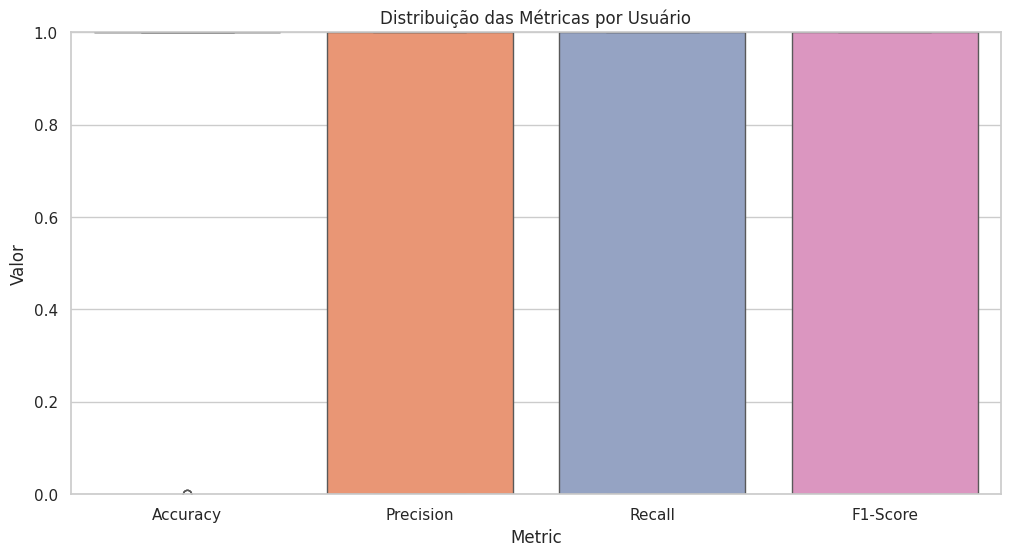

In [194]:
# Prepara os dados para o boxplot
metrics_df = results_df.melt(id_vars=['User'], value_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
                             var_name='Metric', value_name='Value')

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Metric', y='Value', data=metrics_df, palette='Set2')
plt.title('Distribuição das Métricas por Usuário')
plt.ylabel('Valor')
plt.ylim(0, 1)  # Limite do eixo y para métricas normalizadas
plt.savefig('boxplot_metrics_high_quality.png', dpi=400, bbox_inches='tight')
plt.show()

#### # Gráfico de Daispersão das Previsões

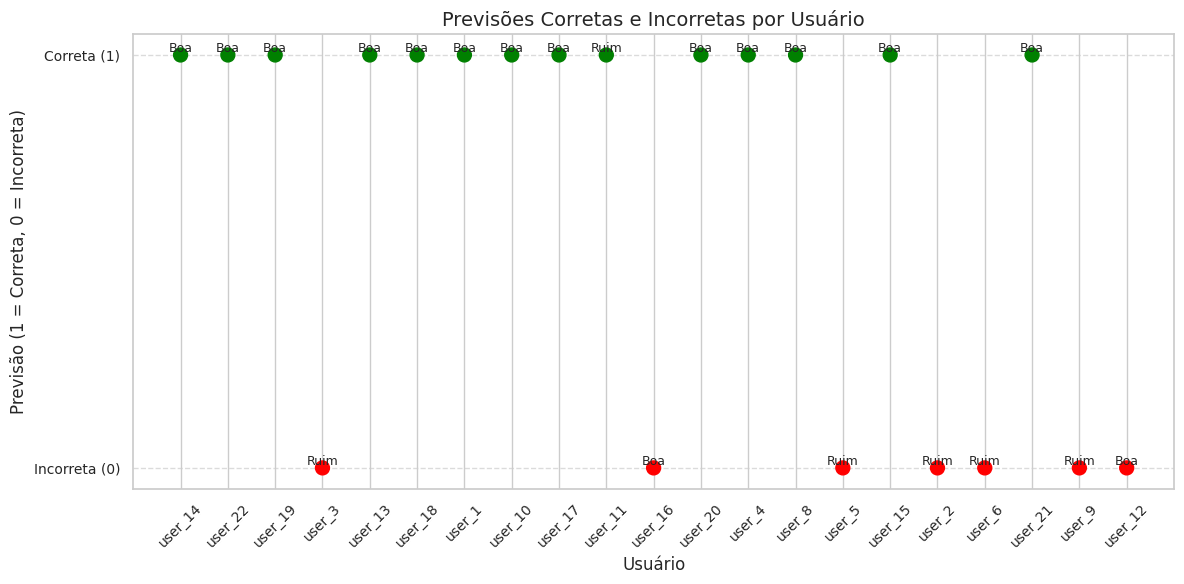

In [195]:
import matplotlib.pyplot as plt

# Prepara os dados
users = [result['User'] for result in results]
correct = [1 if result['Accuracy'] == 1 else 0 for result in results]  # 1 = correto, 0 = incorreto
true_values = [1 if result['Value_True'] == 1 else 0 for result in results]  # 1 = correto, 0 = incorreto

# Define cores personalizadas (verde para acertos, vermelho para erros)
colors = ['green' if c == 1 else 'red' for c in correct]

# Plot
plt.figure(figsize=(12, 6))
scatter = plt.scatter(users, correct, c=colors, s=100)  # Usa as cores personalizadas

# Adiciona anotações para cada ponto
for i, user in enumerate(users):
    plt.text(user, correct[i], f'{"Boa" if true_values[i] == 1 else "Ruim"}',
             fontsize=9, ha='center', va='bottom')

# Personaliza o gráfico
plt.title('Previsões Corretas e Incorretas por Usuário', fontsize=14)
plt.xlabel('Usuário', fontsize=12)
plt.ylabel('Previsão (1 = Correta, 0 = Incorreta)', fontsize=12)
plt.yticks([0, 1], ['Incorreta (0)', 'Correta (1)'], fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.savefig('previsoes_rede_neural_high_quality.png', dpi=400, bbox_inches='tight')
plt.show()

#### # Matriz de Confusão Agregada

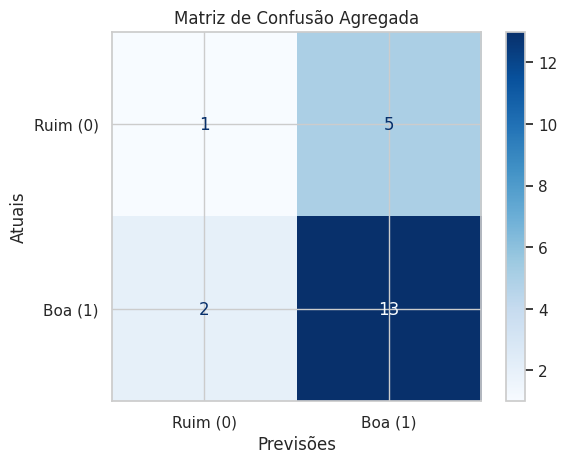

In [168]:
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Inicializa a matriz de confusão agregada com zeros
conf_matrix_aggregated = np.zeros((2, 2))  # Assume um problema de classificação binária

# Soma as matrizes de confusão de todos os usuários
for result in results:
    # Obtém a matriz de confusão do usuário
    user_conf_matrix = result['Confusion Matrix']

    # Se a matriz for 1x1, expande para 2x2
    if user_conf_matrix.shape == (1, 1):
        expanded_conf_matrix = np.zeros((2, 2))
        if result['Value_True'] == 0:
            expanded_conf_matrix[0, 0] = user_conf_matrix[0, 0]  # Verdadeiros positivos para classe 0
        else:
            expanded_conf_matrix[1, 1] = user_conf_matrix[0, 0]  # Verdadeiros positivos para classe 1
    else:
        expanded_conf_matrix = user_conf_matrix

    # Soma à matriz agregada
    conf_matrix_aggregated += expanded_conf_matrix

# Define os rótulos das classes
class_names = ['Ruim (0)', 'Boa (1)']

# Plot da matriz de confusão agregada
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_aggregated, display_labels=class_names)
disp.plot(cmap='Blues')

# Altera os rótulos dos eixos
disp.ax_.set_xlabel('Previsões')  # Altera o rótulo do eixo X
disp.ax_.set_ylabel('Atuais')     # Altera o rótulo do eixo Y

plt.title('Matriz de Confusão Agregada')
plt.savefig('matriz_rede_neural_high_quality.png', dpi=400, bbox_inches='tight')
plt.show()

#### # Gráfico de Curva ROC

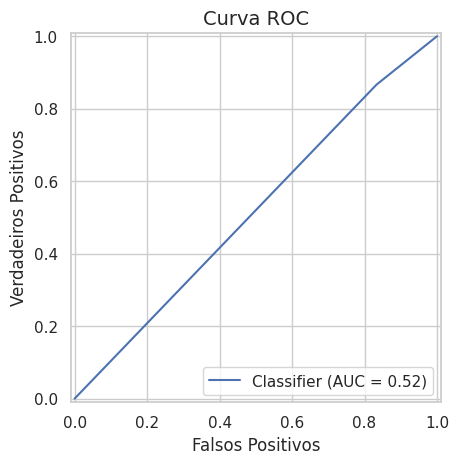

In [169]:
from sklearn.metrics import RocCurveDisplay
import numpy as np
import matplotlib.pyplot as plt

# Listas para armazenar rótulos reais e probabilidades previstas
y_true_list = []
y_probs_list = []

# Coleta os rótulos reais e as probabilidades previstas
for result in results:
    user = result['User']
    # Pega as probabilidades previstas
    y_probs_list.append(result['Value_Pred'])  # Adiciona as probabilidades
    y_true_list.append(result['Value_True'])  # Adiciona os rótulos reais

# Converte para arrays numpy
y_true = np.array(y_true_list)
y_probs = np.array(y_probs_list)

# Plot da curva ROC
roc_display = RocCurveDisplay.from_predictions(y_true, y_probs)

# Altera os rótulos dos eixos para português
roc_display.ax_.set_xlabel('Falsos Positivos', fontsize=12)  # Altera o rótulo do eixo X
roc_display.ax_.set_ylabel('Verdadeiros Positivos', fontsize=12)  # Altera o rótulo do eixo Y

# Altera o título
plt.title('Curva ROC', fontsize=14)
plt.savefig('ROC_rede_neural_high_quality.png', dpi=400, bbox_inches='tight')
plt.show()

In [217]:
# Exibir a acurácia média do modelo de rede neural avulsa com LOSO
mean_accuracy = aggregated_metrics_df.loc[aggregated_metrics_df['Metric'] == 'Accuracy', 'Mean'].values[0]
std_accuracy = aggregated_metrics_df.loc[aggregated_metrics_df['Metric'] == 'Accuracy', 'Std'].values[0]

print(f"Acurácia Média do Modelo de Rede Neural Avulsa com LOSO: {mean_accuracy:.2f} ± {std_accuracy:.2f}")

Acurácia Média do Modelo de Rede Neural Avulsa com LOSO: 0.90 ± 0.31


### SMOTE - LOSO

In [170]:
# Aplicação do SMOTE para balanceamento das classes
smote = SMOTE(random_state=42, k_neighbors=3)
X_resampled, y_resampled = smote.fit_resample(data_scaled_pd.drop(columns=['target', 'user']).values, data_scaled_pd['target'].values)

In [171]:
data_scaled_pd

Movement Index  Fragmentation Index     STAI2  In Bed Cos  In Bed Sin  \
0        -0.603613            -0.780655  0.684546    0.552006   -0.008015   
1        -0.333508            -0.905308  1.251998    0.484245    0.586393   
2         3.094840             1.219785 -1.206962    0.478086   -0.887567   
3        -0.480692            -0.837383 -2.720169    0.552938   -0.039843   
4         0.472805             0.576217  0.306244    0.542554   -0.432040   
5         1.375162             2.013418  0.495395   -2.355379   -1.324732   
6         0.193736             0.705008  0.306244    0.520181    0.370664   
7        -0.995471            -0.599812  0.873697    0.172999    1.461477   
8        -0.553893            -0.803601  1.441149    0.539943    0.192830   
9        -0.320276            -0.911415  0.306244   -0.006110    1.735996   
10       -0.158691            -0.985987 -0.072057    0.522942    0.349868   
11       -0.934781            -0.627820  0.117093    0.473840    0.636932   
12       -0.635808            -0.765797 -0.261208    0.499422    0.504827   
13        0.684741             2.332048 -0.450359   -2.483606   -0.857201   
14        0.234169             0.686348  1.062847   -0.716520   -2.528695   
15        1.212763             0.234725  0.117093    0.537068    0.224372   
16        0.986473             0.339159 -0.450359    0.511203    0.432814   
17       -0.602356            -0.781235  1.062847    0.273131    1.260710   
18       -0.691498             1.113544 -1.206962   -2.198643   -1.683650   
19       -1.255942            -0.479604 -0.072057    0.554076   -0.114163   
20       -0.688160            -0.741636 -1.585264    0.545624    0.119024   

    Out Bed Cos  Out Bed Sin  Onset Cos  Onset Sin     user  target  
0      1.261458     0.814293   0.562736  -0.083466  user_14       1  
1      0.798901     0.732687   0.494643   0.500494  user_22       1  
2     -1.211698    -1.063650   0.506253  -0.857699  user_19       1  
3      2.101976     0.675301   0.555595   0.051715   user_3       0  
4      0.116189     0.401772   0.561072  -0.375420  user_13       1  
5      0.034918     0.344908  -2.358853  -1.377035  user_18       1  
6     -0.325425     0.045119   0.530755   0.288557   user_1       1  
7      0.320978     0.528202   0.181877   1.360194  user_10       1  
8      1.303621     0.816150   0.546703   0.155152  user_17       1  
9     -1.247264    -1.120815  -0.146128   1.796865  user_11       0  
10    -1.012652    -0.763394   0.479808   0.569904  user_16       1  
11    -0.501820    -0.131310   0.484188   0.550144  user_20       1  
12     0.507002     0.622623   0.509894   0.420362   user_4       1  
13    -0.166430     0.187171  -2.487707  -0.917723   user_8       1  
14     0.465538     0.603235  -0.625407  -2.531347   user_5       0  
15     0.218310     0.467805   0.496650   0.490522  user_15       1  
16     0.903721     0.761066   0.521734   0.349614   user_2       0  
17    -1.121932    -0.924183   0.282498   1.162956   user_6       0  
18    -0.206361     0.152972  -2.201352  -1.729643  user_21       1  
19    -2.334864    -3.537843   0.548717   0.134514   user_9       0  
20     0.095835     0.387891   0.556322   0.041340  user_12       1

In [172]:
ldf = []
idx_user = 0
name_user = "smote_"
cols = [col for col in data_scaled_pd.columns]

for sample, target in zip(X_resampled, y_resampled):
    idx_selected = data_scaled_pd[data_scaled_pd["Movement Index"] == sample[0]]
    if idx_selected.size > 0:
        ldf.append(np.asarray(idx_selected.values[0].tolist()))
    elif idx_selected.size == 0:
        name = [name_user + str(idx_user)]
        sample = sample.tolist() + name + [target]
        ldf.append(np.asarray(sample))
        idx_user += 1

df_smote = pd.DataFrame(ldf, columns=cols)
df_smote['Movement Index'] = df_smote['Movement Index'].astype('float')
df_smote['Fragmentation Index'] = df_smote['Fragmentation Index'].astype('float')
df_smote['STAI2'] = df_smote['STAI2'].astype('float')
df_smote['In Bed Cos'] = df_smote['In Bed Cos'].astype('float')
df_smote['In Bed Sin'] = df_smote['In Bed Sin'].astype('float')
df_smote['Out Bed Cos'] = df_smote['Out Bed Cos'].astype('float')
df_smote['Out Bed Sin'] = df_smote['Out Bed Sin'].astype('float')
df_smote['Onset Cos'] = df_smote['Onset Cos'].astype('float')
df_smote['Onset Sin'] = df_smote['Onset Sin'].astype('float')
df_smote['user'] = df_smote['user'].astype('string')
df_smote['target'] = df_smote['target'].astype('int')
df_smote.head()

Movement Index  Fragmentation Index     STAI2  In Bed Cos  In Bed Sin  \
0       -0.603613            -0.780655  0.684546    0.552006   -0.008015   
1       -0.333508            -0.905308  1.251998    0.484245    0.586393   
2        3.094840             1.219785 -1.206962    0.478086   -0.887567   
3       -0.480692            -0.837383 -2.720169    0.552938   -0.039843   
4        0.472805             0.576217  0.306244    0.542554   -0.432040   

   Out Bed Cos  Out Bed Sin  Onset Cos  Onset Sin     user  target  
0     1.261458     0.814293   0.562736  -0.083466  user_14       1  
1     0.798901     0.732687   0.494643   0.500494  user_22       1  
2    -1.211698    -1.063650   0.506253  -0.857699  user_19       1  
3     2.101976     0.675301   0.555595   0.051715   user_3       0  
4     0.116189     0.401772   0.561072  -0.375420  user_13       1

In [173]:
df_smote.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Movement Index       30 non-null     float64
 1   Fragmentation Index  30 non-null     float64
 2   STAI2                30 non-null     float64
 3   In Bed Cos           30 non-null     float64
 4   In Bed Sin           30 non-null     float64
 5   Out Bed Cos          30 non-null     float64
 6   Out Bed Sin          30 non-null     float64
 7   Onset Cos            30 non-null     float64
 8   Onset Sin            30 non-null     float64
 9   user                 30 non-null     string 
 10  target               30 non-null     int64  
dtypes: float64(9), int64(1), string(1)
memory usage: 2.7 KB


In [174]:
cols = ["Movement Index",
        "Fragmentation Index",
        "STAI2",
        "In Bed Cos",
        "In Bed Sin",
        "Out Bed Cos",
        "Out Bed Sin",
        "Onset Cos",
        "Onset Sin",
        "target"]

# Listas para armazenar resultados
results_smote = []
l_class_boa = []
l_class_ruim = []

# Função para calcular métricas e armazenar resultados
def evaluate_model(y_true, y_pred, user):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Armazena resultados
    results_smote.append({
        'User': user,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Value_True': y_true[0],
        'Value_Pred': y_pred[0][0],
        'Confusion Matrix': conf_matrix
    })

    # Classifica as previsões
    if y_true == 1:
        l_class_boa.append((user, y_true[0], y_pred[0][0]))
    elif y_true == 0:
        l_class_ruim.append((user, y_true[0], y_pred[0][0]))

    return accuracy, precision, recall, f1, conf_matrix

# Loop para validação LOSO
for user in df_smote.user.values:
    # Separa dados de treino
    X_train = df_smote[df_smote.user != user][cols[:-1]].values
    y_train = df_smote[df_smote.user != user][cols[-1]].values

    # Separa dados de teste
    X_test = df_smote[df_smote.user == user][cols[:-1]].values
    y_test = df_smote[df_smote.user == user][cols[-1]].values

    # Chama o modelo
    print(f"\n Modelo do usuário {user}. \n\n")
    model = get_model()

    # Treina o modelo
    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=1,
        callbacks=[LearningRateScheduler(lr_scheduler)]
    )

    # Gera previsões
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)

    # Calcula métricas e armazena resultados
    accuracy, precision, recall, f1, conf_matrix = evaluate_model(y_test, y_pred_classes, user)

    # Exibe métricas
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1-Score: {f1:.2f}')
    print(f'Confusion Matrix:\n{conf_matrix}')
    print(f"\n ------------------------ \n")

# Converte resultados para DataFrame
results_df = pd.DataFrame(results_smote)

# Calcula métricas agregadas (média e desvio padrão)
aggregated_metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Mean': [
        results_df['Accuracy'].mean(),
        results_df['Precision'].mean(),
        results_df['Recall'].mean(),
        results_df['F1-Score'].mean()
    ],
    'Std': [
        results_df['Accuracy'].std(),
        results_df['Precision'].std(),
        results_df['Recall'].std(),
        results_df['F1-Score'].std()
    ]
}

# Converte métricas agregadas para DataFrame
aggregated_metrics_df = pd.DataFrame(aggregated_metrics)

# Exibe resultados agregados
print("\n Métricas Agregadas:")
print(aggregated_metrics_df)

# Salva resultados em arquivos CSV
results_df.to_csv('resultados_por_usuario_smote.csv', index=False)
aggregated_metrics_df.to_csv('metricas_agregadas_smote.csv', index=False)

# Exibe classificações
print('\nClassificação Boa:')
print(l_class_boa)
print('---------------')
print('Classificação Ruim:')
print(l_class_ruim)


 Modelo do usuário user_14. 


Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4634 - loss: 0.7480 - learning_rate: 0.0010
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6942 - loss: 0.6010 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7880 - loss: 0.5447 - learning_rate: 0.0010
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8287 - loss: 0.4560 - learning_rate: 0.0010
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9574 - loss: 0.3403 - learning_rate: 0.0010
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9790 - loss: 0.3120 - learning_rate: 9.0484e-04
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9913 - loss: 0.2466 - learning_rate: 8.1873e-04
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.2075 - learning_rate: 7.4082e-04
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.1823 - learni

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6225 - loss: 0.6900 - learning_rate: 0.0010
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8226 - loss: 0.5614 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8108 - loss: 0.5073 - learning_rate: 0.0010
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9286 - loss: 0.4698 - learning_rate: 0.0010
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8448 - loss: 0.3919 - learning_rate: 0.0010
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9848 - loss: 0.2973 - learning_rate: 9.0484e-04
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9589 - loss: 0.2570 - learning_rate: 8.1873e-04
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9362 - loss: 0.2878 - learning_rate: 7.4082e-04
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9893 - loss: 0.2081 - learning_rate: 6.7032e-04
Epoch 10/20
29/29 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5410 - loss: 0.6854 - learning_rate: 0.0010
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8155 - loss: 0.5259 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8780 - loss: 0.4752 - learning_rate: 0.0010
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9253 - loss: 0.3489 - learning_rate: 0.0010
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8306 - loss: 0.3361 - learning_rate: 0.0010
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9291 - loss: 0.3003 - learning_rate: 9.0484e-04
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9455 - loss: 0.2037 - learning_rate: 8.1873e-04
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8704 - loss: 0.2310 - learning_rate: 7.4082e-04
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9574 - loss: 0.1844 - learning_rate: 6.7032e-04
Epoch 10/20
29/29 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5966 - loss: 0.7330 - learning_rate: 0.0010
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6761 - loss: 0.5744 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9479 - loss: 0.5046 - learning_rate: 0.0010
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9230 - loss: 0.4139 - learning_rate: 0.0010
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9319 - loss: 0.4022 - learning_rate: 0.0010
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9477 - loss: 0.3277 - learning_rate: 9.0484e-04
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9168 - loss: 0.3097 - learning_rate: 8.1873e-04
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9495 - loss: 0.3432 - learning_rate: 7.4082e-04
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9450 - loss: 0.2582 - learning_rate: 6.7032e-04
Epoch 10/20
29/29 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8183 - loss: 0.6548 - learning_rate: 0.0010
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7749 - loss: 0.5458 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9627 - loss: 0.4620 - learning_rate: 0.0010
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9702 - loss: 0.3217 - learning_rate: 0.0010
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9851 - loss: 0.3344 - learning_rate: 0.0010
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9953 - loss: 0.2810 - learning_rate: 9.0484e-04
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9752 - loss: 0.2685 - learning_rate: 8.1873e-04
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.1988 - learning_rate: 7.4082e-04
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9794 - loss: 0.1390 - learning_rate: 6.7032e-04
Epoch 10/20
29/29 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5443 - loss: 0.7169 - learning_rate: 0.0010
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6646 - loss: 0.6053 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9245 - loss: 0.4919 - learning_rate: 0.0010
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7312 - loss: 0.4775 - learning_rate: 0.0010
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9851 - loss: 0.3602 - learning_rate: 0.0010
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9965 - loss: 0.3424 - learning_rate: 9.0484e-04
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9796 - loss: 0.2691 - learning_rate: 8.1873e-04
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.1987 - learning_rate: 7.4082e-04
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.1963 - learning_rate: 6.7032e-04
Epoch 10/20
29/29 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3467 - loss: 0.7260 - learning_rate: 0.0010
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8541 - loss: 0.5630 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9089 - loss: 0.4603 - learning_rate: 0.0010
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8550 - loss: 0.4516 - learning_rate: 0.0010
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7371 - loss: 0.4399 - learning_rate: 0.0010
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9561 - loss: 0.3743 - learning_rate: 9.0484e-04
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9356 - loss: 0.2867 - learning_rate: 8.1873e-04
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8449 - loss: 0.2627 - learning_rate: 7.4082e-04
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9244 - loss: 0.2407 - learning_rate: 6.7032e-04
Epoch 10/20
29/29 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5636 - loss: 0.7262 - learning_rate: 0.0010
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9765 - loss: 0.5974 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7956 - loss: 0.5285 - learning_rate: 0.0010
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9256 - loss: 0.4892 - learning_rate: 0.0010
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9461 - loss: 0.3592 - learning_rate: 0.0010
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9867 - loss: 0.2897 - learning_rate: 9.0484e-04
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9628 - loss: 0.2483 - learning_rate: 8.1873e-04
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9644 - loss: 0.2812 - learning_rate: 7.4082e-04
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9883 - loss: 0.2491 - learning_rate: 6.7032e-04
Epoch 10/20
29/29 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6634 - loss: 0.7096 - learning_rate: 0.0010
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8578 - loss: 0.5879 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8731 - loss: 0.4943 - learning_rate: 0.0010
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9953 - loss: 0.4104 - learning_rate: 0.0010
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9795 - loss: 0.3464 - learning_rate: 0.0010
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.3455 - learning_rate: 9.0484e-04
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9668 - loss: 0.2430 - learning_rate: 8.1873e-04
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.2301 - learning_rate: 7.4082e-04
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9814 - loss: 0.1826 - learning_rate: 6.7032e-04
Epoch 10/20
29/29 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5921 - loss: 0.6660 - learning_rate: 0.0010
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7946 - loss: 0.5657 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8274 - loss: 0.4675 - learning_rate: 0.0010
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8171 - loss: 0.4373 - learning_rate: 0.0010
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8323 - loss: 0.3937 - learning_rate: 0.0010
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9684 - loss: 0.2352 - learning_rate: 9.0484e-04
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9302 - loss: 0.1996 - learning_rate: 8.1873e-04
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9687 - loss: 0.1704 - learning_rate: 7.4082e-04
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9461 - loss: 0.1649 - learning_rate: 6.7032e-04
Epoch 10/20
29/29 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5984 - loss: 0.6638 - learning_rate: 0.0010
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8563 - loss: 0.5319 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7366 - loss: 0.4906 - learning_rate: 0.0010
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9848 - loss: 0.3608 - learning_rate: 0.0010
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9728 - loss: 0.3531 - learning_rate: 0.0010
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9940 - loss: 0.2714 - learning_rate: 9.0484e-04
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9851 - loss: 0.1956 - learning_rate: 8.1873e-04
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9953 - loss: 0.1538 - learning_rate: 7.4082e-04
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9927 - loss: 0.1575 - learning_rate: 6.7032e-04
Epoch 10/20
29/29 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4008 - loss: 0.6890 - learning_rate: 0.0010
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7842 - loss: 0.5358 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7804 - loss: 0.5721 - learning_rate: 0.0010
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8748 - loss: 0.3781 - learning_rate: 0.0010
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9440 - loss: 0.3831 - learning_rate: 0.0010
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8037 - loss: 0.3659 - learning_rate: 9.0484e-04
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9611 - loss: 0.2649 - learning_rate: 8.1873e-04
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9867 - loss: 0.2306 - learning_rate: 7.4082e-04
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.2236 - learning_rate: 6.7032e-04
Epoch 10/20
29/29 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5480 - loss: 0.6578 - learning_rate: 0.0010
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8544 - loss: 0.5755 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7925 - loss: 0.5204 - learning_rate: 0.0010
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9214 - loss: 0.4497 - learning_rate: 0.0010
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9204 - loss: 0.3322 - learning_rate: 0.0010
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9415 - loss: 0.3594 - learning_rate: 9.0484e-04
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9927 - loss: 0.2723 - learning_rate: 8.1873e-04
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9168 - loss: 0.2576 - learning_rate: 7.4082e-04
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9833 - loss: 0.1946 - learning_rate: 6.7032e-04
Epoch 10/20
29/29 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4301 - loss: 0.7708 - learning_rate: 0.0010
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8854 - loss: 0.5801 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9609 - loss: 0.4965 - learning_rate: 0.0010
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9678 - loss: 0.3780 - learning_rate: 0.0010
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9532 - loss: 0.4506 - learning_rate: 0.0010
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9702 - loss: 0.2968 - learning_rate: 9.0484e-04
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.2803 - learning_rate: 8.1873e-04
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9168 - loss: 0.2589 - learning_rate: 7.4082e-04
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9833 - loss: 0.1789 - learning_rate: 6.7032e-04
Epoch 10/20
29/29 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5824 - loss: 0.6724 - learning_rate: 0.0010
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7876 - loss: 0.5390 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8122 - loss: 0.5215 - learning_rate: 0.0010
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9425 - loss: 0.3960 - learning_rate: 0.0010
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8668 - loss: 0.4134 - learning_rate: 0.0010
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9814 - loss: 0.2988 - learning_rate: 9.0484e-04
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9749 - loss: 0.2201 - learning_rate: 8.1873e-04
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9279 - loss: 0.2661 - learning_rate: 7.4082e-04
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.1599 - learning_rate: 6.7032e-04
Epoch 10/20
29/29 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5620 - loss: 0.6860 - learning_rate: 0.0010
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8519 - loss: 0.5765 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9141 - loss: 0.4902 - learning_rate: 0.0010
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9437 - loss: 0.4565 - learning_rate: 0.0010
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9168 - loss: 0.4071 - learning_rate: 0.0010
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.3132 - learning_rate: 9.0484e-04
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9001 - loss: 0.2701 - learning_rate: 8.1873e-04
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.1464 - learning_rate: 7.4082e-04
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.1585 - learning_rate: 6.7032e-04
Epoch 10/20
29/29 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4258 - loss: 0.7319 - learning_rate: 0.0010
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7184 - loss: 0.5912 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9117 - loss: 0.4732 - learning_rate: 0.0010
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9289 - loss: 0.3908 - learning_rate: 0.0010
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9273 - loss: 0.3591 - learning_rate: 0.0010
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9501 - loss: 0.2895 - learning_rate: 9.0484e-04
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9913 - loss: 0.2077 - learning_rate: 8.1873e-04
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.1789 - learning_rate: 7.4082e-04
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9728 - loss: 0.1790 - learning_rate: 6.7032e-04
Epoch 10/20
29/29 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5068 - loss: 0.6845 - learning_rate: 0.0010
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7531 - loss: 0.5347 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8987 - loss: 0.4802 - learning_rate: 0.0010
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9611 - loss: 0.4251 - learning_rate: 0.0010
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9031 - loss: 0.3610 - learning_rate: 0.0010
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9883 - loss: 0.2912 - learning_rate: 9.0484e-04
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9940 - loss: 0.2142 - learning_rate: 8.1873e-04
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8870 - loss: 0.2444 - learning_rate: 7.4082e-04
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.2123 - learning_rate: 6.7032e-04
Epoch 10/20
29/29 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5234 - loss: 0.6500 - learning_rate: 0.0010
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8267 - loss: 0.5535 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8717 - loss: 0.4827 - learning_rate: 0.0010
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8700 - loss: 0.3946 - learning_rate: 0.0010
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7874 - loss: 0.4033 - learning_rate: 0.0010
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9796 - loss: 0.3179 - learning_rate: 9.0484e-04
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9611 - loss: 0.2620 - learning_rate: 8.1873e-04
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.2258 - learning_rate: 7.4082e-04
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.1949 - learning_rate: 6.7032e-04
Epoch 10/20
29/29 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4395 - loss: 0.7230 - learning_rate: 0.0010
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8187 - loss: 0.5724 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9003 - loss: 0.5183 - learning_rate: 0.0010
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9701 - loss: 0.4267 - learning_rate: 0.0010
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.3998 - learning_rate: 0.0010
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9851 - loss: 0.3504 - learning_rate: 9.0484e-04
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9898 - loss: 0.2570 - learning_rate: 8.1873e-04
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.1900 - learning_rate: 7.4082e-04
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9429 - loss: 0.1882 - learning_rate: 6.7032e-04
Epoch 10/20
29/29 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2820 - loss: 0.7392 - learning_rate: 0.0010
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5741 - loss: 0.6153 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9152 - loss: 0.4961 - learning_rate: 0.0010
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9180 - loss: 0.4831 - learning_rate: 0.0010
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9752 - loss: 0.3662 - learning_rate: 0.0010
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9667 - loss: 0.3280 - learning_rate: 9.0484e-04
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9867 - loss: 0.2612 - learning_rate: 8.1873e-04
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9851 - loss: 0.2471 - learning_rate: 7.4082e-04
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.2296 - learning_rate: 6.7032e-04
Epoch 10/20
29/29 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5417 - loss: 0.6944 - learning_rate: 0.0010
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7771 - loss: 0.5594 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9838 - loss: 0.4783 - learning_rate: 0.0010
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9344 - loss: 0.4065 - learning_rate: 0.0010
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9639 - loss: 0.3187 - learning_rate: 0.0010
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9867 - loss: 0.2828 - learning_rate: 9.0484e-04
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9429 - loss: 0.2424 - learning_rate: 8.1873e-04
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9953 - loss: 0.2010 - learning_rate: 7.4082e-04
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.1564 - learning_rate: 6.7032e-04
Epoch 10/20
29/29 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3845 - loss: 0.7535 - learning_rate: 0.0010
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8821 - loss: 0.5990 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9665 - loss: 0.4726 - learning_rate: 0.0010
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9399 - loss: 0.5042 - learning_rate: 0.0010
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9728 - loss: 0.4069 - learning_rate: 0.0010
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9867 - loss: 0.2641 - learning_rate: 9.0484e-04
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9574 - loss: 0.2633 - learning_rate: 8.1873e-04
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9851 - loss: 0.2235 - learning_rate: 7.4082e-04
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9430 - loss: 0.2316 - learning_rate: 6.7032e-04
Epoch 10/20
29/29 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5200 - loss: 0.7038 - learning_rate: 0.0010
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8349 - loss: 0.5748 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8991 - loss: 0.5162 - learning_rate: 0.0010
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.5257 - learning_rate: 0.0010
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9777 - loss: 0.4184 - learning_rate: 0.0010
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.3195 - learning_rate: 9.0484e-04
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9940 - loss: 0.2889 - learning_rate: 8.1873e-04
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.2256 - learning_rate: 7.4082e-04
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.2226 - learning_rate: 6.7032e-04
Epoch 10/20
29/29 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6816 - loss: 0.6921 - learning_rate: 0.0010
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7931 - loss: 0.5646 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8355 - loss: 0.4891 - learning_rate: 0.0010
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8748 - loss: 0.4390 - learning_rate: 0.0010
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9168 - loss: 0.3842 - learning_rate: 0.0010
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9168 - loss: 0.3829 - learning_rate: 9.0484e-04
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9698 - loss: 0.3134 - learning_rate: 8.1873e-04
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9904 - loss: 0.2198 - learning_rate: 7.4082e-04
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.2511 - learning_rate: 6.7032e-04
Epoch 10/20
29/29 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4254 - loss: 0.7304 - learning_rate: 0.0010
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7468 - loss: 0.6097 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8708 - loss: 0.5101 - learning_rate: 0.0010
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9497 - loss: 0.4553 - learning_rate: 0.0010
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9644 - loss: 0.3016 - learning_rate: 0.0010
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9579 - loss: 0.3026 - learning_rate: 9.0484e-04
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9913 - loss: 0.2845 - learning_rate: 8.1873e-04
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.2330 - learning_rate: 7.4082e-04
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9752 - loss: 0.1676 - learning_rate: 6.7032e-04
Epoch 10/20
29/29 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5967 - loss: 0.7287 - learning_rate: 0.0010
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8168 - loss: 0.5302 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8496 - loss: 0.4928 - learning_rate: 0.0010
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8604 - loss: 0.4430 - learning_rate: 0.0010
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9357 - loss: 0.3975 - learning_rate: 0.0010
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8753 - loss: 0.3541 - learning_rate: 9.0484e-04
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8200 - loss: 0.3651 - learning_rate: 8.1873e-04
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9385 - loss: 0.2375 - learning_rate: 7.4082e-04
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9760 - loss: 0.1921 - learning_rate: 6.7032e-04
Epoch 10/20
29/29 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4002 - loss: 0.7543 - learning_rate: 0.0010
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5606 - loss: 0.6045 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8987 - loss: 0.4988 - learning_rate: 0.0010
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9452 - loss: 0.4212 - learning_rate: 0.0010
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8948 - loss: 0.4053 - learning_rate: 0.0010
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9795 - loss: 0.2941 - learning_rate: 9.0484e-04
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9851 - loss: 0.2664 - learning_rate: 8.1873e-04
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9814 - loss: 0.2333 - learning_rate: 7.4082e-04
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.1598 - learning_rate: 6.7032e-04
Epoch 10/20
29/29 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5754 - loss: 0.6909 - learning_rate: 0.0010
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9119 - loss: 0.5321 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9352 - loss: 0.4363 - learning_rate: 0.0010
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9452 - loss: 0.3837 - learning_rate: 0.0010
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9675 - loss: 0.3426 - learning_rate: 0.0010
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9816 - loss: 0.2451 - learning_rate: 9.0484e-04
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.2899 - learning_rate: 8.1873e-04
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.1816 - learning_rate: 7.4082e-04
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9574 - loss: 0.1852 - learning_rate: 6.7032e-04
Epoch 10/20
29/29 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2433 - loss: 0.7420 - learning_rate: 0.0010
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7933 - loss: 0.6359 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8386 - loss: 0.5419 - learning_rate: 0.0010
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8364 - loss: 0.4664 - learning_rate: 0.0010
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9238 - loss: 0.3312 - learning_rate: 0.0010
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8612 - loss: 0.4041 - learning_rate: 9.0484e-04
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8920 - loss: 0.3069 - learning_rate: 8.1873e-04
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9611 - loss: 0.2437 - learning_rate: 7.4082e-04
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9524 - loss: 0.2101 - learning_rate: 6.7032e-04
Epoch 10/20
29/29 ━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py

### # Observação da distribuição dos dados com smote

<ipython-input-175-f40764fb10b8>:49: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=df_pca['PC_1'], y=df_pca['PC_2'], cmap="Blues", shade=True, alpha=0.1, ax=ax)


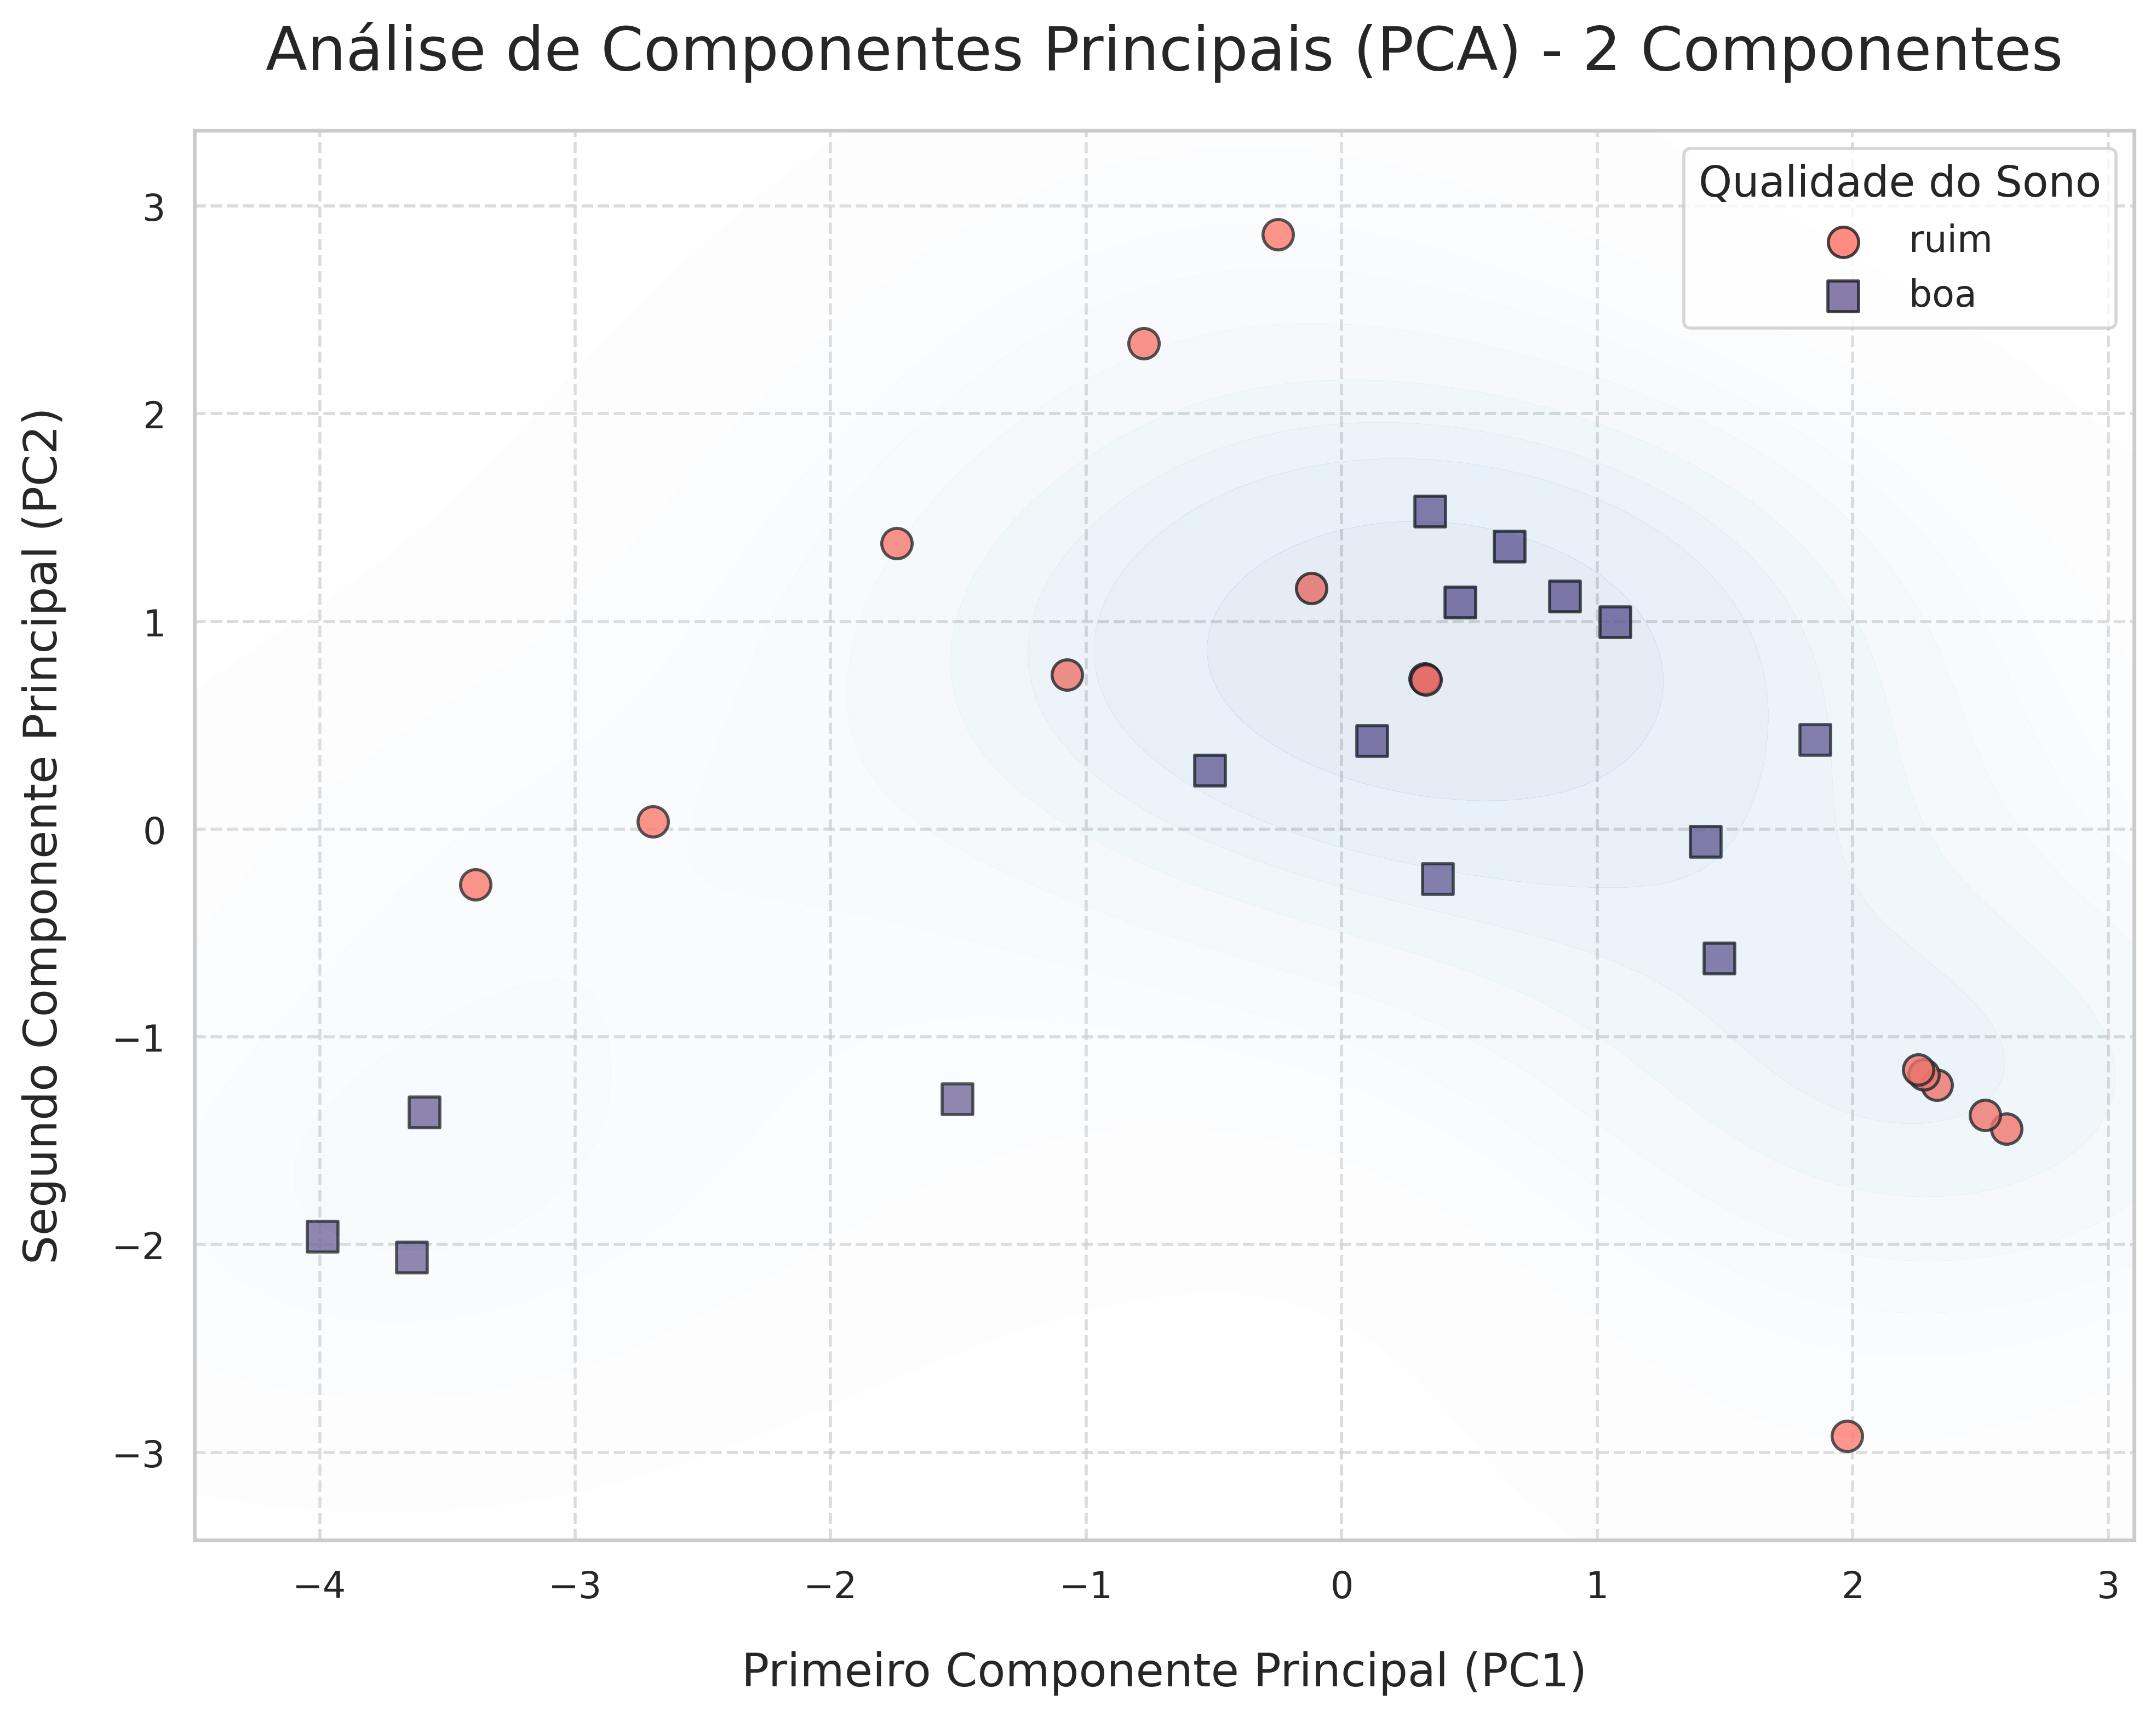

In [175]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Aplicação do PCA
pca = PCA(n_components=2)
prin_componentes = pca.fit_transform(df_smote[cols[:-1]].values)

df_pca = pd.DataFrame(data=prin_componentes, columns=['PC_1', 'PC_2'])
df_pca = pd.concat([df_pca, pd.DataFrame(data=df_smote[cols[-1]].values, columns=['target'])], axis=1)

df_pca['target_name'] = df_pca['target'].apply(lambda x: 'ruim' if x == 0 else 'boa')

# Configuração do estilo do gráfico
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8), dpi=400)  # Tamanho maior e DPI alto para alta qualidade
ax = plt.gca()

# Definindo cores e marcadores para cada classe
targets = ['ruim', 'boa']
colors = ['#FF6F61', '#6B5B95']  # Cores modernas
markers = ['o', 's']  # Marcadores diferentes para cada classe

# Plotando os pontos para cada classe
for target, color, marker in zip(targets, colors, markers):
    indicesToKeep = df_pca['target_name'] == target
    ax.scatter(df_pca.loc[indicesToKeep, 'PC_1'],
               df_pca.loc[indicesToKeep, 'PC_2'],
               c=color,
               marker=marker,
               s=100,  # Tamanho dos pontos
               edgecolor='k',  # Borda preta nos pontos
               alpha=0.8,  # Transparência leve
               label=target)

# Adicionando título e labels
ax.set_title('Análise de Componentes Principais (PCA) - 2 Componentes', fontsize=20, pad=20)
ax.set_xlabel('Primeiro Componente Principal (PC1)', fontsize=15, labelpad=15)
ax.set_ylabel('Segundo Componente Principal (PC2)', fontsize=15, labelpad=15)

# Adicionando grid e legenda
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(title='Qualidade do Sono', title_fontsize=14, fontsize=12, loc='best')

# Melhorando a estética dos eixos
ax.tick_params(axis='both', which='major', labelsize=12)

# Adicionando uma linha de contorno para destacar os clusters (os "negocinhos azuis")
sns.kdeplot(x=df_pca['PC_1'], y=df_pca['PC_2'], cmap="Blues", shade=True, alpha=0.1, ax=ax)

# Ajustando os limites dos eixos para evitar que os pontos fiquem muito próximos das bordas
ax.set_xlim([df_pca['PC_1'].min() - 0.5, df_pca['PC_1'].max() + 0.5])
ax.set_ylim([df_pca['PC_2'].min() - 0.5, df_pca['PC_2'].max() + 0.5])

# Salvando a figura com alta qualidade
plt.savefig('pca_plot_smote_high_quality.png', dpi=400, bbox_inches='tight')  # Salva em PNG com DPI 400
# plt.savefig('pca_plot_smote_high_quality.pdf', dpi=400, bbox_inches='tight')  # Alternativa: Salva em PDF

# Exibindo o gráfico
plt.tight_layout()
plt.show()

#### # Métricas Agregadas

<ipython-input-176-c2e1d3f77be5>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=metrics, y=means[0], yerr=stds[0], palette='viridis', capsize=5)


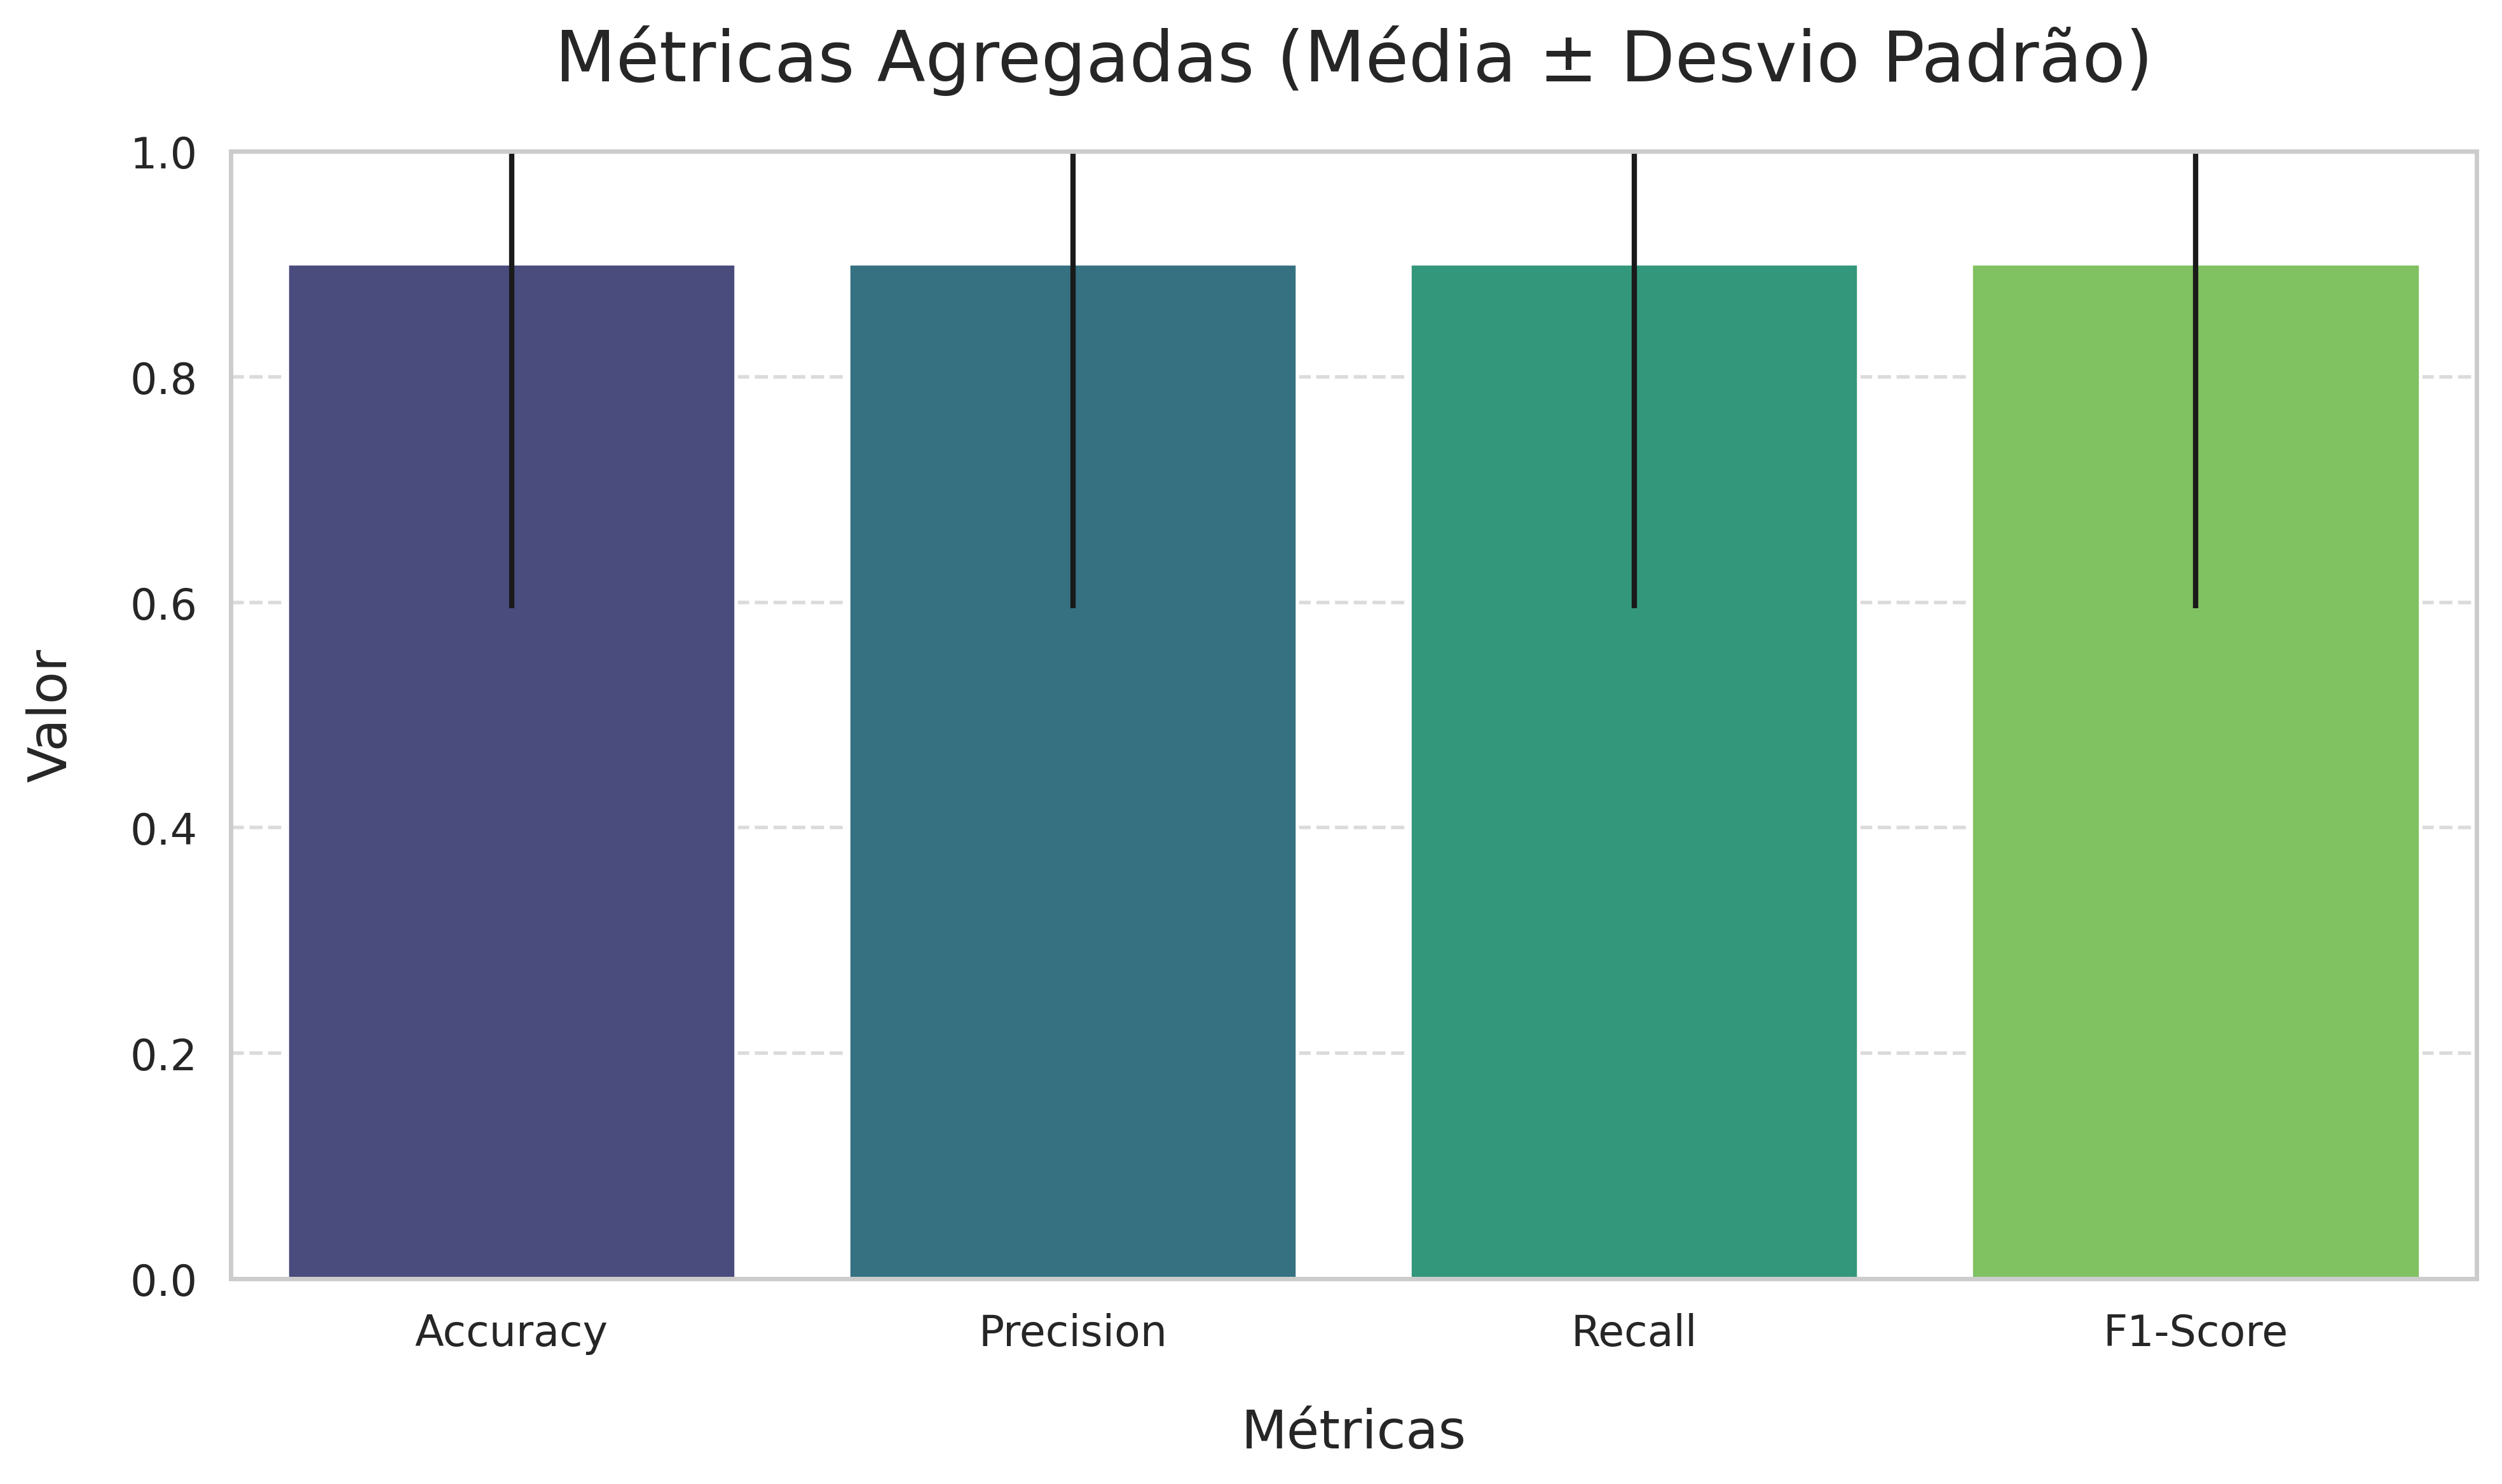

In [176]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dados das métricas agregadas
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
means = aggregated_metrics_df['Mean'].values  # Converte para array numpy
stds = aggregated_metrics_df['Std'].values   # Converte para array numpy

# Configuração do estilo do gráfico
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6), dpi=400)  # Tamanho maior e DPI alto para alta qualidade

# Plot
ax = sns.barplot(x=metrics, y=means[0], yerr=stds[0], palette='viridis', capsize=5)

# Adicionando título e labels
ax.set_title('Métricas Agregadas (Média ± Desvio Padrão)', fontsize=20, pad=20)
ax.set_ylabel('Valor', fontsize=15, labelpad=15)
ax.set_xlabel('Métricas', fontsize=15, labelpad=15)

# Melhorando a estética dos eixos
ax.tick_params(axis='both', which='major', labelsize=12)

# Ajustando os limites do eixo y para métricas normalizadas
ax.set_ylim(0, 1)

# Adicionando grid
ax.grid(True, linestyle='--', alpha=0.7)

# Salvando a figura com alta qualidade
plt.savefig('aggregated_metrics_plot_high_quality.png', dpi=400, bbox_inches='tight')  # Salva em PNG com DPI 400
# plt.savefig('aggregated_metrics_plot_high_quality.pdf', dpi=400, bbox_inches='tight')  # Alternativa: Salva em PDF

# Exibindo o gráfico
plt.tight_layout()
plt.show()

#### # Gráfico de Daispersão das Previsões

In [177]:
results_smote

[{'User': 'user_14',
  'Accuracy': 1.0,
  'Precision': 1.0,
  'Recall': 1.0,
  'F1-Score': 1.0,
  'Value_True': 1,
  'Value_Pred': 1,
  'Confusion Matrix': array([[1]])},
 {'User': 'user_22',
  'Accuracy': 1.0,
  'Precision': 1.0,
  'Recall': 1.0,
  'F1-Score': 1.0,
  'Value_True': 1,
  'Value_Pred': 1,
  'Confusion Matrix': array([[1]])},
 {'User': 'user_19',
  'Accuracy': 1.0,
  'Precision': 1.0,
  'Recall': 1.0,
  'F1-Score': 1.0,
  'Value_True': 1,
  'Value_Pred': 1,
  'Confusion Matrix': array([[1]])},
 {'User': 'user_3',
  'Accuracy': 1.0,
  'Precision': 0.0,
  'Recall': 0.0,
  'F1-Score': 0.0,
  'Value_True': 0,
  'Value_Pred': 0,
  'Confusion Matrix': array([[1]])},
 {'User': 'user_13',
  'Accuracy': 1.0,
  'Precision': 1.0,
  'Recall': 1.0,
  'F1-Score': 1.0,
  'Value_True': 1,
  'Value_Pred': 1,
  'Confusion Matrix': array([[1]])},
 {'User': 'user_18',
  'Accuracy': 1.0,
  'Precision': 1.0,
  'Recall': 1.0,
  'F1-Score': 1.0,
  'Value_True': 1,
  'Value_Pred': 1,
  'Confusion

In [178]:
results_smote

[{'User': 'user_14',
  'Accuracy': 1.0,
  'Precision': 1.0,
  'Recall': 1.0,
  'F1-Score': 1.0,
  'Value_True': 1,
  'Value_Pred': 1,
  'Confusion Matrix': array([[1]])},
 {'User': 'user_22',
  'Accuracy': 1.0,
  'Precision': 1.0,
  'Recall': 1.0,
  'F1-Score': 1.0,
  'Value_True': 1,
  'Value_Pred': 1,
  'Confusion Matrix': array([[1]])},
 {'User': 'user_19',
  'Accuracy': 1.0,
  'Precision': 1.0,
  'Recall': 1.0,
  'F1-Score': 1.0,
  'Value_True': 1,
  'Value_Pred': 1,
  'Confusion Matrix': array([[1]])},
 {'User': 'user_3',
  'Accuracy': 1.0,
  'Precision': 0.0,
  'Recall': 0.0,
  'F1-Score': 0.0,
  'Value_True': 0,
  'Value_Pred': 0,
  'Confusion Matrix': array([[1]])},
 {'User': 'user_13',
  'Accuracy': 1.0,
  'Precision': 1.0,
  'Recall': 1.0,
  'F1-Score': 1.0,
  'Value_True': 1,
  'Value_Pred': 1,
  'Confusion Matrix': array([[1]])},
 {'User': 'user_18',
  'Accuracy': 1.0,
  'Precision': 1.0,
  'Recall': 1.0,
  'F1-Score': 1.0,
  'Value_True': 1,
  'Value_Pred': 1,
  'Confusion

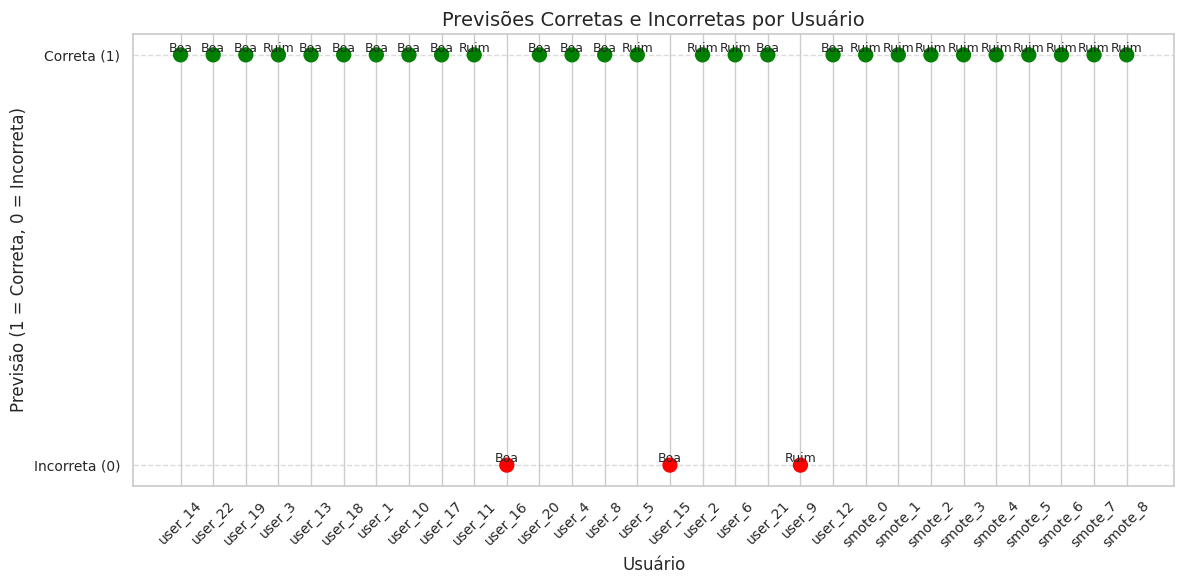

In [179]:
import matplotlib.pyplot as plt

# Prepara os dados
users = [result['User'] for result in results_smote]
correct = [1 if result['Accuracy'] == 1 else 0 for result in results_smote]  # 1 = correto, 0 = incorreto
true_values = [1 if result['Value_True'] == 1 else 0 for result in results_smote]  # 1 = correto, 0 = incorreto

# Define cores personalizadas (verde para acertos, vermelho para erros)
colors = ['green' if c == 1 else 'red' for c in correct]

# Plot
plt.figure(figsize=(12, 6))
scatter = plt.scatter(users, correct, c=colors, s=100)  # Usa as cores personalizadas

# Adiciona anotações para cada ponto
for i, user in enumerate(users):
    plt.text(user, correct[i], f'{"Boa" if true_values[i] == 1 else "Ruim"}',
             fontsize=9, ha='center', va='bottom')

# Personaliza o gráfico
plt.title('Previsões Corretas e Incorretas por Usuário', fontsize=14)
plt.xlabel('Usuário', fontsize=12)
plt.ylabel('Previsão (1 = Correta, 0 = Incorreta)', fontsize=12)
plt.yticks([0, 1], ['Incorreta (0)', 'Correta (1)'], fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.savefig('previsoes_SMOTE_plot_high_quality.png', dpi=400, bbox_inches='tight')  # Salva em PNG com DPI 400
plt.show()

#### # Matriz de Confusão Agregada

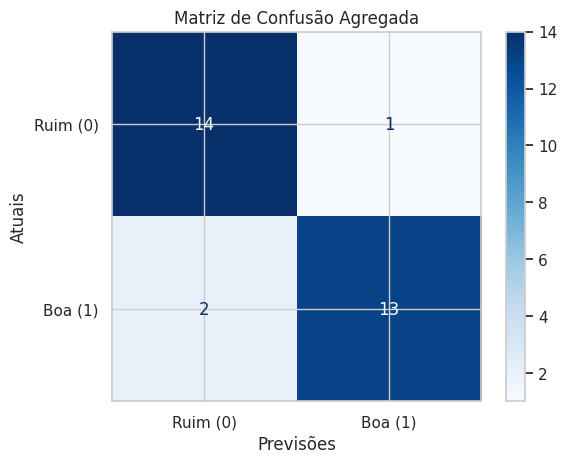

In [180]:
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Inicializa a matriz de confusão agregada com zeros
conf_matrix_aggregated = np.zeros((2, 2))  # Assume um problema de classificação binária

# Soma as matrizes de confusão de todos os usuários
for result in results_smote:
    # Obtém a matriz de confusão do usuário
    user_conf_matrix = result['Confusion Matrix']

    # Se a matriz for 1x1, expande para 2x2
    if user_conf_matrix.shape == (1, 1):
        expanded_conf_matrix = np.zeros((2, 2))
        if result['Value_True'] == 0:
            expanded_conf_matrix[0, 0] = user_conf_matrix[0, 0]  # Verdadeiros positivos para classe 0
        else:
            expanded_conf_matrix[1, 1] = user_conf_matrix[0, 0]  # Verdadeiros positivos para classe 1
    else:
        expanded_conf_matrix = user_conf_matrix

    # Soma à matriz agregada
    conf_matrix_aggregated += expanded_conf_matrix

# Define os rótulos das classes
class_names = ['Ruim (0)', 'Boa (1)']

# Plot da matriz de confusão agregada
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_aggregated, display_labels=class_names)
disp.plot(cmap='Blues')

# Altera os rótulos dos eixos
disp.ax_.set_xlabel('Previsões')  # Altera o rótulo do eixo X
disp.ax_.set_ylabel('Atuais')     # Altera o rótulo do eixo Y

plt.title('Matriz de Confusão Agregada')
plt.savefig('matriz_smote_high_quality.png', dpi=400, bbox_inches='tight')  # Salva em PNG com DPI 400
plt.show()

#### # Gráfico de Curva ROC

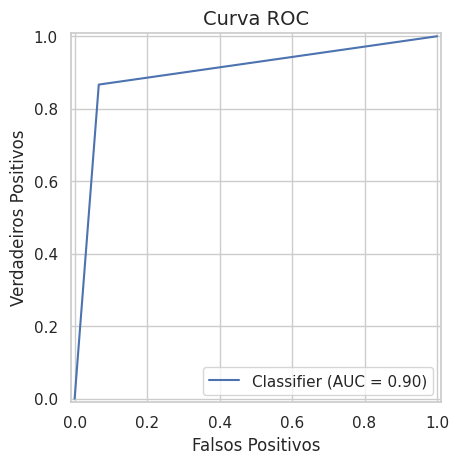

In [181]:
from sklearn.metrics import RocCurveDisplay
import numpy as np
import matplotlib.pyplot as plt

# Listas para armazenar rótulos reais e probabilidades previstas
y_true_list = []
y_probs_list = []

# Coleta os rótulos reais e as probabilidades previstas
for result in results_smote:
    user = result['User']
    # Pega as probabilidades previstas
    y_probs_list.append(result['Value_Pred'])  # Adiciona as probabilidades
    y_true_list.append(result['Value_True'])  # Adiciona os rótulos reais

# Converte para arrays numpy
y_true = np.array(y_true_list)
y_probs = np.array(y_probs_list)

# Plot da curva ROC
roc_display = RocCurveDisplay.from_predictions(y_true, y_probs)

# Altera os rótulos dos eixos para português
roc_display.ax_.set_xlabel('Falsos Positivos', fontsize=12)  # Altera o rótulo do eixo X
roc_display.ax_.set_ylabel('Verdadeiros Positivos', fontsize=12)  # Altera o rótulo do eixo Y

# Altera o título
plt.title('Curva ROC', fontsize=14)
plt.savefig('ROC_SMOTE_high_quality.png', dpi=400, bbox_inches='tight')  # Salva em PNG com DPI 400

plt.show()

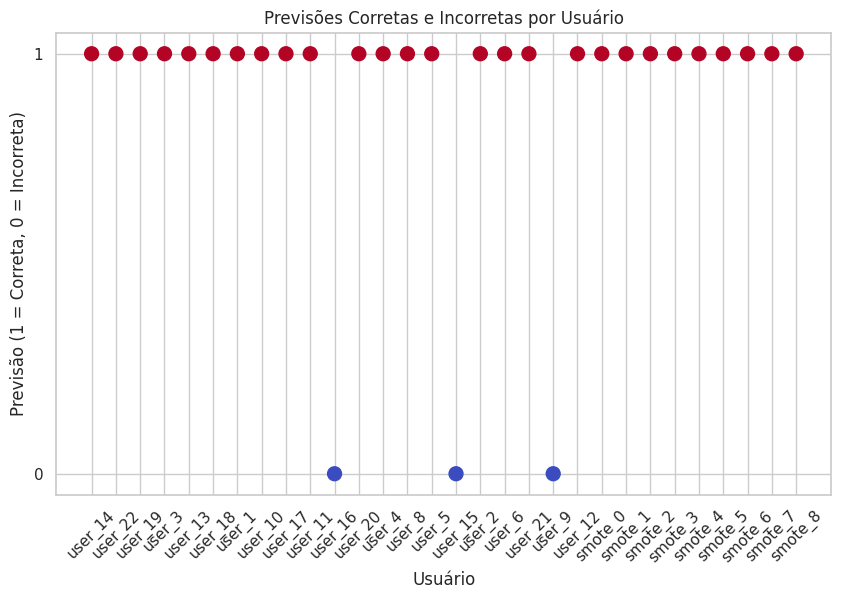

In [182]:
# Prepara os dados
users = [result['User'] for result in results_smote]
correct = [1 if result['Accuracy'] == 1 else 0 for result in results_smote]  # 1 = correto, 0 = incorreto

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(users, correct, c=correct, cmap='coolwarm', s=100)
plt.title('Previsões Corretas e Incorretas por Usuário')
plt.xlabel('Usuário')
plt.ylabel('Previsão (1 = Correta, 0 = Incorreta)')
plt.yticks([0, 1])
plt.xticks(rotation=45)
plt.savefig('previsoes_smote2_high_quality.png', dpi=400, bbox_inches='tight')  # Salva em PNG com DPI 400
plt.show()

## Classificadores


Treinando e avaliando o classificador: KNN


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py

KNN - Acurácia: 0.87, Precisão: 0.40, Recall: 0.40, F1-Score: 0.40

Treinando e avaliando o classificador: SVM


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: 

SVM - Acurácia: 0.90, Precisão: 0.43, Recall: 0.43, F1-Score: 0.43

Treinando e avaliando o classificador: Random Forest


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: 

Random Forest - Acurácia: 0.77, Precisão: 0.37, Recall: 0.37, F1-Score: 0.37

Treinando e avaliando o classificador: Logistic Regression


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

Logistic Regression - Acurácia: 0.60, Precisão: 0.30, Recall: 0.30, F1-Score: 0.30

Treinando e avaliando o classificador: Naive Bayes


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

Naive Bayes - Acurácia: 0.50, Precisão: 0.20, Recall: 0.20, F1-Score: 0.20

Treinando e avaliando o classificador: Neural Network


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr

Neural Network - Acurácia: 0.83, Precisão: 0.37, Recall: 0.37, F1-Score: 0.37

Resultados dos Classificadores:
            Classifier  Accuracy  Precision    Recall  F1-Score
0                  KNN  0.866667   0.400000  0.400000  0.400000
1                  SVM  0.900000   0.433333  0.433333  0.433333
2        Random Forest  0.766667   0.366667  0.366667  0.366667
3  Logistic Regression  0.600000   0.300000  0.300000  0.300000
4          Naive Bayes  0.500000   0.200000  0.200000  0.200000
5       Neural Network  0.833333   0.366667  0.366667  0.366667


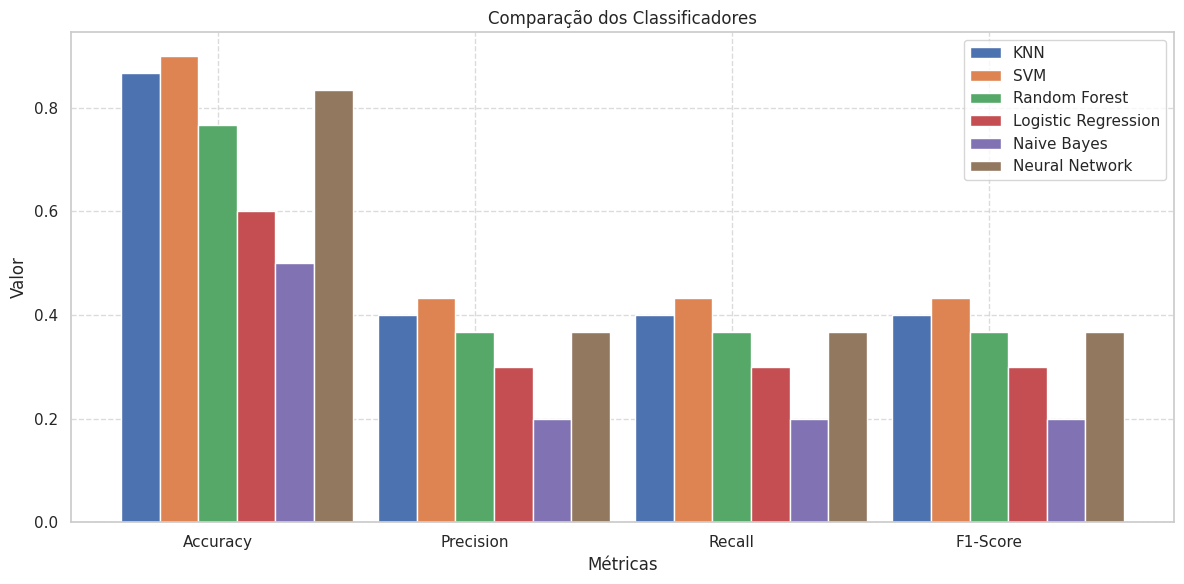

In [190]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Definindo os classificadores com os melhores hiperparâmetros
classifiers = {
    "KNN": KNeighborsClassifier(n_neighbors=3),  # KNN com 3 vizinhos
    "SVM": SVC(kernel='rbf', C=10.0, random_state=seed),  # SVM com kernel linear
    "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=None, random_state=seed),  # RF com 100 árvores
    "Logistic Regression": LogisticRegression(C=10.0, solver='liblinear', random_state=seed),  # Regressão Logística
    "Naive Bayes": GaussianNB(),  # Naive Bayes
    "Neural Network": MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=seed)  # Rede Neural
}

# Lista para armazenar os resultados de cada classificador
results_classifiers = []

# Loop para treinar e avaliar cada classificador
for name, clf in classifiers.items():
    print(f"\nTreinando e avaliando o classificador: {name}")

    # Listas para armazenar métricas de cada fold
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    # Validação Leave-One-Subject-Out (LOSO)
    for user in df_smote['user'].unique():
        # Separa dados de treino e teste
        X_train = df_smote[df_smote['user'] != user][cols[:-1]].values
        y_train = df_smote[df_smote['user'] != user][cols[-1]].values
        X_test = df_smote[df_smote['user'] == user][cols[:-1]].values
        y_test = df_smote[df_smote['user'] == user][cols[-1]].values

        # Treina o classificador
        clf.fit(X_train, y_train)

        # Faz previsões
        y_pred = clf.predict(X_test)

        # Calcula métricas
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Armazena métricas
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    # Calcula métricas médias
    mean_accuracy = np.mean(accuracies)
    mean_precision = np.mean(precisions)
    mean_recall = np.mean(recalls)
    mean_f1 = np.mean(f1_scores)

    # Armazena resultados do classificador
    results_classifiers.append({
        'Classifier': name,
        'Accuracy': mean_accuracy,
        'Precision': mean_precision,
        'Recall': mean_recall,
        'F1-Score': mean_f1
    })

    # Exibe métricas
    print(f"{name} - Acurácia: {mean_accuracy:.2f}, Precisão: {mean_precision:.2f}, "
          f"Recall: {mean_recall:.2f}, F1-Score: {mean_f1:.2f}")

# Converte resultados para DataFrame
results_classifiers_df = pd.DataFrame(results_classifiers)

# Exibe resultados
print("\nResultados dos Classificadores:")
print(results_classifiers_df)

# Salva resultados em CSV
results_classifiers_df.to_csv('resultados_classificadores.csv', index=False)

# Plot das métricas dos classificadores
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))
width = 0.15

plt.figure(figsize=(12, 6))
for i, classifier in enumerate(results_classifiers_df['Classifier']):
    plt.bar(x + i * width, results_classifiers_df.loc[i, metrics], width, label=classifier)

plt.xlabel('Métricas')
plt.ylabel('Valor')
plt.title('Comparação dos Classificadores')
plt.xticks(x + width * 2, metrics)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('comparacao_classificadores.png', dpi=400, bbox_inches='tight')  # Salva em PNG
plt.show()

NameError: name 'df_smote' is not defined

<Figure size 6000x4800 with 0 Axes>

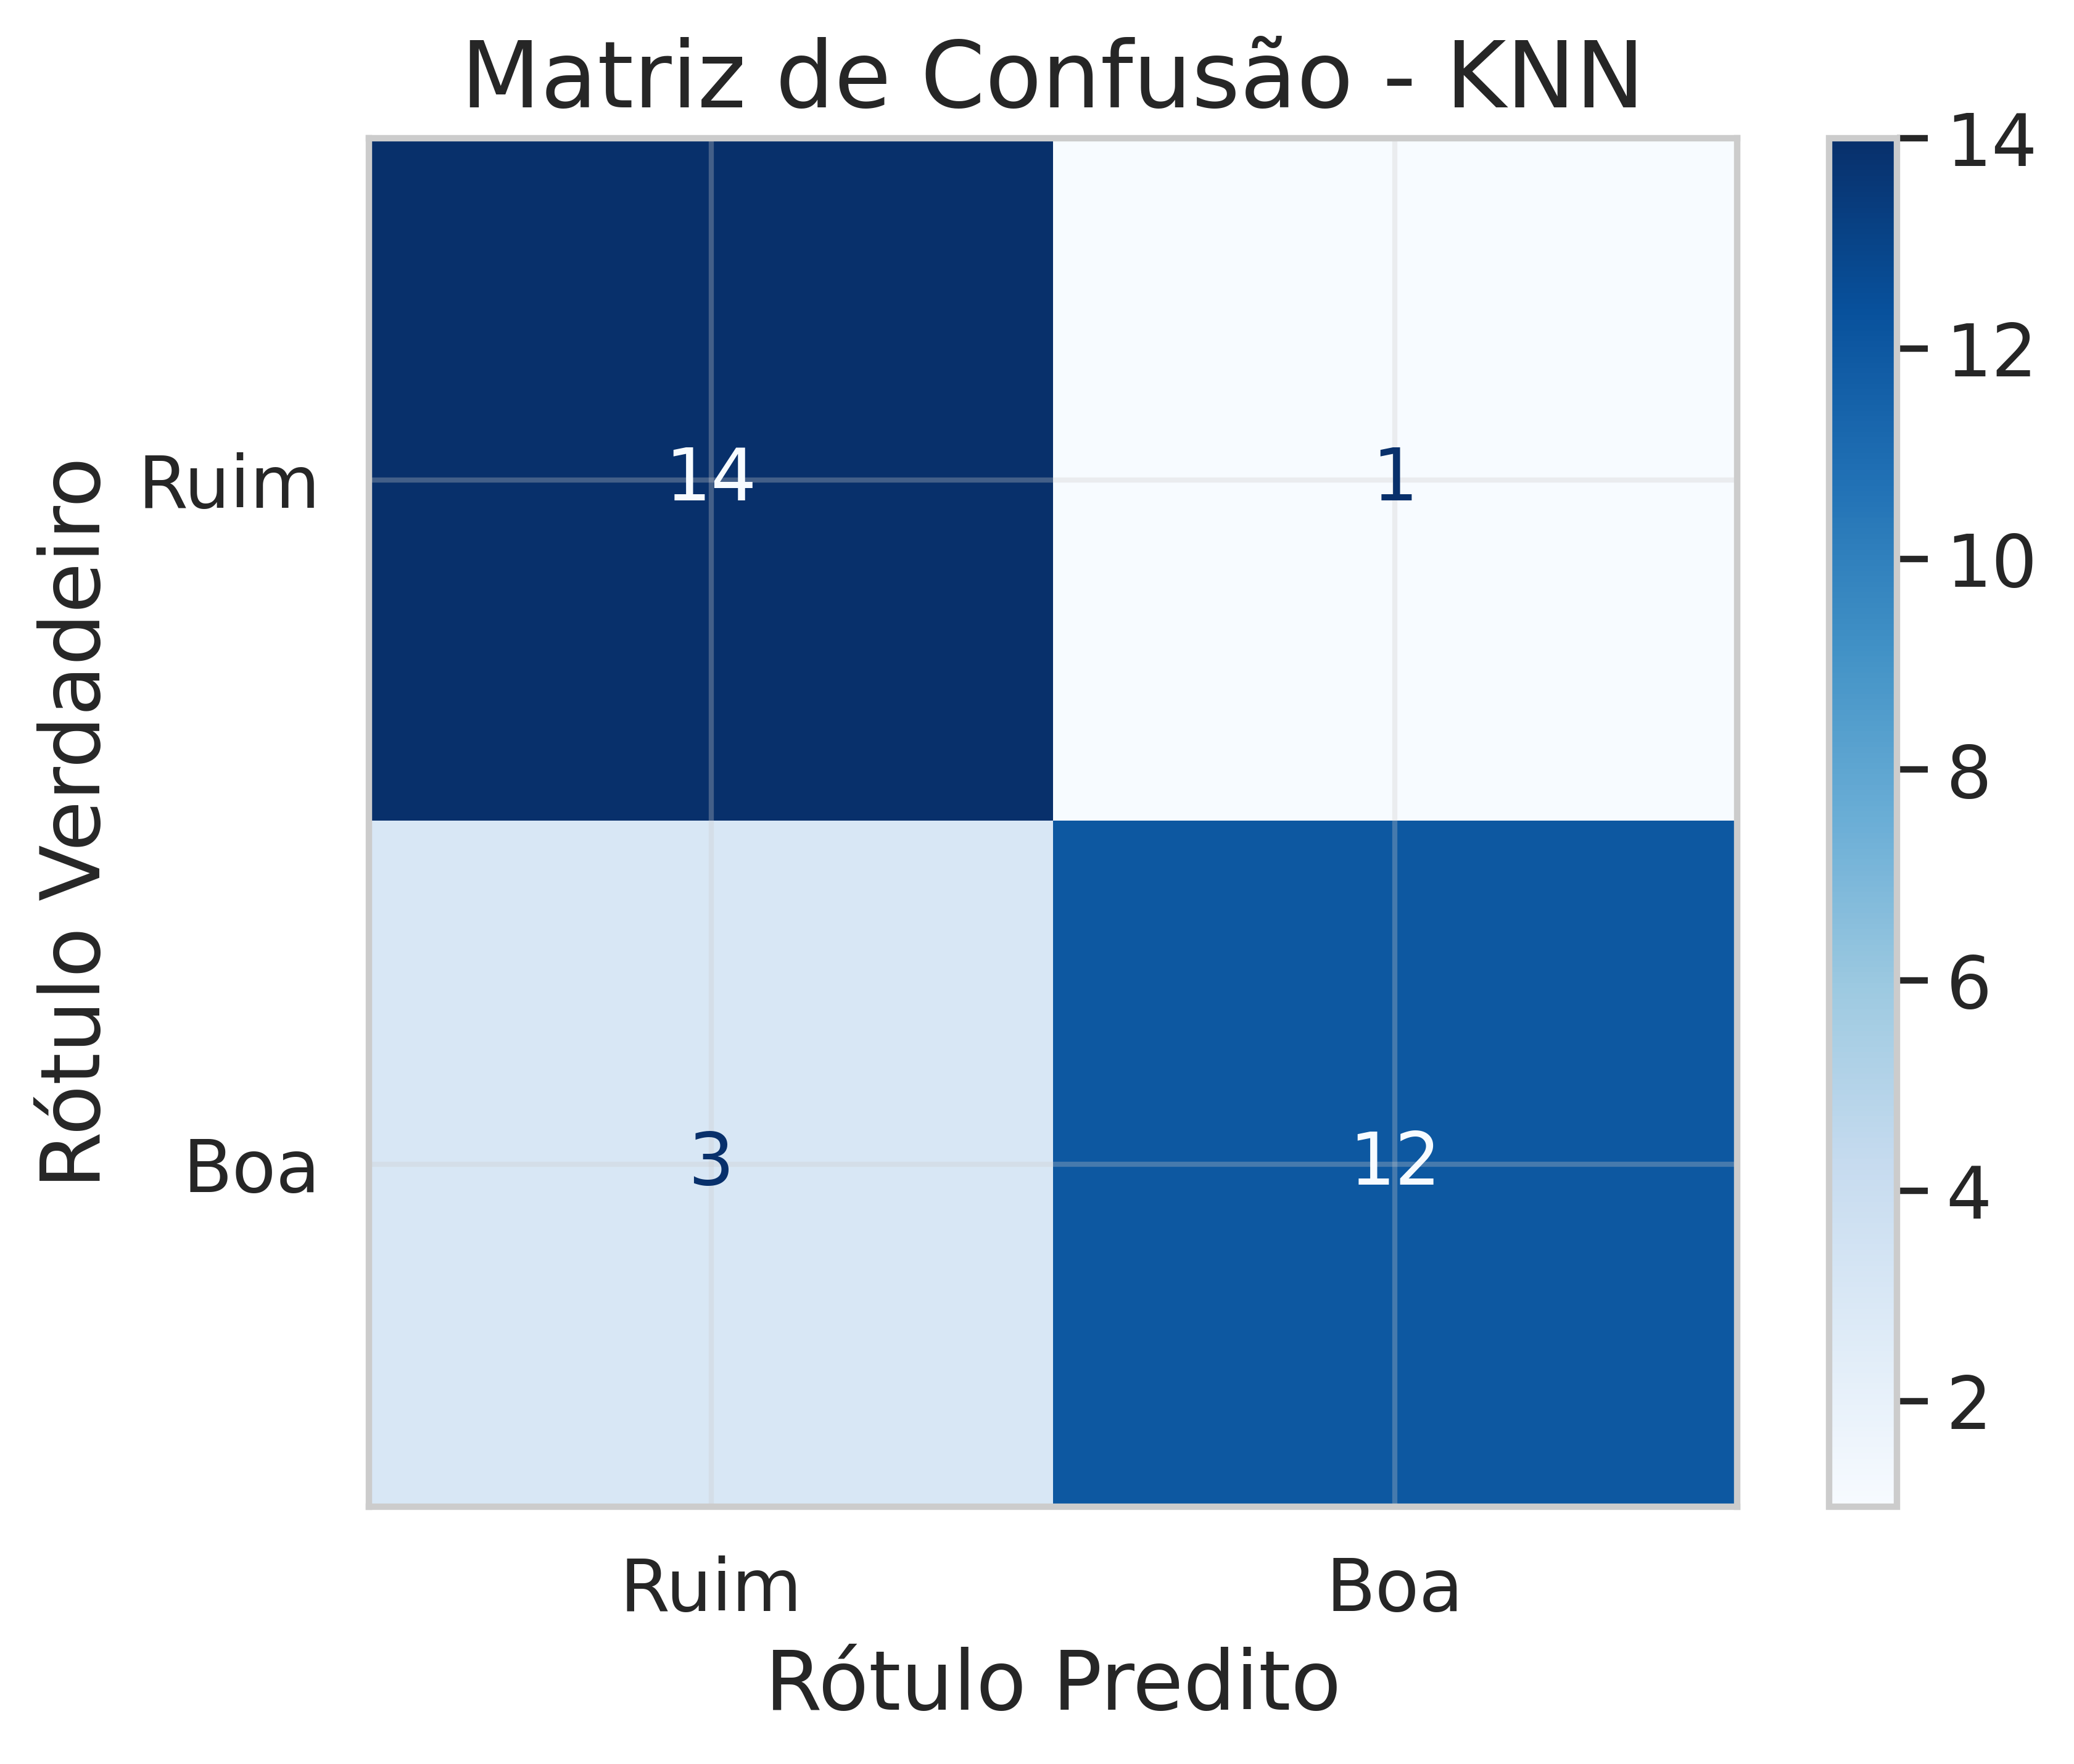

<Figure size 6000x4800 with 0 Axes>

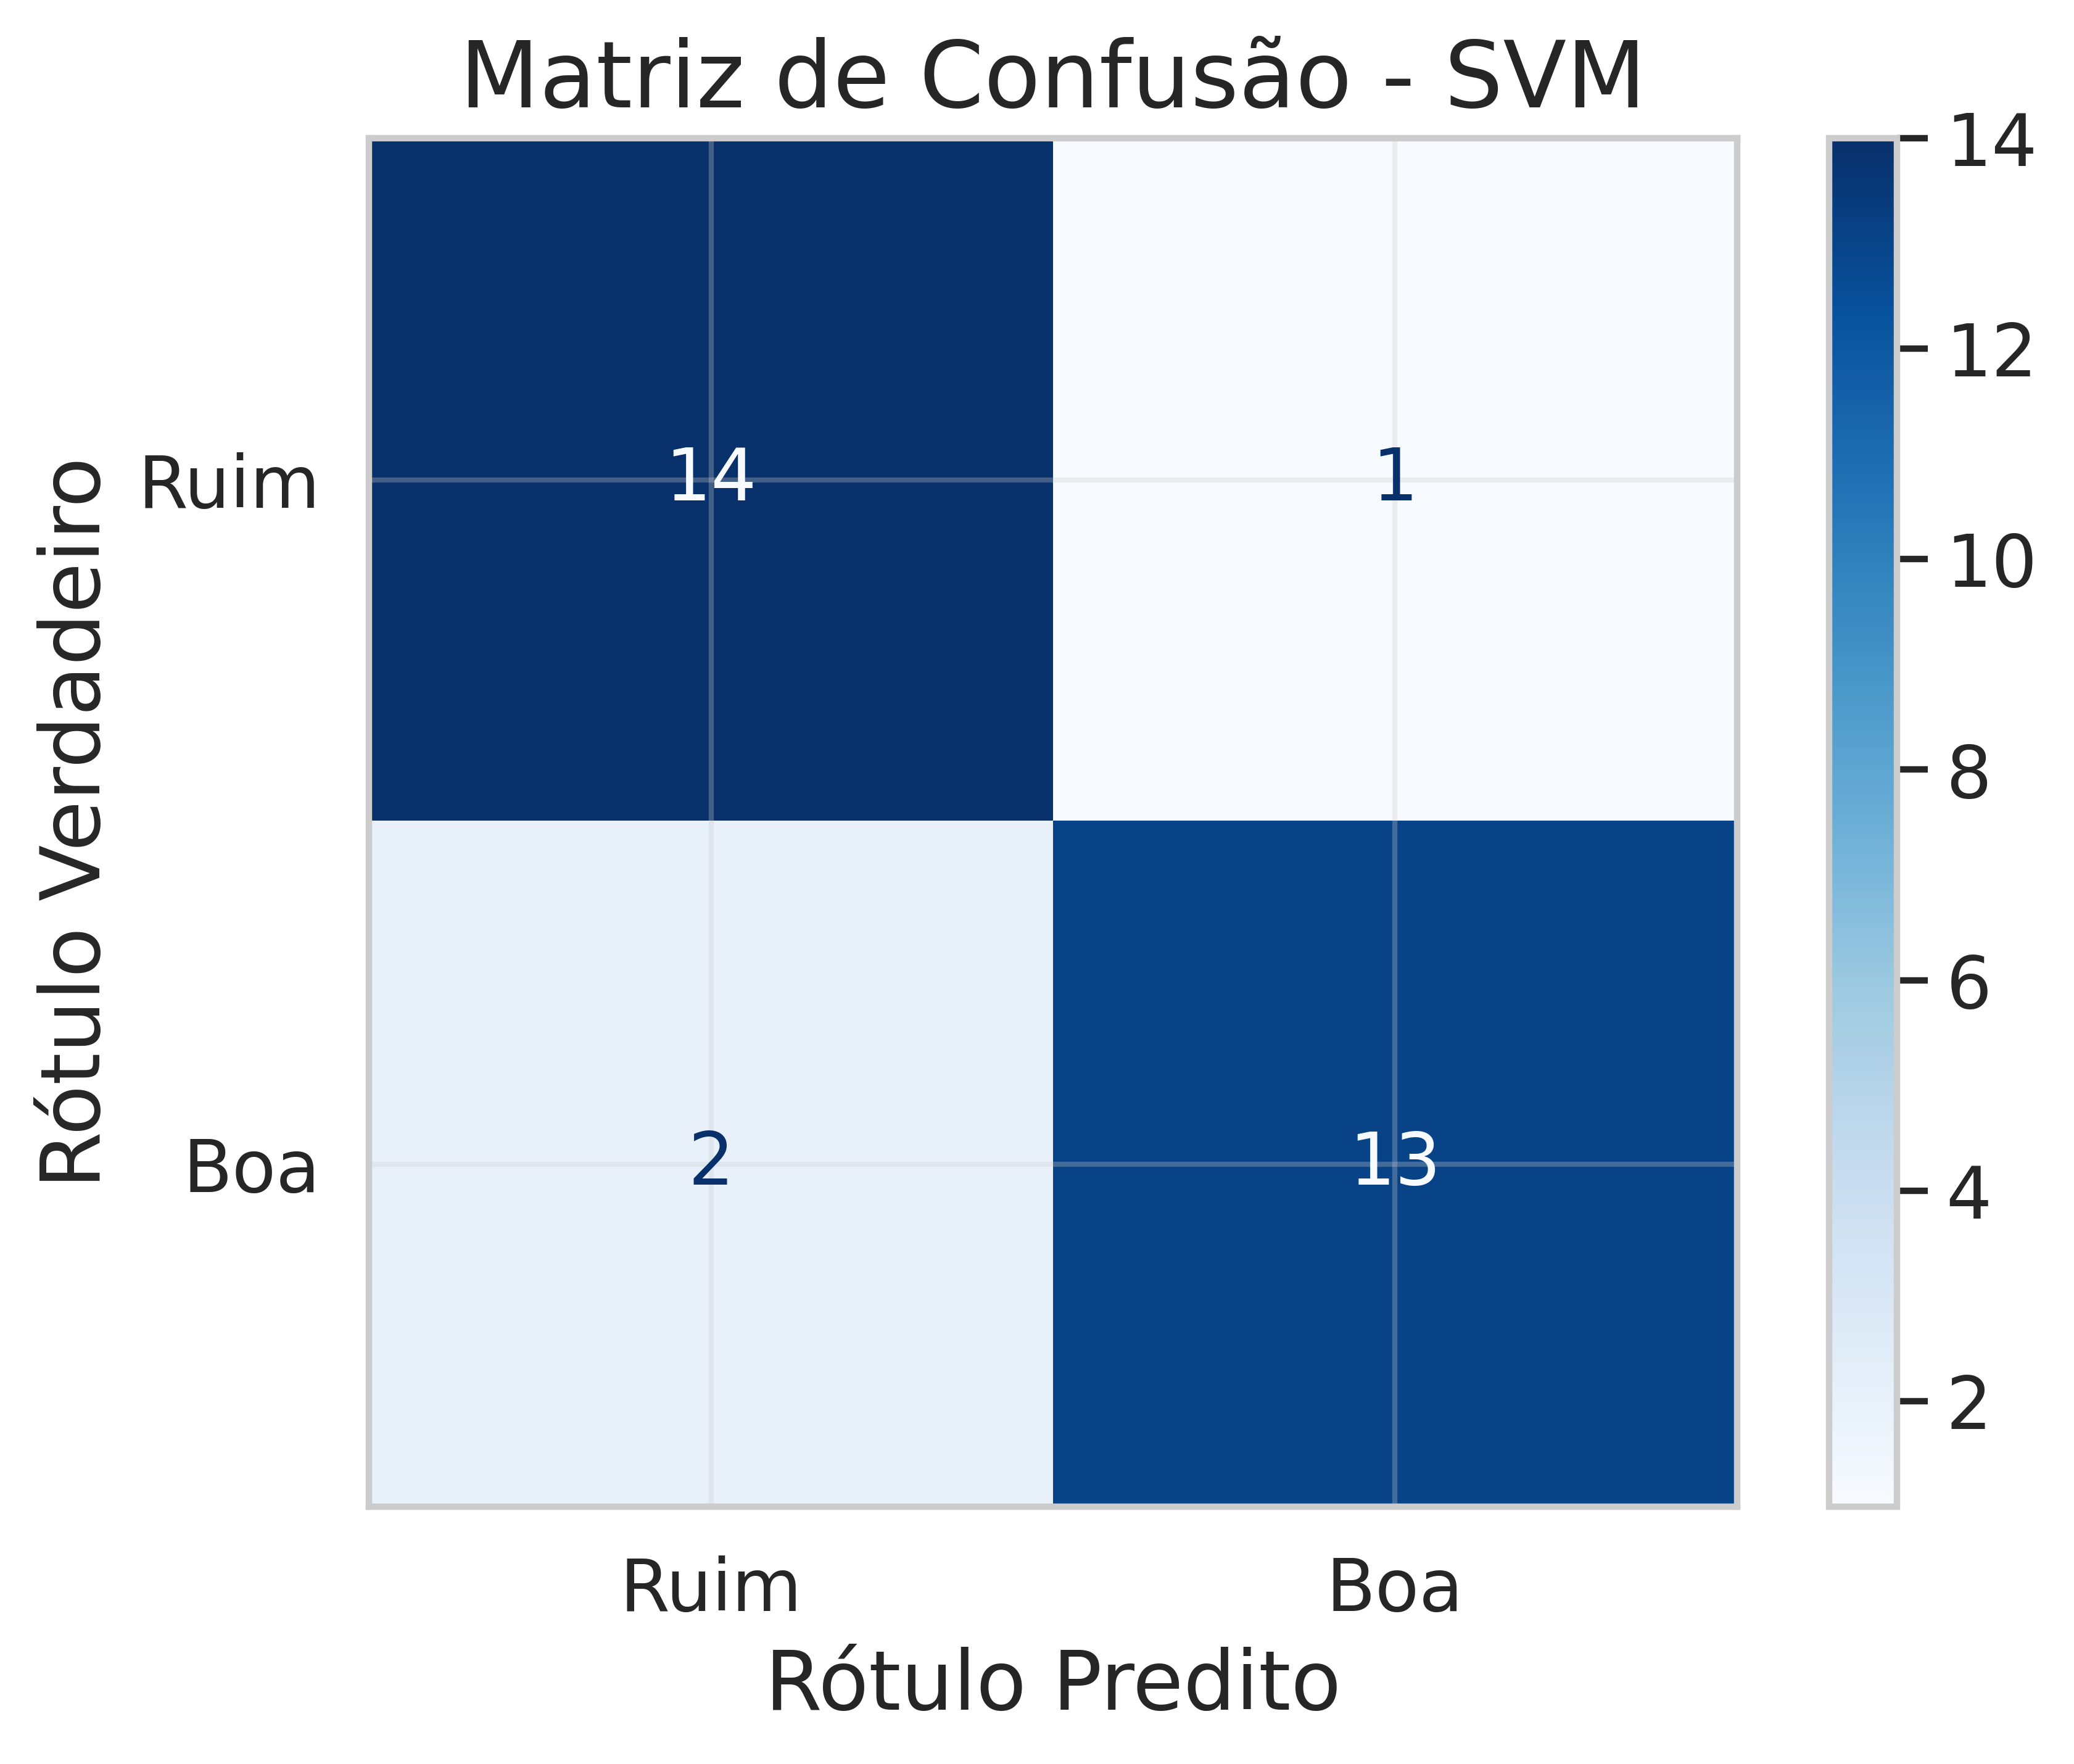

<Figure size 6000x4800 with 0 Axes>

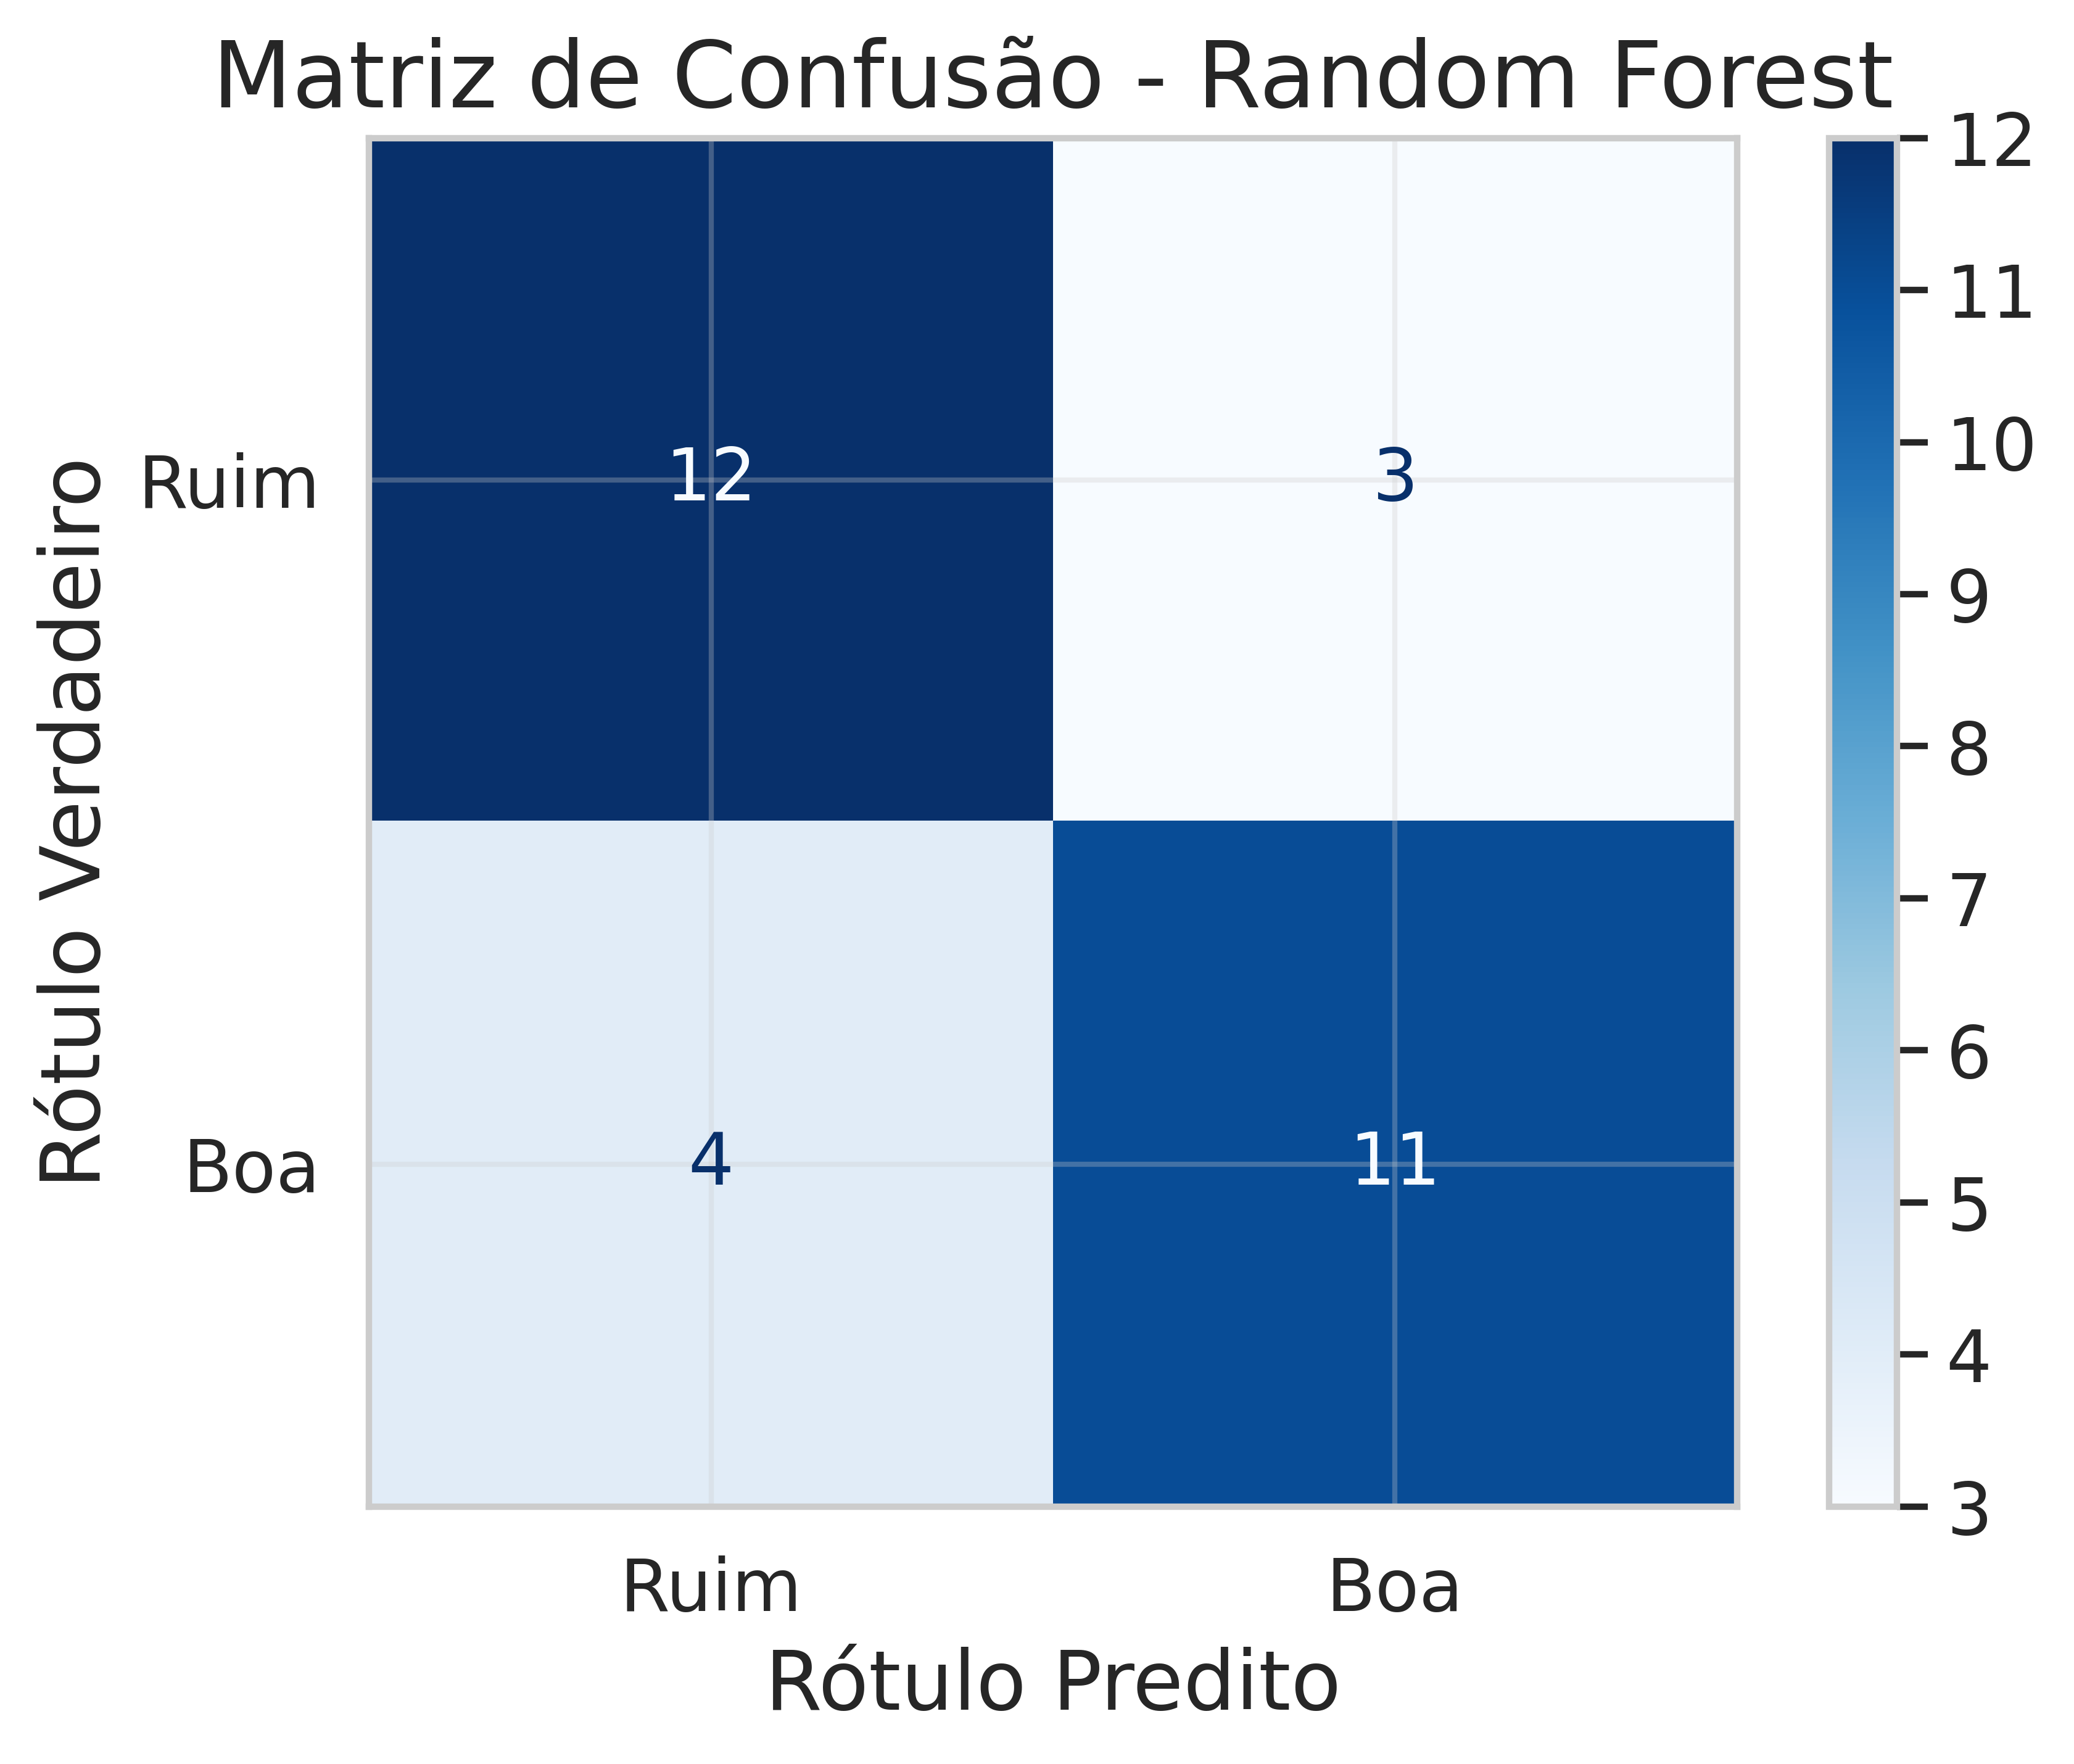

<Figure size 6000x4800 with 0 Axes>

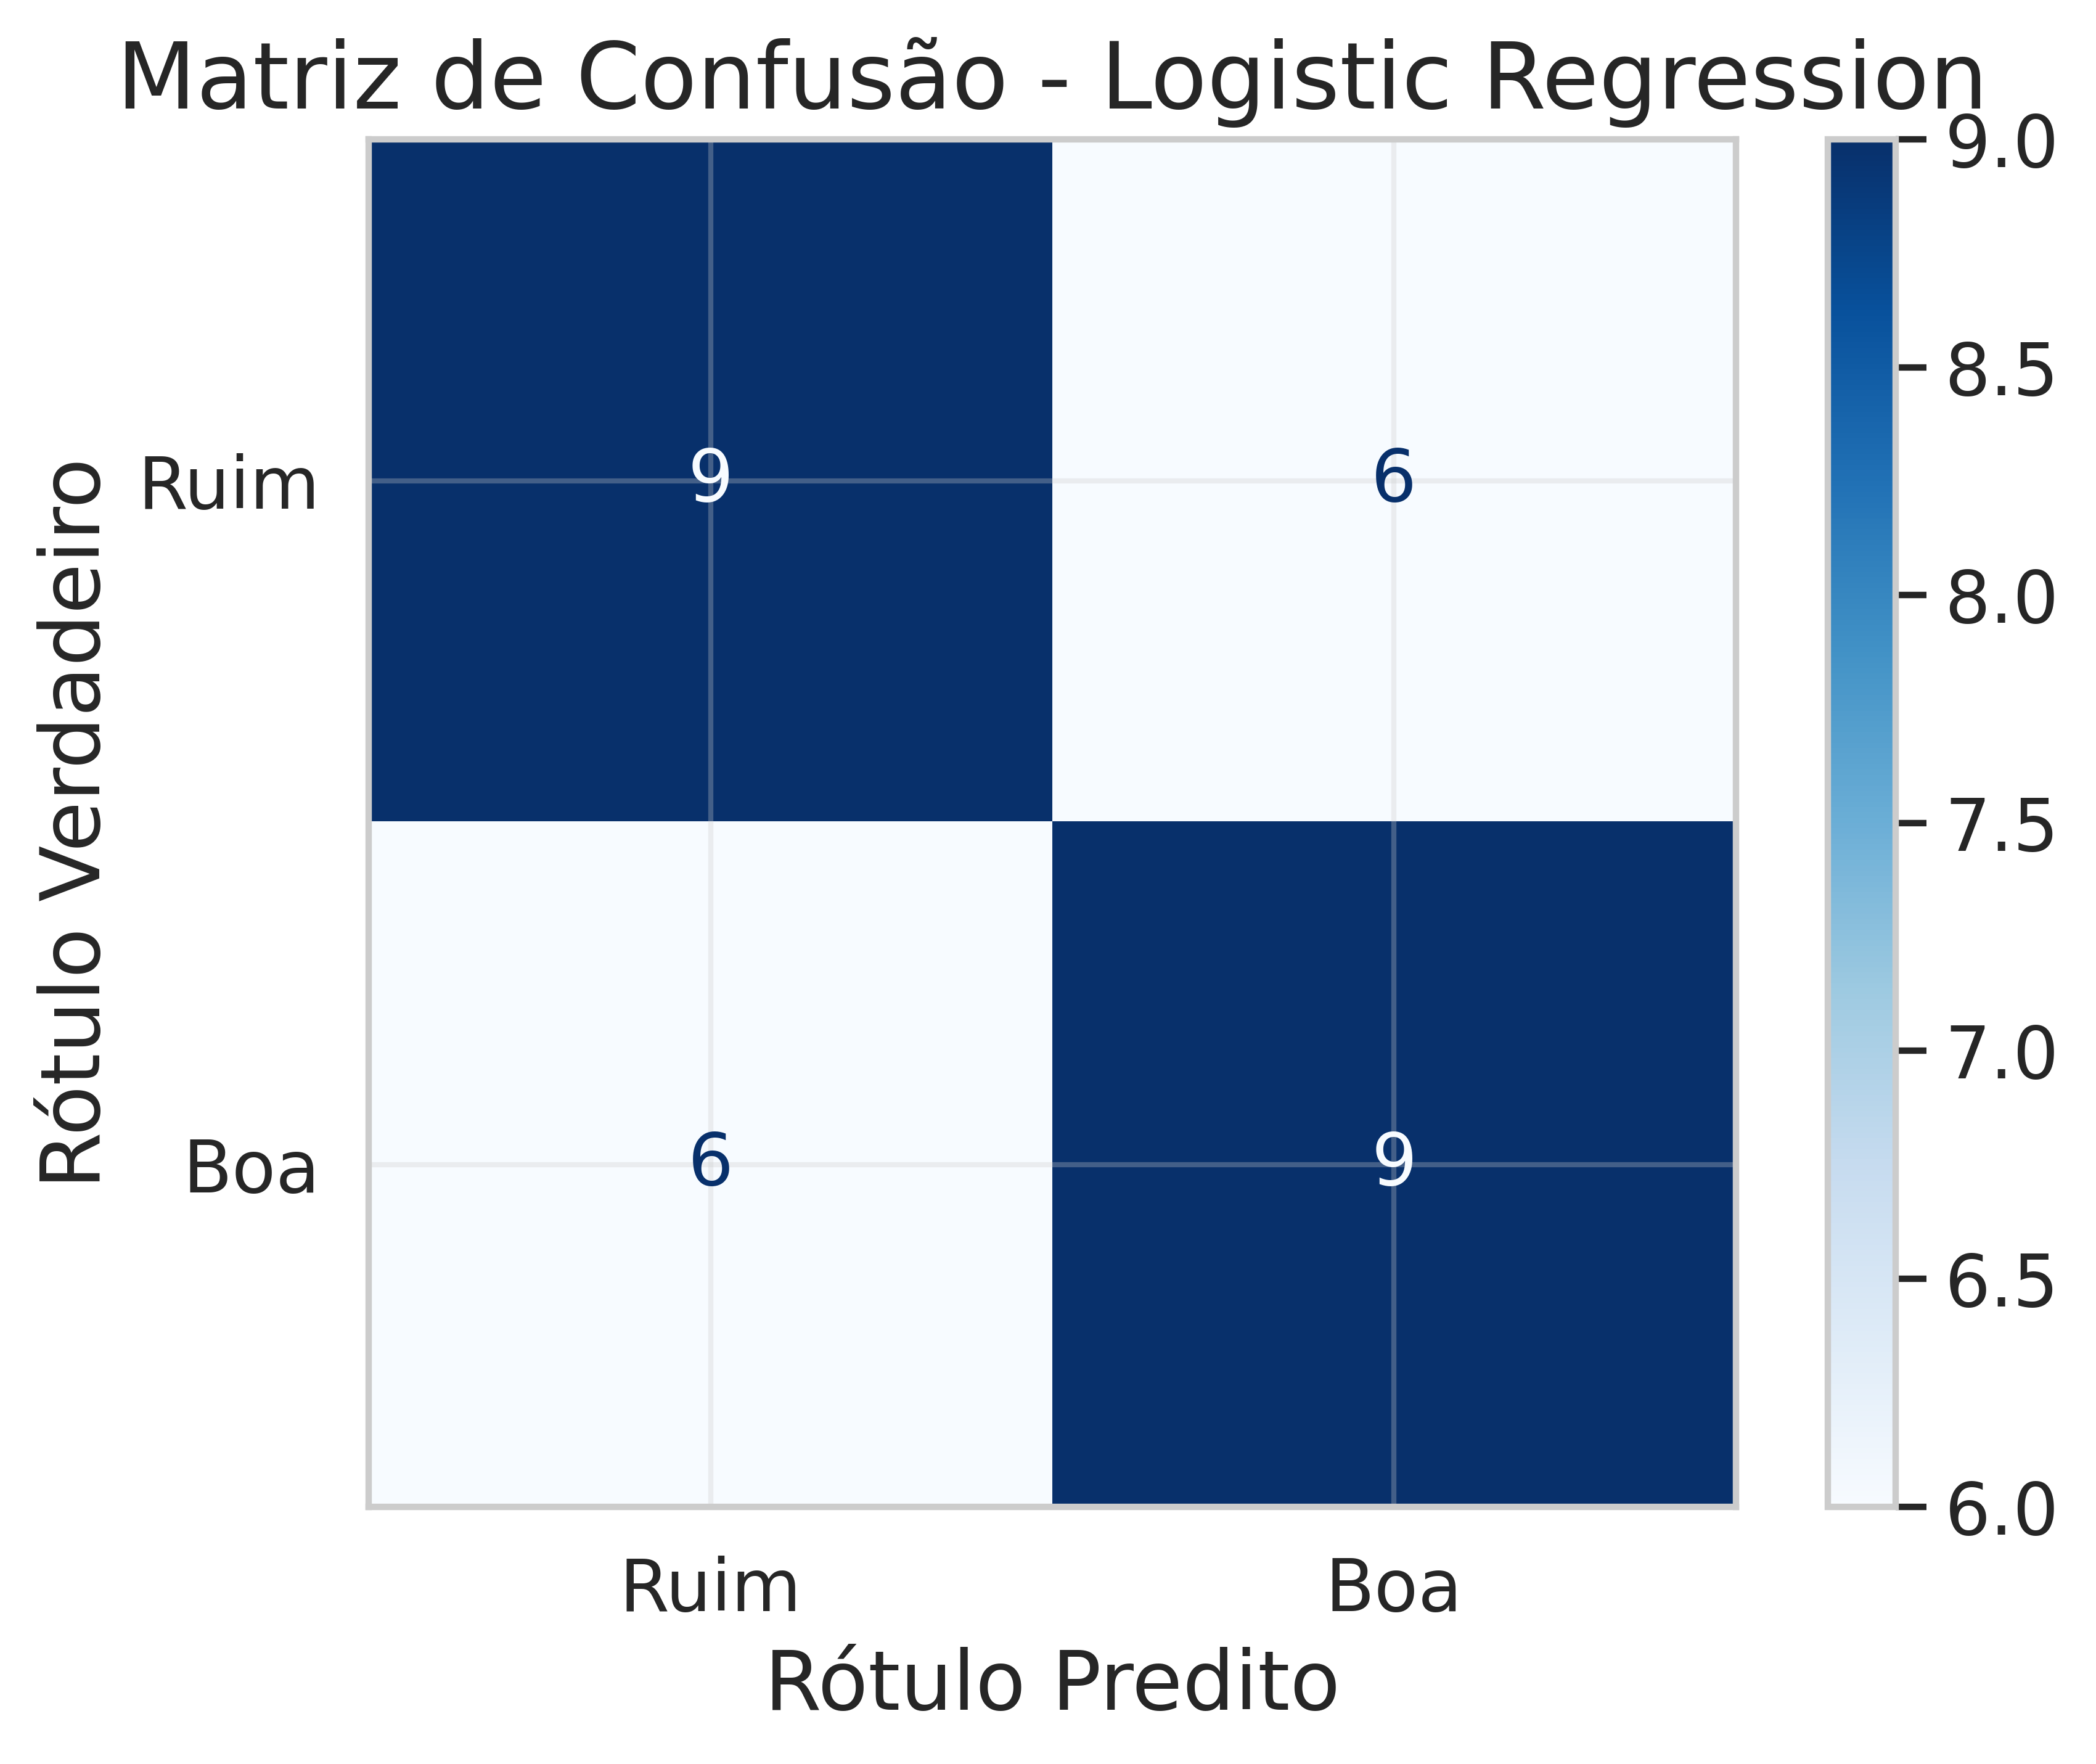

<Figure size 6000x4800 with 0 Axes>

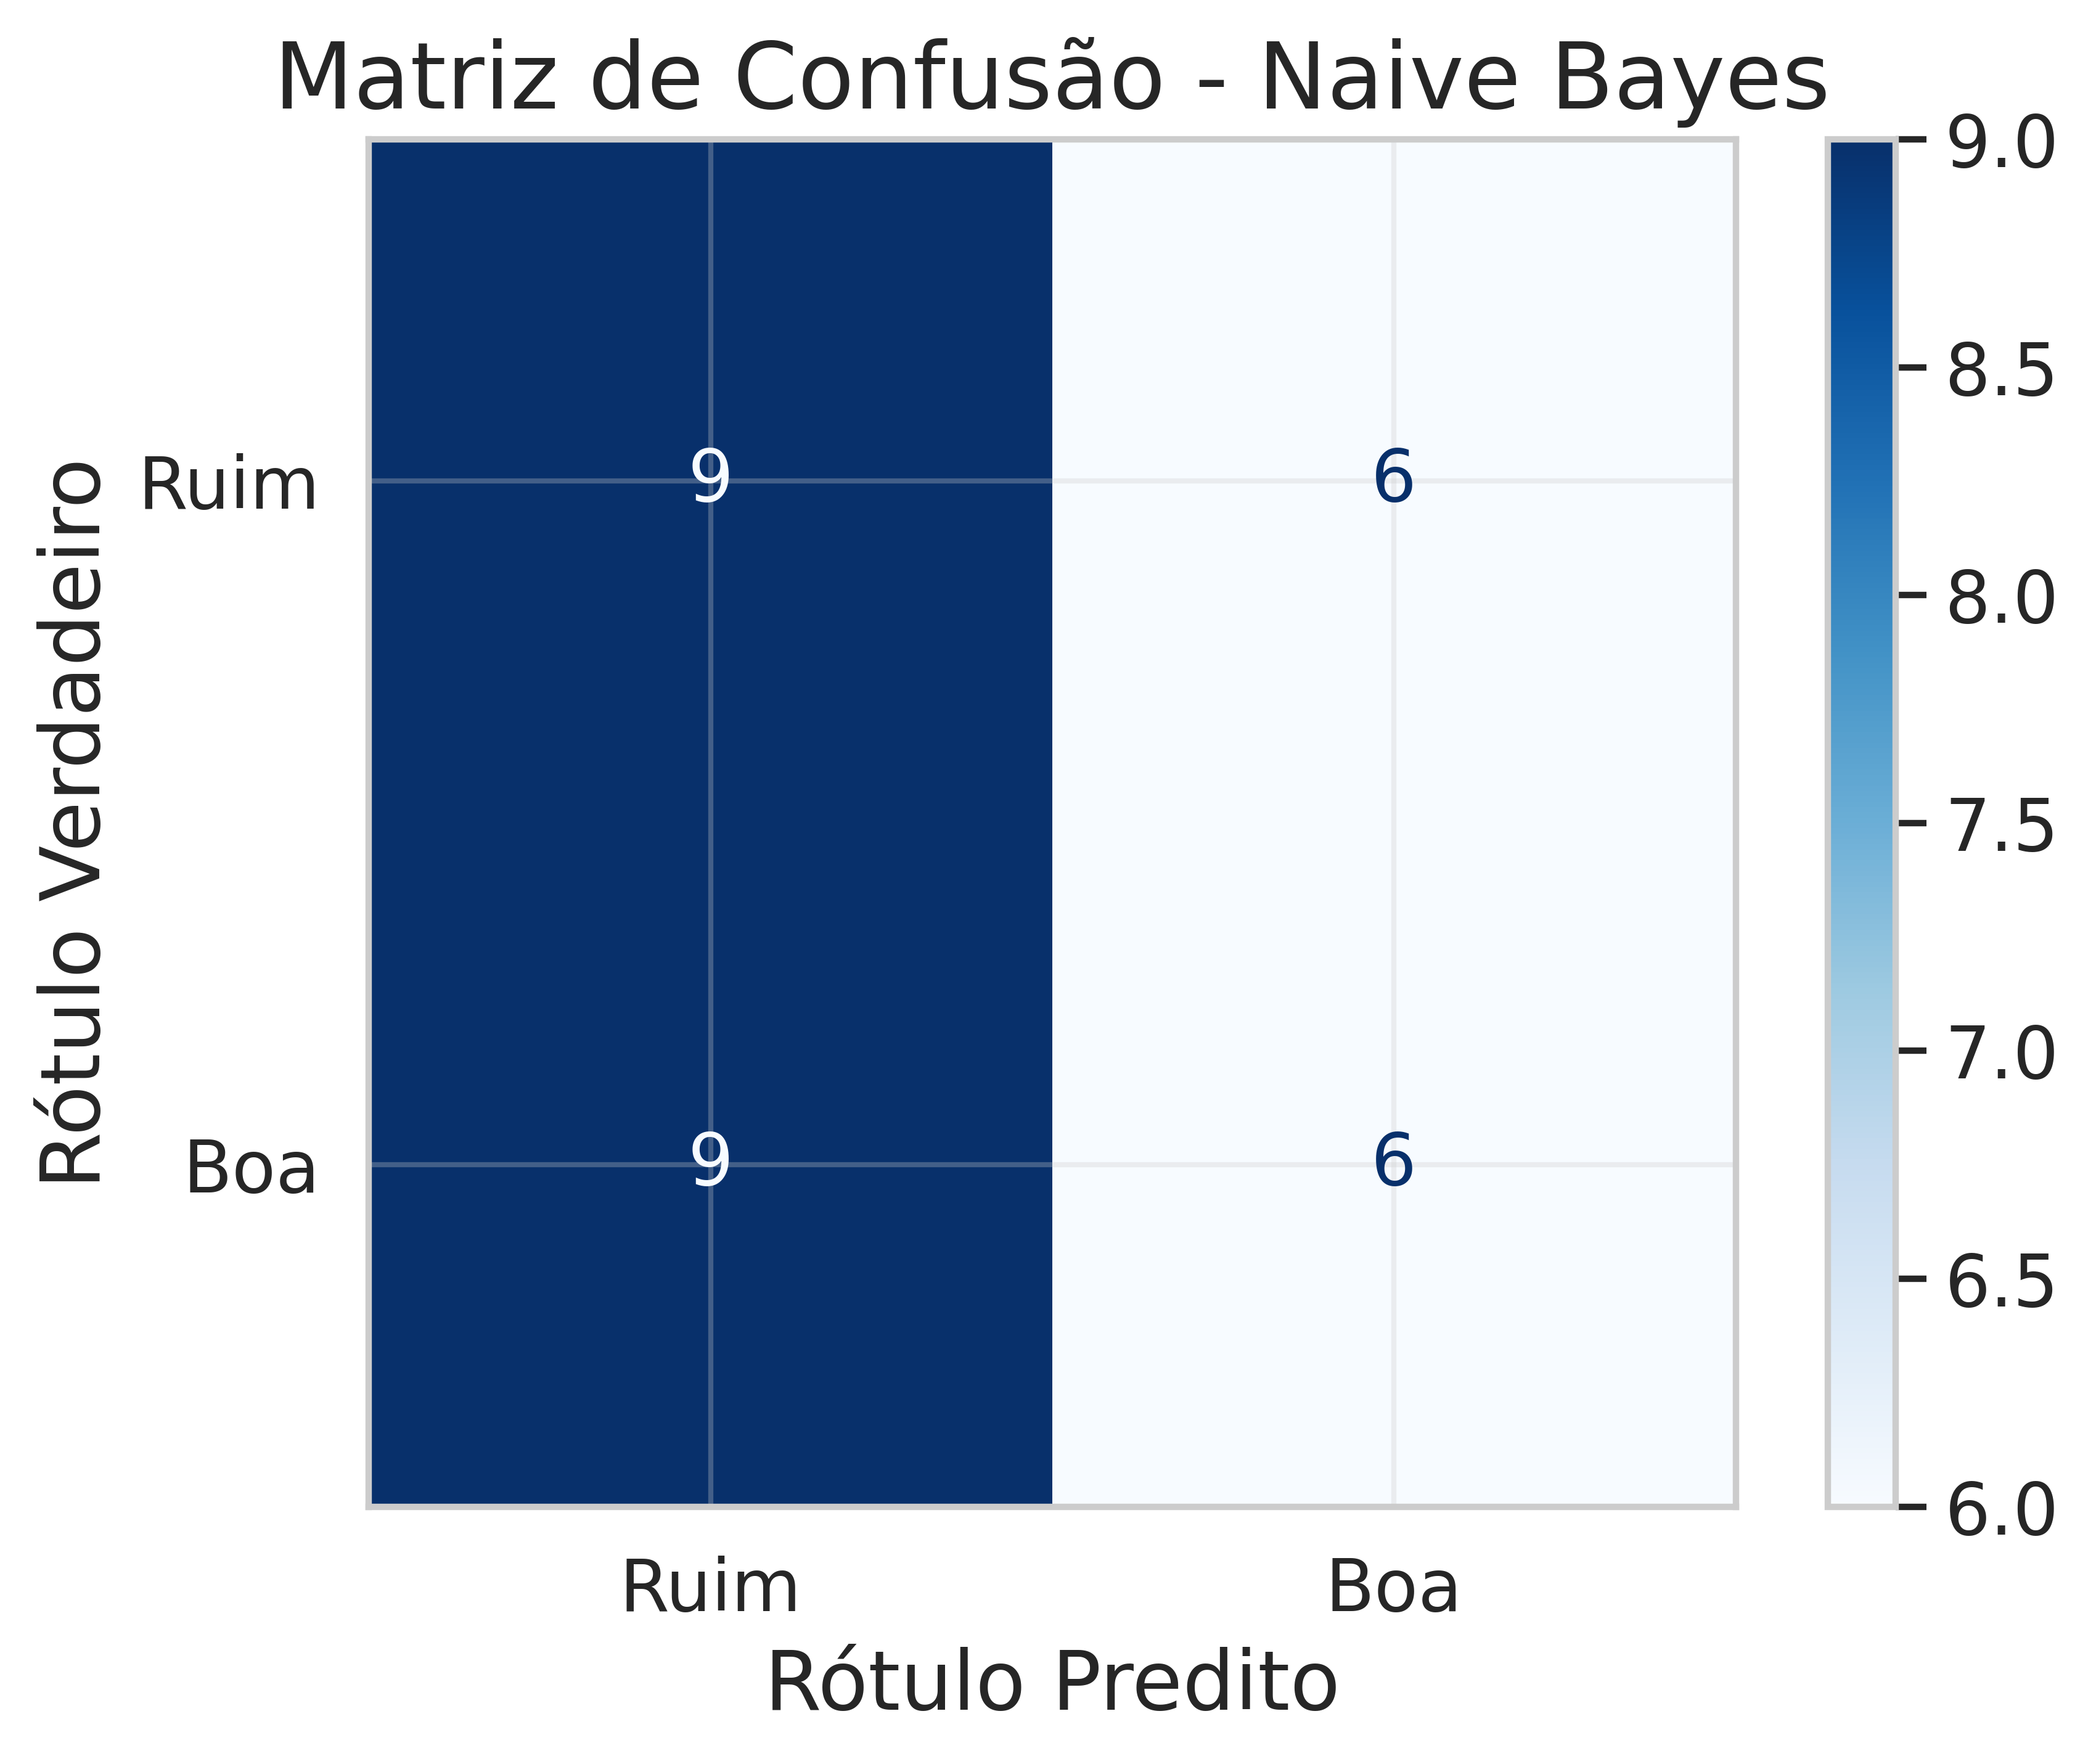

<Figure size 6000x4800 with 0 Axes>

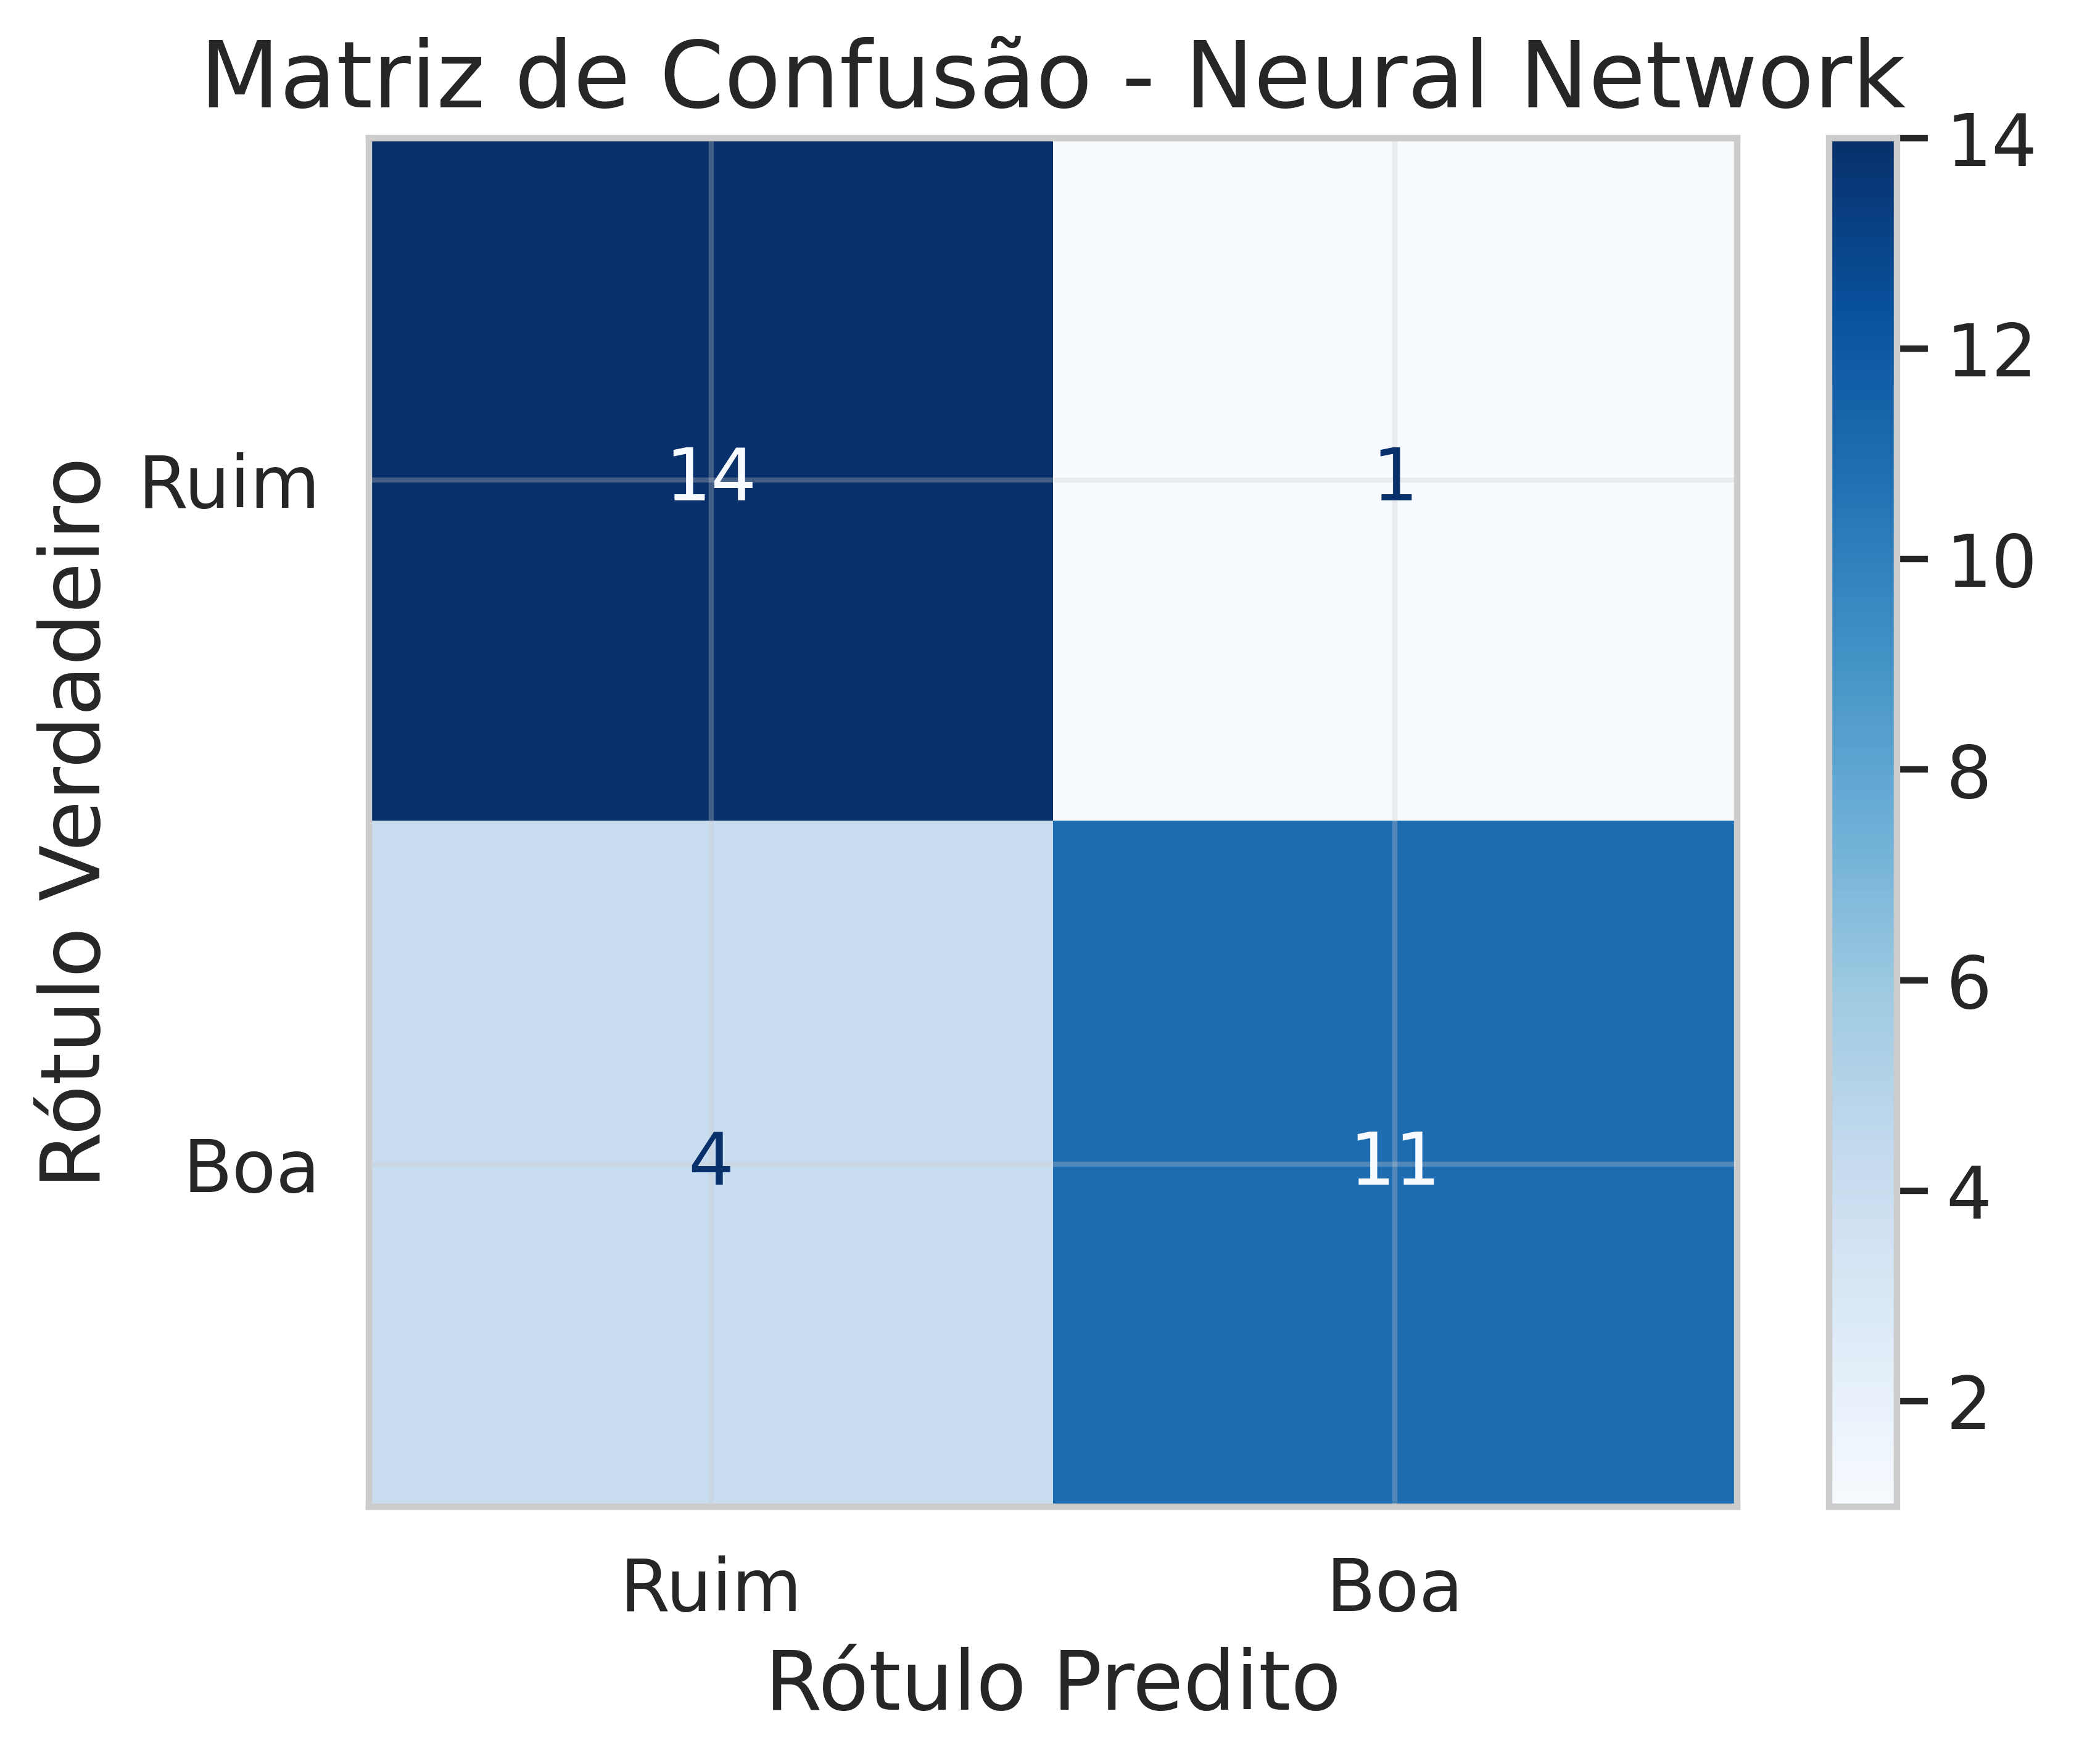

In [209]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Configura o estilo dos gráficos
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.dpi'] = 600  # Aumenta a resolução padrão das figuras
plt.rcParams['savefig.dpi'] = 600  # Aumenta a resolução ao salvar as figuras
plt.rcParams['lines.linewidth'] = 2  # Espessura das linhas
plt.rcParams['axes.grid'] = True  # Habilita grid
plt.rcParams['grid.alpha'] = 0.3  # Transparência do grid

# Define uma paleta de cores moderna (viridis)
colors = sns.color_palette("viridis", n_colors=len(results_classifiers_df))

# Plot das métricas dos classificadores
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.15

plt.figure(figsize=(18, 10))  # Aumentei o tamanho da figura
for i, classifier in enumerate(results_classifiers_df['Classifier']):
    bars = plt.bar(
        x + i * width,
        results_classifiers_df.loc[i, metrics],
        width,
        label=classifier,
        edgecolor='black',
        linewidth=0.5,
        color=colors[i]  # Aplica a cor da paleta
    )

    # Adiciona os valores das métricas nas barras
    for bar, value in zip(bars, results_classifiers_df.loc[i, metrics]):
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # Posição X do texto (centro da barra)
            height + 0.01,  # Posição Y do texto (ligeiramente acima da barra)
            f'{value:.2f}',  # Formata o valor com 2 casas decimais
            ha='center',  # Alinhamento horizontal centralizado
            va='bottom',  # Alinhamento vertical na base
            fontsize=12  # Tamanho da fonte
        )

plt.xlabel('Métricas', fontsize=16)
plt.ylabel('Valor', fontsize=16)
plt.title('Comparação dos Classificadores', fontsize=18)
plt.xticks(x + width * 2, metrics, fontsize=14)
plt.legend(fontsize=14, bbox_to_anchor=(1.05, 1), loc='upper left')  # Legenda fora do gráfico
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('comparacao_classificadores.png', dpi=600, bbox_inches='tight')  # Salva em alta resolução
plt.show()

# Exibir matrizes de confusão
for conf_matrix in conf_matrices:
    plt.figure(figsize=(10, 8))  # Aumentei o tamanho da figura
    ConfusionMatrixDisplay(conf_matrix['Confusion Matrix'], display_labels=['Ruim', 'Boa']).plot(cmap='Blues', values_format='d')
    plt.title(f"Matriz de Confusão - {conf_matrix['Classifier']}", fontsize=18)
    plt.xlabel('Rótulo Predito', fontsize=16)
    plt.ylabel('Rótulo Verdadeiro', fontsize=16)
    plt.savefig(f"matriz_confusao_{conf_matrix['Classifier']}.png", dpi=600, bbox_inches='tight')  # Salva em alta resolução
    plt.show()

In [213]:
# Função para plotar e salvar cada curva ROC separadamente em PNG
def plot_roc_curve(y_true, y_score, classifier_name, output_path):
    plt.figure(figsize=(8, 6))  # Tamanho da figura
    RocCurveDisplay.from_predictions(y_true, y_score, name=classifier_name, linewidth=2)

    # Configurações do gráfico
    plt.xlabel("Taxa de Falsos Positivos", fontsize=12)
    plt.ylabel("Taxa de Verdadeiros Positivos", fontsize=12)
    plt.title(f"Curva ROC - {classifier_name}", fontsize=14)  # Título no início
    plt.legend(fontsize=10, loc='lower right')  # Legenda dentro do gráfico
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()  # Ajusta o layout para evitar cortes
    plt.savefig(output_path, dpi=300, bbox_inches='tight', format='png')  # Salva em PNG
    plt.close()  # Fecha a figura para liberar memória

# Loop para gerar e salvar as curvas ROC de cada classificador
for name, clf in classifiers.items():
    y_true_all = []
    y_score_all = []

    # Validação Leave-One-Subject-Out (LOSO)
    for user in df_smote['user'].unique():
        X_train = df_smote[df_smote['user'] != user][cols[:-1]].values
        y_train = df_smote[df_smote['user'] != user][cols[-1]].values
        X_test = df_smote[df_smote['user'] == user][cols[:-1]].values
        y_test = df_smote[df_smote['user'] == user][cols[-1]].values

        clf.fit(X_train, y_train)
        y_score = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else clf.decision_function(X_test)

        y_true_all.extend(y_test)
        y_score_all.extend(y_score)

    # Gera e salva a curva ROC para o classificador atual
    output_path = f"curva_roc_{name.lower().replace(' ', '_')}.png"  # Nome do arquivo
    plot_roc_curve(y_true_all, y_score_all, name, output_path)
    print(f"Curva ROC salva em: {output_path}")

Curva ROC salva em: curva_roc_knn.png
Curva ROC salva em: curva_roc_svm.png
Curva ROC salva em: curva_roc_random_forest.png
Curva ROC salva em: curva_roc_logistic_regression.png
Curva ROC salva em: curva_roc_naive_bayes.png


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Curva ROC salva em: curva_roc_neural_network.png


<Figure size 4800x3600 with 0 Axes>

<Figure size 4800x3600 with 0 Axes>

<Figure size 4800x3600 with 0 Axes>

<Figure size 4800x3600 with 0 Axes>

<Figure size 4800x3600 with 0 Axes>

<Figure size 4800x3600 with 0 Axes>


Avaliando o classificador: KNN
  K-Fold com 3 folds...
  K-Fold com 5 folds...
  K-Fold com 8 folds...

Avaliando o classificador: SVM
  K-Fold com 3 folds...
  K-Fold com 5 folds...
  K-Fold com 8 folds...

Avaliando o classificador: Random Forest
  K-Fold com 3 folds...
  K-Fold com 5 folds...
  K-Fold com 8 folds...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Avaliando o classificador: Logistic Regression
  K-Fold com 3 folds...
  K-Fold com 5 folds...
  K-Fold com 8 folds...

Avaliando o classificador: Naive Bayes
  K-Fold com 3 folds...
  K-Fold com 5 folds...
  K-Fold com 8 folds...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Avaliando o classificador: Neural Network
  K-Fold com 3 folds...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


  K-Fold com 5 folds...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

  K-Fold com 8 folds...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro


Resultados dos Classificadores com K-Fold Cross-Validation:
            Classifier  Accuracy_3_folds  Precision_3_folds  Recall_3_folds  \
0                  KNN          0.619048           0.682540        0.866667   
1                  SVM          0.714286           0.714286        1.000000   
2        Random Forest          0.619048           0.682540        0.866667   
3  Logistic Regression          0.666667           0.698413        0.933333   
4          Naive Bayes          0.476190           0.750000        0.466667   
5       Neural Network          0.523810           0.626984        0.733333   

   F1-Score_3_folds  Accuracy_5_folds  Precision_5_folds  Recall_5_folds  \
0          0.762626              0.42           0.533333        0.550000   
1          0.833333              0.66           0.693333        0.933333   
2          0.762626              0.57           0.666667        0.816667   
3          0.797980              0.53           0.650000        0.766667   
4    

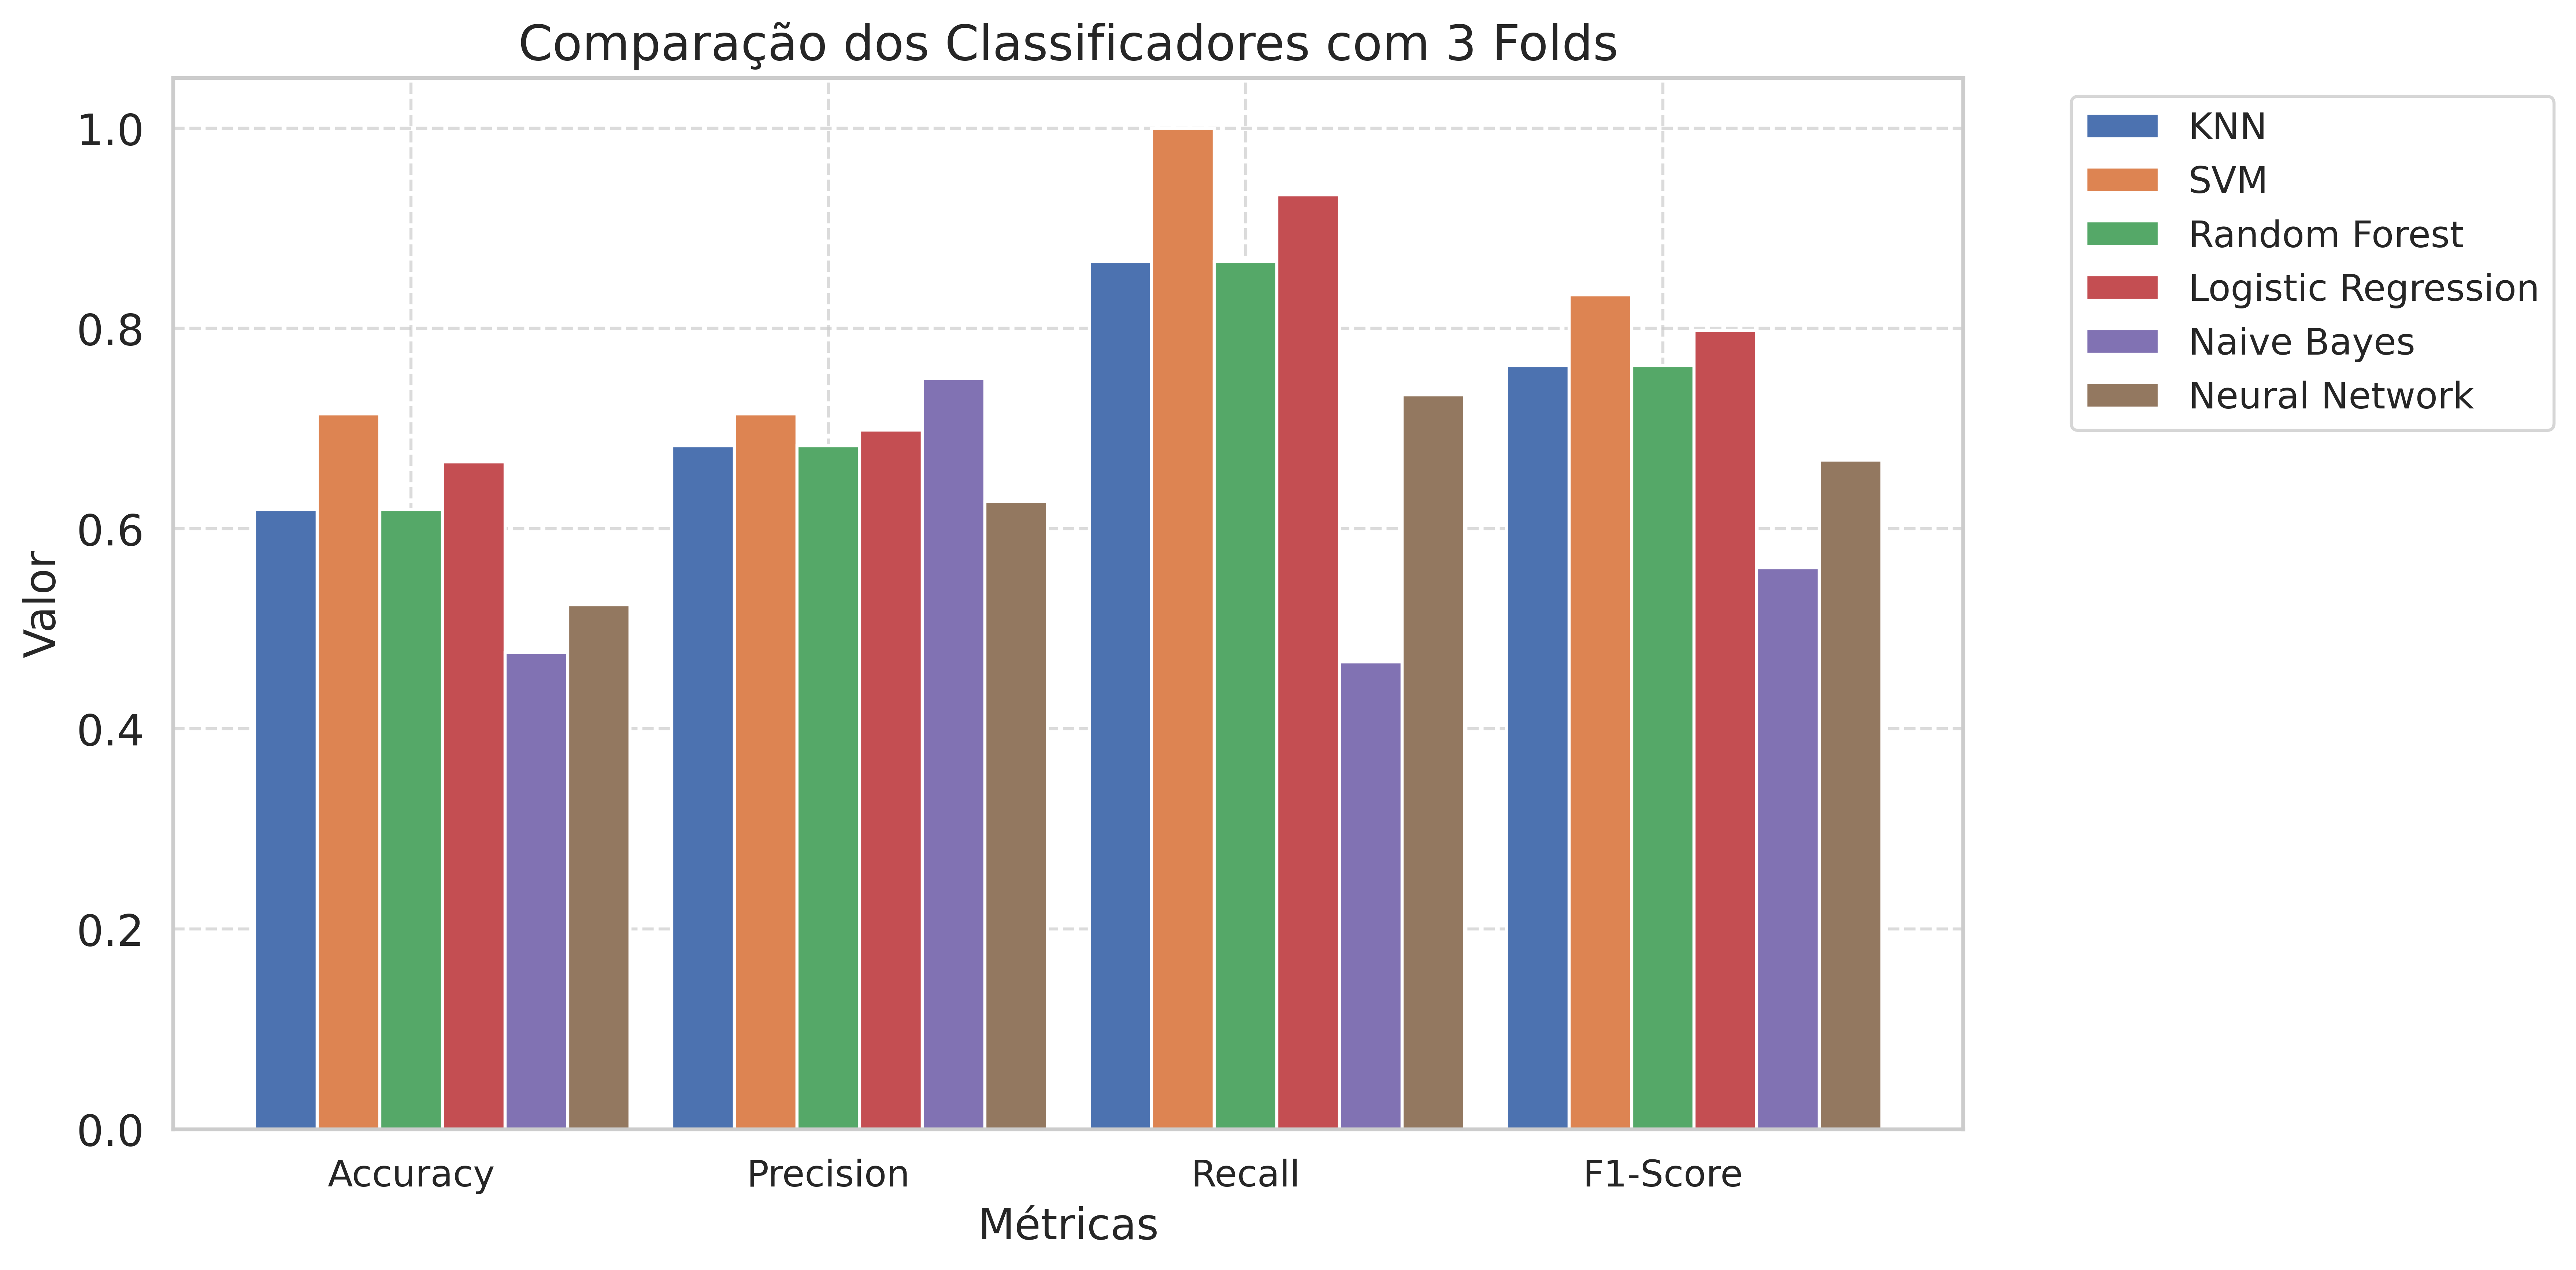

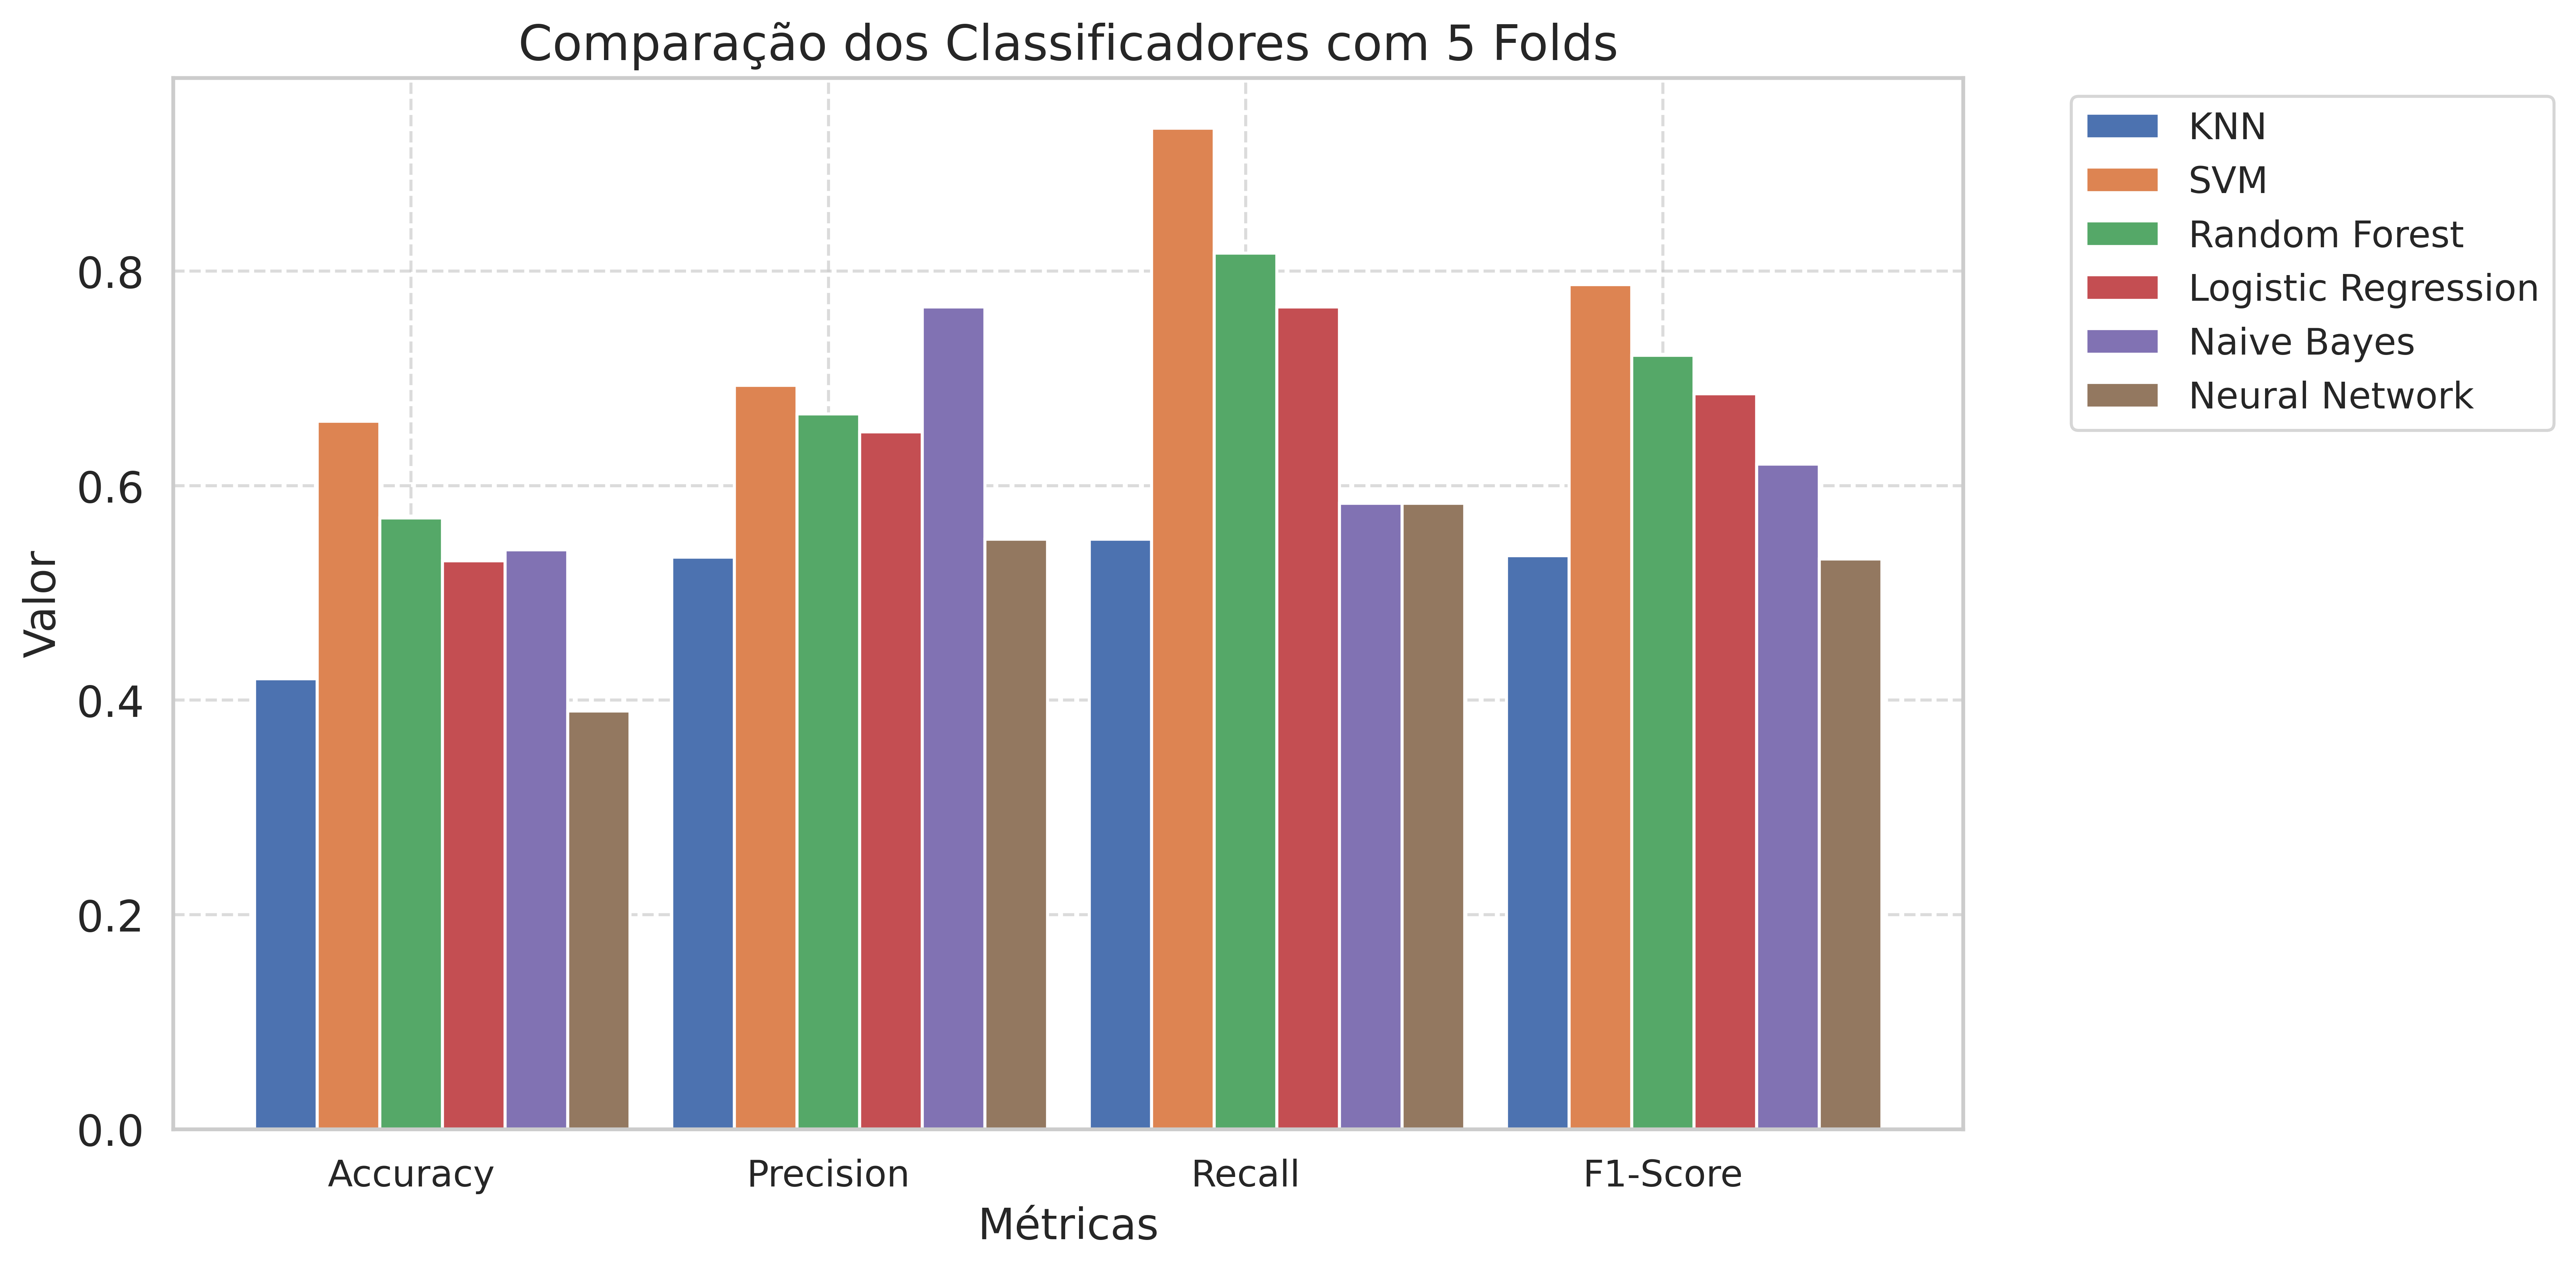

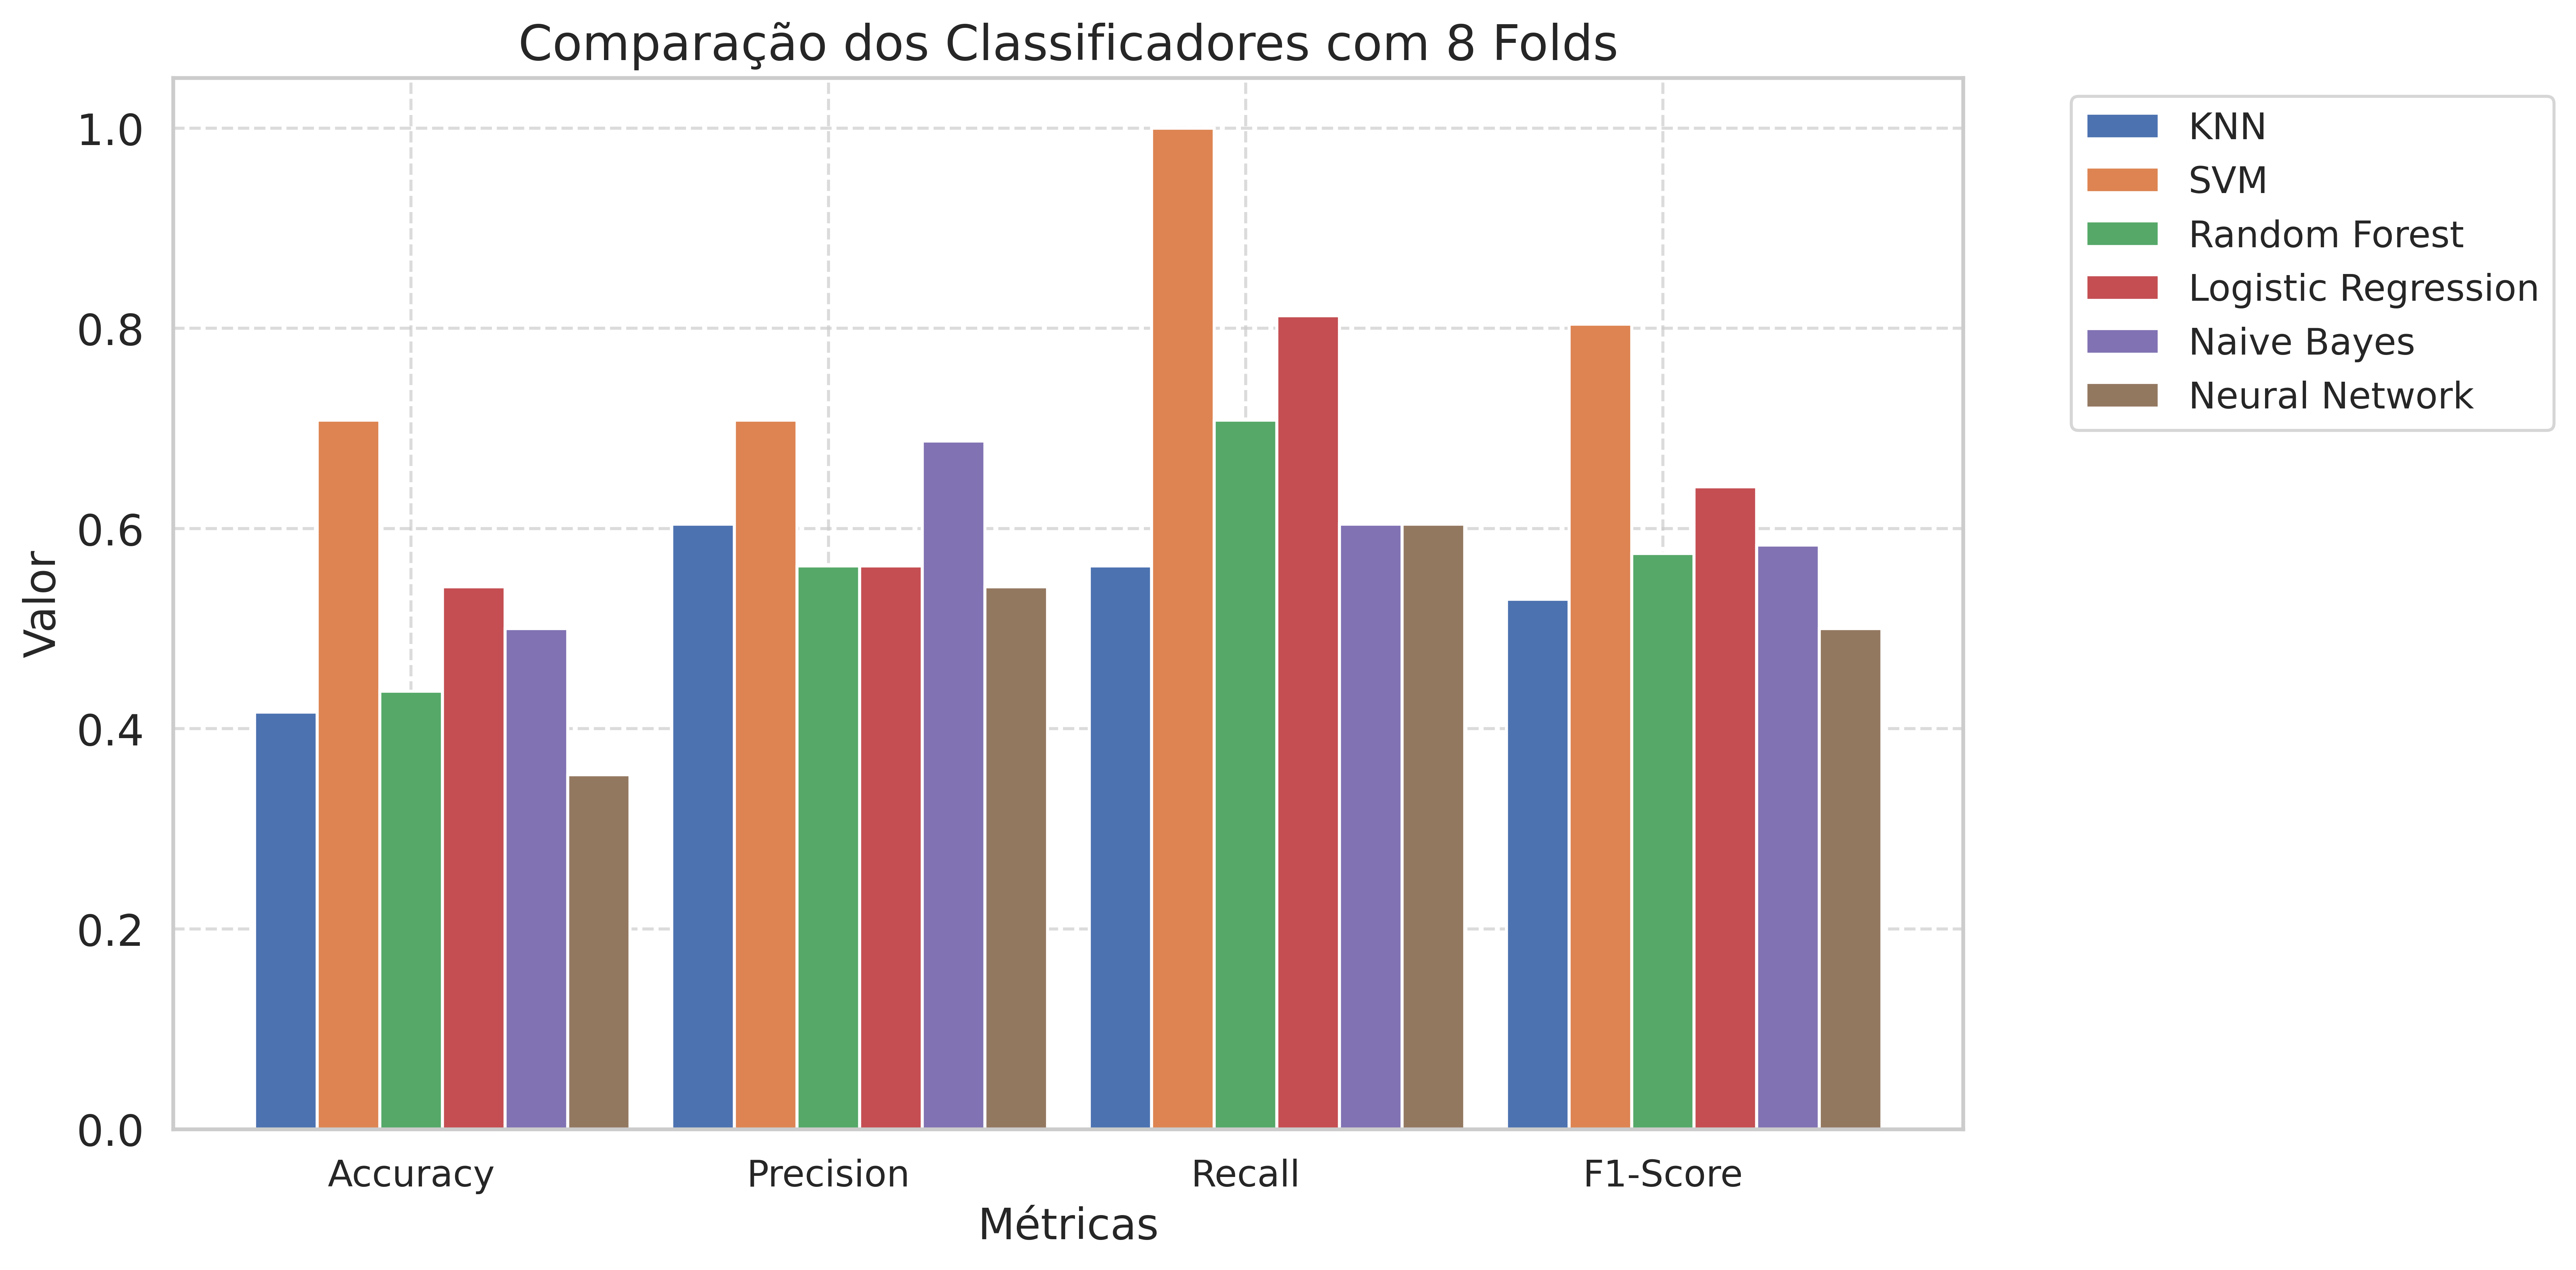

In [214]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Função para avaliar o classificador com K-Fold Cross-Validation
def evaluate_classifier_kfold(classifier, X, y, n_splits):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)  # Configura o K-Fold
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    for train_index, test_index in kf.split(X):
        # Separa dados de treino e teste
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Treina o classificador
        classifier.fit(X_train, y_train)

        # Faz previsões
        y_pred = classifier.predict(X_test)

        # Calcula métricas
        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))

    # Retorna as métricas médias
    return {
        'Accuracy': np.mean(accuracies),
        'Precision': np.mean(precisions),
        'Recall': np.mean(recalls),
        'F1-Score': np.mean(f1_scores)
    }

# Lista para armazenar os resultados de cada classificador
results_kfold = []

# Número de folds a serem testados
folds_list = [3, 5, 8]

# Loop para avaliar cada classificador com diferentes números de folds
for name, clf in classifiers.items():
    print(f"\nAvaliando o classificador: {name}")

    # Dicionário para armazenar os resultados do classificador
    classifier_results = {'Classifier': name}

    # Avalia o classificador para cada número de folds
    for n_splits in folds_list:
        print(f"  K-Fold com {n_splits} folds...")
        metrics = evaluate_classifier_kfold(clf, X_data[cols[:-1]].values, y_targets, n_splits)

        # Armazena as métricas no dicionário
        classifier_results[f'Accuracy_{n_splits}_folds'] = metrics['Accuracy']
        classifier_results[f'Precision_{n_splits}_folds'] = metrics['Precision']
        classifier_results[f'Recall_{n_splits}_folds'] = metrics['Recall']
        classifier_results[f'F1-Score_{n_splits}_folds'] = metrics['F1-Score']

    # Adiciona os resultados do classificador à lista
    results_kfold.append(classifier_results)

# Converte os resultados para DataFrame
results_kfold_df = pd.DataFrame(results_kfold)

# Exibe os resultados
print("\nResultados dos Classificadores com K-Fold Cross-Validation:")
print(results_kfold_df)

# Salva os resultados em CSV
results_kfold_df.to_csv('resultados_classificadores_kfold.csv', index=False)

# Plot das métricas dos classificadores para cada número de folds
for n_splits in folds_list:
    plt.figure(figsize=(12, 6))
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    x = np.arange(len(metrics))
    width = 0.15

    for i, classifier in enumerate(results_kfold_df['Classifier']):
        plt.bar(
            x + i * width,
            results_kfold_df.loc[i, [f'{metric}_{n_splits}_folds' for metric in metrics]],
            width,
            label=classifier
        )

    plt.xlabel('Métricas', fontsize=14)
    plt.ylabel('Valor', fontsize=14)
    plt.title(f'Comparação dos Classificadores com {n_splits} Folds', fontsize=16)
    plt.xticks(x + width * 2, metrics, fontsize=12)
    plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')  # Legenda fora do gráfico
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'comparacao_classificadores_{n_splits}_folds.png', dpi=400, bbox_inches='tight')  # Salva em PNG
    plt.show()